verificar se precisa fazer a normalização

arrumar o smearing

treinar com features menores

In [1]:
import lightgbm as lgb
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import mplhep as hep
from matplotlib.colors import ListedColormap
from sklearn.metrics import make_scorer,fbeta_score,precision_score,recall_score,accuracy_score,log_loss,roc_auc_score,classification_report,f1_score,confusion_matrix,roc_curve,precision_recall_curve,average_precision_score
import sys
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [2]:
pwd_savefig = '/home/matheus/4quadri_vertice/Acoplamento_Quartico_Anomalo/SwanCERN/Acoplamento_Quartico_Anomalo/output_2016/Gráficos/'
plt.style.use(hep.style.ROOT)

In [3]:
def open_file_MC( file ):
    df = None
    with h5py.File( file , 'r' ) as f:
        dset = f[ 'dados' ]
        array = np.array( dset ) 
        dataframe = pd.DataFrame( array , columns = ['Mww','Pt_W_lep','dPhi_Whad_Wlep','dPhi_jatos_MET','jetAK8_pt','jetAK8_eta',
       'jetAK8_prunedMass','jetAK8_tau21','METPt','muon_pt','muon_eta','ExtraTracks', 'Yww',
       'xi1','xi2','anguloX1', 'anguloX2', 'anguloY1','anguloY2', 'Mx','Yx', 'Mww/Mx','Yww_Yx' ,'weight'] )
        return dataframe

In [4]:
def open_file_Data( file ):
    df = None
    with h5py.File( file , 'r' ) as f:
        dset = f[ 'dados' ]
        array = np.array( dset ) 
        dataframe = pd.DataFrame( array , columns = ['Mww','Pt_W_lep','dPhi_Whad_Wlep','dPhi_jatos_MET','jetAK8_pt','jetAK8_eta',
    'jetAK8_prunedMass','jetAK8_tau21','METPt','muon_pt','muon_eta','ExtraTracks',  'Yww',
    'xi1','xi2','anguloX1', 'anguloX2', 'anguloY1','anguloY2', 'Mx','Yx', 'Mww/Mx','Yww_Yx'] )
        return dataframe

In [5]:
def do_scaler(X,Y, scaler_X, scaler_Y):
    if scaler_X == None:
        X_scaled = X
    else:
        X_scaled = scaler_X.fit_transform(X)
    if scaler_Y == None:
        Y_scaled = Y
    else:
        Y_scaled = scaler_Y.fit_transform(Y)
    return X_scaled, Y_scaled, scaler_X, scaler_Y


scaler = MinMaxScaler()
scaler_prediction = None

In [6]:
Drop_columns_dados = ['anguloX1','anguloX2','anguloY1','anguloY2',]
Drop_Columns = ['anguloX1','anguloX2','anguloY1','label','anguloY2', 'weight', ]
Drop_Columns_back = ['anguloX1','anguloX2','anguloY1','anguloY2', 'weight']

In [7]:
select_columns = ['Mww', 'Pt_W_lep', 'dPhi_Whad_Wlep', 'dPhi_jatos_MET', 'jetAK8_pt','jetAK8_eta', 'jetAK8_prunedMass', 'jetAK8_tau21', 'METPt', 'muon_pt', 'muon_eta', 'ExtraTracks', 'Yww', 'xi1', 'xi2', 'Mx', 'Yx', 'Mww/Mx', 'Yww_Yx']

In [8]:
SM =       open_file_MC('DataSet_SM_multiRP.h5')
ANOMALO1 = open_file_MC('DataSet_ANOMALO1_multiRP.h5')
ANOMALO2 = open_file_MC('DataSet_ANOMALO2_multiRP.h5')
ANOMALO3 = open_file_MC('DataSet_ANOMALO3_multiRP.h5')
ANOMALO4 = open_file_MC('DataSet_ANOMALO4_multiRP.h5')
ANOMALO5 = open_file_MC('DataSet_ANOMALO5_multiRP.h5')
ANOMALO6 = open_file_MC('DataSet_ANOMALO6_multiRP.h5')
ANOMALO7 = open_file_MC('DataSet_ANOMALO7_multiRP.h5')
ANOMALO8 = open_file_MC('DataSet_ANOMALO8_multiRP.h5')

In [9]:
label_signal1  = pd.DataFrame( [1]*len( ANOMALO1 ) )
label_signal2  = pd.DataFrame( [1]*len( ANOMALO2 ) )
label_signal3  = pd.DataFrame( [1]*len( ANOMALO3 ) )
label_signal4  = pd.DataFrame( [1]*len( ANOMALO4 ) )
label_signal5  = pd.DataFrame( [1]*len( ANOMALO5 ) )
label_signal6  = pd.DataFrame( [1]*len( ANOMALO6 ) )
label_signal7  = pd.DataFrame( [1]*len( ANOMALO7 ) )
label_signal8  = pd.DataFrame( [1]*len( ANOMALO8 ) )
label_signalSM = pd.DataFrame( [2]*len( SM ) )

In [10]:
SM = pd.concat( [ SM, label_signalSM ], axis = 1 ).rename(columns={0: 'label'})
print('Shape for Standard Model --> ', SM.shape)

ANOMALO1 = pd.concat( [ ANOMALO1, label_signal1 ], axis = 1 ).rename(columns={0: 'label'})
print('Shape for Anomalo 1 --> ', ANOMALO1.shape)

ANOMALO2 = pd.concat( [ ANOMALO2, label_signal2 ], axis = 1 ).rename(columns={0: 'label'})
print('Shape for Anomalo 2 --> ', ANOMALO2.shape)

ANOMALO3 = pd.concat( [ ANOMALO3, label_signal3 ], axis = 1 ).rename(columns={0: 'label'})
print('Shape for Anomalo 3 --> ', ANOMALO3.shape)

ANOMALO4 = pd.concat( [ ANOMALO4, label_signal4 ], axis = 1 ).rename(columns={0: 'label'})
print('Shape for Anomalo 4 --> ', ANOMALO4.shape)

ANOMALO5 = pd.concat( [ ANOMALO5, label_signal5 ], axis = 1 ).rename(columns={0: 'label'})
print('Shape for Anomalo 5 --> ', ANOMALO5.shape)

ANOMALO6 = pd.concat( [ ANOMALO6, label_signal6 ], axis = 1 ).rename(columns={0: 'label'})
print('Shape for Anomalo 6 --> ', ANOMALO6.shape)

ANOMALO7 = pd.concat( [ ANOMALO7, label_signal7 ], axis = 1 ).rename(columns={0: 'label'})
print('Shape for Anomalo 7 --> ', ANOMALO7.shape)

ANOMALO8 = pd.concat( [ ANOMALO8, label_signal8 ], axis = 1 ).rename(columns={0: 'label'})
print('Shape for Anomalo 8 --> ', ANOMALO8.shape)

Shape for Standard Model -->  (123, 25)
Shape for Anomalo 1 -->  (1903, 25)
Shape for Anomalo 2 -->  (192, 25)
Shape for Anomalo 3 -->  (511, 25)
Shape for Anomalo 4 -->  (886, 25)
Shape for Anomalo 5 -->  (191, 25)
Shape for Anomalo 6 -->  (338, 25)
Shape for Anomalo 7 -->  (806, 25)
Shape for Anomalo 8 -->  (1966, 25)


# Smearing para os xi's dos protons

alterar a composição dos xi's smearing. 

In [11]:
from random import gauss

def xi_smearing(dset):
    df_xi1 = []
    df_xi2 = []
    for i in range(0,len(dset)):
        df_xi1.append( gauss( 0, 0.1 * dset['xi1'][i] ) + np.array( dset['xi1'][i] ) )
        df_xi2.append( gauss( 0, 0.1 * dset['xi2'][i] ) + np.array( dset['xi2'][i] ) )
    xi1_smearing = pd.DataFrame( df_xi1, columns = ['xi1_smearing'] ) 
    xi2_smearing = pd.DataFrame( df_xi2, columns = ['xi2_smearing'] ) 
    return pd.concat( [ xi1_smearing, xi2_smearing ], axis = 1 )

In [12]:
'''SM = pd.concat( [ SM, xi_smearing(SM) ], axis = 1 )
ANOMALO1 = pd.concat( [ANOMALO1, xi_smearing(ANOMALO1) ], axis = 1 )
ANOMALO2 = pd.concat( [ANOMALO2, xi_smearing(ANOMALO2) ], axis = 1 )
ANOMALO3 = pd.concat( [ANOMALO3, xi_smearing(ANOMALO3) ], axis = 1 )
ANOMALO4 = pd.concat( [ANOMALO4, xi_smearing(ANOMALO4) ], axis = 1 )
ANOMALO5 = pd.concat( [ANOMALO5, xi_smearing(ANOMALO5) ], axis = 1 )
ANOMALO6 = pd.concat( [ANOMALO6, xi_smearing(ANOMALO6) ], axis = 1 )
ANOMALO7 = pd.concat( [ANOMALO7, xi_smearing(ANOMALO7) ], axis = 1 )
ANOMALO8 = pd.concat( [ANOMALO8, xi_smearing(ANOMALO8) ], axis = 1 )'''

'SM = pd.concat( [ SM, xi_smearing(SM) ], axis = 1 )\nANOMALO1 = pd.concat( [ANOMALO1, xi_smearing(ANOMALO1) ], axis = 1 )\nANOMALO2 = pd.concat( [ANOMALO2, xi_smearing(ANOMALO2) ], axis = 1 )\nANOMALO3 = pd.concat( [ANOMALO3, xi_smearing(ANOMALO3) ], axis = 1 )\nANOMALO4 = pd.concat( [ANOMALO4, xi_smearing(ANOMALO4) ], axis = 1 )\nANOMALO5 = pd.concat( [ANOMALO5, xi_smearing(ANOMALO5) ], axis = 1 )\nANOMALO6 = pd.concat( [ANOMALO6, xi_smearing(ANOMALO6) ], axis = 1 )\nANOMALO7 = pd.concat( [ANOMALO7, xi_smearing(ANOMALO7) ], axis = 1 )\nANOMALO8 = pd.concat( [ANOMALO8, xi_smearing(ANOMALO8) ], axis = 1 )'

In [13]:
DataSet_multiRP_DrellYan = open_file_MC( 'DataSet_multiRP_DrellYan.h5' )
DataSet_multiRP_QCD = open_file_MC( 'DataSet_multiRP_QCD.h5' )
DataSet_multiRP_single_top = open_file_MC( 'DataSet_multiRP_single_top.h5' )
DataSet_multiRP_TTbar = open_file_MC( 'DataSet_multiRP_TTbar.h5' )
DataSet_multiRP_VV_inclusivo = open_file_MC( 'DataSet_multiRP_VV_inclusivo.h5' )
DataSet_multiRP_WJets = open_file_MC( 'DataSet_multiRP_WJets.h5' )

In [14]:
label_DrellYan = pd.DataFrame( [0]*len( DataSet_multiRP_DrellYan ) )
DataSet_multiRP_DrellYan = pd.concat( [ DataSet_multiRP_DrellYan, label_DrellYan ], axis = 1 ).rename(columns={0: 'label'})

label_QCD = pd.DataFrame( [0]*len( DataSet_multiRP_QCD ) )
DataSet_multiRP_QCD = pd.concat( [ DataSet_multiRP_QCD, label_QCD ], axis = 1 ).rename(columns={0: 'label'})

label_SingleTop = pd.DataFrame( [0]*len( DataSet_multiRP_single_top ) )
DataSet_multiRP_single_top = pd.concat( [ DataSet_multiRP_single_top, label_SingleTop ], axis = 1 ).rename(columns={0: 'label'})

label_TTbar = pd.DataFrame( [0]*len( DataSet_multiRP_TTbar ) )
DataSet_multiRP_TTbar = pd.concat( [ DataSet_multiRP_TTbar, label_TTbar ], axis = 1 ).rename(columns={0: 'label'})

label_VVInclusive = pd.DataFrame( [0]*len( DataSet_multiRP_VV_inclusivo ) )
DataSet_multiRP_VV_inclusivo = pd.concat( [ DataSet_multiRP_VV_inclusivo, label_VVInclusive ], axis = 1 ).rename(columns={0: 'label'})

label_WJets = pd.DataFrame( [0]*len( DataSet_multiRP_WJets ) )
DataSet_multiRP_WJets = pd.concat( [ DataSet_multiRP_WJets, label_WJets ], axis = 1 ).rename(columns={0: 'label'})

In [15]:
data_set_back_multirp = open_file_MC( 'DataSet_back_multiRP.h5' )

In [16]:
label_back = pd.DataFrame( [0]*len( data_set_back_multirp ) )
data_set_back_multirp = pd.concat( [ data_set_back_multirp, label_back ], axis = 1 ).rename(columns={0: 'label'})
#data_set_back_multirp['xi1_smearing'] = data_set_back_multirp['xi1']
#data_set_back_multirp['xi2_smearing'] = data_set_back_multirp['xi2']
data_set_back_multirp

,Mww,Pt_W_lep,dPhi_Whad_Wlep,dPhi_jatos_MET,jetAK8_pt,jetAK8_eta,jetAK8_prunedMass,jetAK8_tau21,METPt,muon_pt,...,anguloX1,anguloX2,anguloY1,anguloY2,Mx,Yx,Mww/Mx,Yww_Yx,weight,label
0,776.790699,203.610961,2.839334,2.809931,251.823184,0.220657,6.258214,0.697070,78.927462,124.739197,...,0.000035,-0.000068,0.000036,-0.000058,809.745503,-0.003286,0.959302,-1.970903,8.337446e-02,0
1,438.002104,208.706733,2.839505,3.000276,204.586686,0.163937,11.753319,0.819672,40.156142,169.190598,...,-0.000013,0.000010,0.000082,0.000002,1190.839156,-0.373776,0.367810,-0.118598,9.485314e-02,0
2,384.644871,104.686847,2.501811,-2.959924,241.350376,1.143930,7.357574,0.718043,71.276725,76.644829,...,-0.000114,-0.000064,0.000020,-0.000046,1117.509427,-0.162422,0.344198,0.598838,3.988195e-02,0
3,383.698648,180.697567,-2.608963,-2.463155,201.385208,1.088093,7.654839,0.798205,116.878378,67.239105,...,-0.000103,0.000030,-0.000033,-0.000006,1293.510582,-0.080450,0.296634,0.783360,9.460630e-02,0
4,582.522800,168.205840,-3.034785,-1.892056,217.617612,1.763204,47.846977,0.560087,97.098621,155.440155,...,-0.000074,-0.000112,-0.000060,-0.000075,939.387391,-0.197769,0.620109,-0.616985,5.665457e-12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330901,340.969075,35.250189,-0.209862,3.025586,349.431480,0.340937,91.261391,0.483213,55.095029,90.250557,...,0.000083,-0.000089,0.000010,-0.000053,1240.138916,-0.202400,0.274944,0.016373,1.537366e-03,0
330902,977.719609,336.490681,-2.426913,2.629844,701.580412,0.192847,13.197932,0.831868,71.038724,319.581726,...,-0.000109,-0.000032,0.000010,-0.000002,1193.246297,0.057627,0.819378,-0.347246,5.700535e-03,0
330903,453.456018,161.427029,-2.884585,-2.578502,242.306511,0.462388,94.724037,0.212715,94.380060,76.886635,...,-0.000104,0.000079,-0.000060,0.000018,1518.070135,0.002757,0.298706,-1.201939,2.308023e-03,0
330904,457.523768,185.245251,3.001437,3.011061,211.883645,1.754692,11.399350,0.814306,113.660139,71.598732,...,0.000075,-0.000017,-0.000074,-0.000031,819.076895,-0.088833,0.558585,-0.605905,2.553943e-03,0


In [17]:
Dataset_Signal_Back1  = pd.concat( [ ANOMALO1 , data_set_back_multirp, SM  ], axis = 0, sort = False )
Dataset_Signal_Back2  = pd.concat( [ ANOMALO2 , data_set_back_multirp, SM  ], axis = 0, sort = False )
Dataset_Signal_Back3  = pd.concat( [ ANOMALO3 , data_set_back_multirp, SM  ], axis = 0, sort = False )
Dataset_Signal_Back4  = pd.concat( [ ANOMALO4 , data_set_back_multirp, SM  ], axis = 0, sort = False )
Dataset_Signal_Back5  = pd.concat( [ ANOMALO5 , data_set_back_multirp, SM  ], axis = 0, sort = False )
Dataset_Signal_Back6  = pd.concat( [ ANOMALO6 , data_set_back_multirp, SM  ], axis = 0, sort = False )
Dataset_Signal_Back7  = pd.concat( [ ANOMALO7 , data_set_back_multirp, SM  ], axis = 0, sort = False )
Dataset_Signal_Back8  = pd.concat( [ ANOMALO8 , data_set_back_multirp, SM  ], axis = 0, sort = False )

In [18]:
data_set_dados_multirp = open_file_Data( 'DataSet_dados_multiRP.h5' )
#data_set_dados_multirp['xi1_smearing'] = data_set_dados_multirp['xi1']
#data_set_dados_multirp['xi2_smearing'] = data_set_dados_multirp['xi2']
data_set_dados_multirp

,Mww,Pt_W_lep,dPhi_Whad_Wlep,dPhi_jatos_MET,jetAK8_pt,jetAK8_eta,jetAK8_prunedMass,jetAK8_tau21,METPt,muon_pt,...,xi1,xi2,anguloX1,anguloX2,anguloY1,anguloY2,Mx,Yx,Mww/Mx,Yww_Yx
0,377.956870,149.120613,2.127574,2.353933,257.034907,0.408763,55.408325,0.651385,40.323364,110.198120,...,0.115222,0.109433,-0.000145,-0.000065,0.000079,-0.000056,1459.767139,0.025774,0.258916,-1.009239
1,366.160235,126.560767,2.985257,3.063242,219.436461,1.965050,11.086693,0.932706,72.171563,54.897240,...,0.068406,0.051486,-0.000011,-0.000043,-0.000045,-0.000042,771.502381,0.142071,0.474607,-1.578545
2,741.827618,213.047177,3.010690,1.859894,226.343484,0.390933,74.849960,0.565876,57.706423,196.705261,...,0.105611,0.073181,0.000028,0.000068,0.000073,-0.000102,1142.870196,0.183416,0.649092,-1.666097
3,877.505354,123.897340,2.012689,2.549330,233.792329,0.997459,32.459290,0.487617,92.757254,64.812515,...,0.059030,0.074471,-0.000041,0.000005,-0.000045,-0.000052,861.936296,-0.116178,1.018063,2.090252
4,781.795723,350.697573,-3.013293,-2.860292,402.634166,1.507299,37.748211,0.642403,259.948342,101.810310,...,0.099538,0.095934,0.000027,-0.000004,0.000086,0.000025,1270.353032,0.018436,0.615416,1.149649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11473,594.966594,123.353057,-3.069317,-3.071775,227.177937,0.532675,10.762535,0.817331,62.413265,60.940174,...,0.083862,0.115110,-0.000036,-0.000072,-0.000051,-0.000048,1277.275628,-0.158357,0.465809,2.805056
11474,610.655829,162.879420,-2.707691,-2.249488,307.777989,0.694473,120.028419,0.449982,90.567956,90.951927,...,0.085737,0.143289,0.000012,-0.000163,0.000034,0.000032,1440.897731,-0.256792,0.423802,-0.463811
11475,905.681403,410.041595,-2.741795,-2.756343,353.064677,1.242856,47.823807,0.656382,276.760091,133.371582,...,0.090407,0.107519,-0.000002,0.000030,-0.000020,0.000056,1281.699892,-0.086676,0.706625,0.080987
11476,275.117007,65.138471,-2.228238,-1.170651,220.157837,0.627313,45.109364,0.652947,45.789513,58.402706,...,0.052520,0.073482,0.000133,-0.000005,-0.000049,-0.000035,807.599762,-0.167924,0.340660,0.574351


In [19]:
from sklearn.model_selection import train_test_split

In [20]:
test_size = 0.35
DataSet_Train1_, DataSet_Test1_ = train_test_split( Dataset_Signal_Back1, test_size = test_size, random_state = 41, stratify = Dataset_Signal_Back1.label )
DataSet_Train2_, DataSet_Test2_ = train_test_split( Dataset_Signal_Back2, test_size = test_size, random_state = 41, stratify = Dataset_Signal_Back2.label )
DataSet_Train3_, DataSet_Test3_ = train_test_split( Dataset_Signal_Back3, test_size = test_size, random_state = 41, stratify = Dataset_Signal_Back3.label )
DataSet_Train4_, DataSet_Test4_ = train_test_split( Dataset_Signal_Back4, test_size = test_size, random_state = 41, stratify = Dataset_Signal_Back4.label )
DataSet_Train5_, DataSet_Test5_ = train_test_split( Dataset_Signal_Back5, test_size = test_size, random_state = 41, stratify = Dataset_Signal_Back5.label )
DataSet_Train6_, DataSet_Test6_ = train_test_split( Dataset_Signal_Back6, test_size = test_size, random_state = 41, stratify = Dataset_Signal_Back6.label )
DataSet_Train7_, DataSet_Test7_ = train_test_split( Dataset_Signal_Back7, test_size = test_size, random_state = 41, stratify = Dataset_Signal_Back7.label )
DataSet_Train8_, DataSet_Test8_ = train_test_split( Dataset_Signal_Back8, test_size = test_size, random_state = 41, stratify = Dataset_Signal_Back8.label )

In [21]:
with h5py.File( 'DataSet_Test1_.h5', 'w') as f:
    dset = f.create_dataset( 'dados', data = DataSet_Test1_ )
with h5py.File( 'output-' + label_ + '.h5', 'w') as f:
    dset = f.create_dataset( 'dados', data = DataSet_Test2_ )
with h5py.File( 'output-' + label_ + '.h5', 'w') as f:
    dset = f.create_dataset( 'dados', data = DataSet_Test1_ ) 
with h5py.File( 'output-' + label_ + '.h5', 'w') as f:
    dset = f.create_dataset( 'dados', data = DataSet_Test1_ )
with h5py.File( 'output-' + label_ + '.h5', 'w') as f:
    dset = f.create_dataset( 'dados', data = DataSet_Test1_ )    
with h5py.File( 'output-' + label_ + '.h5', 'w') as f:
    dset = f.create_dataset( 'dados', data = DataSet_Test1_ )
with h5py.File( 'output-' + label_ + '.h5', 'w') as f:
    dset = f.create_dataset( 'dados', data = DataSet_Test1_ )
with h5py.File( 'output-' + label_ + '.h5', 'w') as f:
    dset = f.create_dataset( 'dados', data = DataSet_Test1_ )    

,Mww,Pt_W_lep,dPhi_Whad_Wlep,dPhi_jatos_MET,jetAK8_pt,jetAK8_eta,jetAK8_prunedMass,jetAK8_tau21,METPt,muon_pt,...,anguloX1,anguloX2,anguloY1,anguloY2,Mx,Yx,Mww/Mx,Yww_Yx,weight,label
224755,174.416872,150.836891,0.285603,1.335912,285.874254,0.168908,6.299238,0.712502,40.985170,135.213959,...,0.000036,0.000037,-0.000080,0.000102,592.261640,0.090463,0.294493,0.063063,0.020271,0
91174,562.460261,311.439498,2.300486,1.541109,278.909631,0.984407,15.207295,0.777892,46.208519,279.740906,...,0.000056,0.000028,0.000051,-0.000036,1256.388227,0.023800,0.447680,-1.104888,0.012267,0
324886,762.109018,367.370084,-2.874947,-3.089839,361.237154,1.160607,73.404213,0.622326,65.562929,303.637177,...,-0.000013,-0.000006,0.000055,0.000037,1048.695245,-0.270992,0.726721,0.895869,0.010471,0
89485,591.048588,295.477423,-3.032271,-2.706101,282.991561,1.795295,10.193092,0.913363,94.893815,207.823029,...,0.000045,0.000033,0.000037,-0.000042,902.698379,0.346966,0.654758,1.251549,0.022229,0
10142,723.737453,371.902919,-2.897148,-2.894025,343.263700,1.839723,8.739612,0.898024,114.769695,257.134033,...,0.000003,0.000112,0.000003,-0.000159,998.290334,-0.071968,0.724977,-2.020695,0.010689,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19324,1132.972169,439.337299,2.995275,2.878167,434.254585,0.667035,24.941669,0.680484,68.591177,371.302429,...,-0.000090,0.000075,-0.000030,0.000036,1204.546921,0.051983,0.940580,-0.877273,0.001524,0
271873,630.707104,248.726449,3.044349,-3.068955,284.927547,2.065751,9.185022,0.919933,152.822565,101.449051,...,-0.000013,0.000066,0.000054,-0.000095,846.883612,0.184743,0.744739,-1.107350,0.017153,0
51023,652.576227,217.185237,2.832490,2.715227,426.421764,0.390385,83.608177,0.702229,155.891549,64.976471,...,0.000035,-0.000086,-0.000033,0.000017,1063.192982,0.054366,0.613789,0.200886,0.103182,0
304226,2171.813850,635.983823,-3.110291,-3.041925,701.975555,0.802677,19.079601,0.847583,299.076310,338.223785,...,-0.000033,0.000044,0.000022,-0.000055,887.437247,0.009720,2.447287,1.312750,0.001730,0


In [22]:
y_train1 = DataSet_Train1_['label']
y_test1  = DataSet_Test1_['label']

y_train2 = DataSet_Train2_['label']
y_test2  = DataSet_Test2_['label']

y_train3 = DataSet_Train3_['label']
y_test3  = DataSet_Test3_['label']

y_train4 = DataSet_Train4_['label']
y_test4  = DataSet_Test4_['label']

y_train5 = DataSet_Train5_['label']
y_test5  = DataSet_Test5_['label']

y_train6 = DataSet_Train6_['label']
y_test6  = DataSet_Test6_['label']

y_train7 = DataSet_Train7_['label']
y_test7  = DataSet_Test7_['label']

y_train8 = DataSet_Train8_['label']
y_test8  = DataSet_Test8_['label']

In [23]:
print('--- Weight Anomalo 8 --- \n')
DataSet_Test8_weight_signal =  DataSet_Test8_[DataSet_Test8_['label']==1]['weight'] 
DataSet_TestSM8_weight_signal =  DataSet_Test8_[DataSet_Test8_['label']==2]['weight'] 
DataSet_Test8_weight_backgr =DataSet_Test8_[DataSet_Test8_['label']==0]['weight'] 

DataSet_Train8_weight_signal = DataSet_Train8_[DataSet_Train8_['label']==1]['weight']
DataSet_TrainSM8_weight_signal =  DataSet_Train8_[DataSet_Train8_['label']==2]['weight']
DataSet_Train8_weight_backgr = DataSet_Train8_[DataSet_Train8_['label']==0]['weight'] 

DataSet_Test8_weight =  DataSet_Test8_['weight']

print( 'Shape Test Signal', DataSet_Test8_weight_signal.shape)
print( 'Shape Test SM', DataSet_TestSM8_weight_signal.shape)
print( 'Shape Test Background', DataSet_Test8_weight_backgr.shape, '\n')

print('--- Weight Anomalo 7 --- \n')

DataSet_Test7_weight_signal =  DataSet_Test7_[DataSet_Test7_['label']==1]['weight'] 
DataSet_TestSM7_weight_signal =DataSet_Test7_[DataSet_Test7_['label']==2]['weight'] 
DataSet_Test7_weight_backgr =  DataSet_Test7_[DataSet_Test7_['label']==0]['weight'] 

DataSet_Train7_weight_signal =  DataSet_Train7_[DataSet_Train7_['label']==1]['weight']
DataSet_TrainSM7_weight_signal =  DataSet_Train7_[DataSet_Train7_['label']==2]['weight']
DataSet_Train7_weight_backgr =  DataSet_Train7_[DataSet_Train7_['label']==0]['weight'] 

DataSet_Test7_weight =  DataSet_Test7_['weight']

print('--- Weight Anomalo 6 --- \n')

DataSet_Test6_weight_signal =  DataSet_Test6_[DataSet_Test6_['label']==1]['weight'] 
DataSet_TestSM6_weight_signal =DataSet_Test6_[DataSet_Test6_['label']==2]['weight'] 
DataSet_Test6_weight_backgr =  DataSet_Test6_[DataSet_Test6_['label']==0]['weight'] 

DataSet_Train6_weight_signal =  DataSet_Train6_[DataSet_Train6_['label']==1]['weight']
DataSet_TrainSM6_weight_signal =  DataSet_Train6_[DataSet_Train6_['label']==2]['weight']
DataSet_Train6_weight_backgr =  DataSet_Train6_[DataSet_Train6_['label']==0]['weight'] 

DataSet_Test6_weight =  DataSet_Test6_['weight']

print( 'Shape Test Signal',  DataSet_Test7_weight_signal.shape)
print( 'Shape Test SM', DataSet_TestSM7_weight_signal.shape)
print( 'Shape Test Background' , DataSet_Test7_weight_backgr.shape, '\n')

print('--- Weight Anomalo 5 --- \n')

DataSet_Test5_weight_signal =  DataSet_Test5_[DataSet_Test5_['label']==1]['weight'] 
DataSet_TestSM5_weight_signal =DataSet_Test5_[DataSet_Test5_['label']==2]['weight'] 
DataSet_Test5_weight_backgr =  DataSet_Test5_[DataSet_Test5_['label']==0]['weight'] 

DataSet_Train5_weight_signal =  DataSet_Train5_[DataSet_Train5_['label']==1]['weight']
DataSet_TrainSM5_weight_signal =  DataSet_Train5_[DataSet_Train5_['label']==2]['weight']
DataSet_Train5_weight_backgr =  DataSet_Train5_[DataSet_Train5_['label']==0]['weight'] 

DataSet_Test5_weight =  DataSet_Test5_['weight']

print( 'Shape Test Signal',  DataSet_Test7_weight_signal.shape)
print( 'Shape Test SM', DataSet_TestSM7_weight_signal.shape)
print( 'Shape Test Background' , DataSet_Test7_weight_backgr.shape, '\n')

print('--- Weight Anomalo 1 --- \n')

DataSet_Test1_weight_signal =  DataSet_Test1_[DataSet_Test1_['label']==1]['weight'] 
DataSet_TestSM1_weight_signal =  DataSet_Test1_[DataSet_Test1_['label']==2]['weight'] 
DataSet_Test1_weight_backgr =  DataSet_Test1_[DataSet_Test1_['label']==0]['weight'] 

DataSet_Train1_weight_signal =  DataSet_Train1_[DataSet_Train1_['label']==1]['weight']
DataSet_TrainSM1_weight_signal =  DataSet_Train1_[DataSet_Train1_['label']==2]['weight']
DataSet_Train1_weight_backgr = DataSet_Train1_[DataSet_Train1_['label']==0]['weight'] 

DataSet_Test1_weight =  DataSet_Test1_['weight']

print( 'Shape Test Signal', DataSet_Test1_weight_signal.shape)
print('Shape Test SM',  DataSet_TestSM1_weight_signal.shape)
print( 'Shape Test Background' , DataSet_Test1_weight_backgr.shape, '\n')

print('--- Weight Anomalo 2 --- \n')

DataSet_Test2_weight_signal =  DataSet_Test2_[DataSet_Test2_['label']==1]['weight'] 
DataSet_TestSM2_weight_signal =  DataSet_Test2_[DataSet_Test2_['label']==2]['weight'] 
DataSet_Test2_weight_backgr =  DataSet_Test2_[DataSet_Test2_['label']==0]['weight'] 

DataSet_Train2_weight_signal =  DataSet_Train2_[DataSet_Train2_['label']==1]['weight']
DataSet_TrainSM2_weight_signal =  DataSet_Train2_[DataSet_Train2_['label']==2]['weight']
DataSet_Train2_weight_backgr = DataSet_Train2_[DataSet_Train2_['label']==0]['weight'] 

DataSet_Test2_weight =  DataSet_Test2_['weight']

print( 'Shape Test Signal', DataSet_Test2_weight_signal.shape)
print('Shape Test SM',  DataSet_TestSM2_weight_signal.shape)
print( 'Shape Test Background' , DataSet_Test2_weight_backgr.shape, '\n')

print('--- Weight Anomalo 3 --- \n')

DataSet_Test3_weight_signal =  DataSet_Test3_[DataSet_Test3_['label']==1]['weight'] 
DataSet_TestSM3_weight_signal =  DataSet_Test3_[DataSet_Test3_['label']==2]['weight'] 
DataSet_Test3_weight_backgr =  DataSet_Test3_[DataSet_Test3_['label']==0]['weight'] 

DataSet_Train3_weight_signal =  DataSet_Train3_[DataSet_Train3_['label']==1]['weight']
DataSet_TrainSM3_weight_signal =  DataSet_Train3_[DataSet_Train3_['label']==2]['weight']
DataSet_Train3_weight_backgr = DataSet_Train3_[DataSet_Train3_['label']==0]['weight'] 

DataSet_Test3_weight =  DataSet_Test2_['weight']

print( 'Shape Test Signal', DataSet_Test3_weight_signal.shape)
print('Shape Test SM',  DataSet_TestSM3_weight_signal.shape)
print( 'Shape Test Background' , DataSet_Test3_weight_backgr.shape, '\n')

print('--- Weight Anomalo 4 --- \n')

DataSet_Test4_weight_signal = DataSet_Test4_[DataSet_Test4_['label']==1]['weight'] 
DataSet_TestSM4_weight_signal =  DataSet_Test4_[DataSet_Test4_['label']==2]['weight'] 
DataSet_Test4_weight_backgr = DataSet_Test4_[DataSet_Test4_['label']==0]['weight'] 

DataSet_Train4_weight_signal = DataSet_Train4_[DataSet_Train4_['label']==1]['weight']
DataSet_TrainSM4_weight_signal =  DataSet_Train4_[DataSet_Train4_['label']==2]['weight']
DataSet_Train4_weight_backgr = DataSet_Train4_[DataSet_Train4_['label']==0]['weight'] 

DataSet_Test4_weight =  DataSet_Test4_['weight']

print( 'Shape Test SM' , DataSet_Test4_weight_signal.shape)
print( 'Shape Test SM', DataSet_TestSM4_weight_signal.shape)
print( 'Shape Test Background' , DataSet_Test4_weight_backgr.shape)

--- Weight Anomalo 8 --- 

Shape Test Signal (688,)
Shape Test SM (43,)
Shape Test Background (115818,) 

--- Weight Anomalo 7 --- 

--- Weight Anomalo 6 --- 

Shape Test Signal (282,)
Shape Test SM (43,)
Shape Test Background (115818,) 

--- Weight Anomalo 5 --- 

Shape Test Signal (282,)
Shape Test SM (43,)
Shape Test Background (115818,) 

--- Weight Anomalo 1 --- 

Shape Test Signal (666,)
Shape Test SM (43,)
Shape Test Background (115818,) 

--- Weight Anomalo 2 --- 

Shape Test Signal (67,)
Shape Test SM (43,)
Shape Test Background (115818,) 

--- Weight Anomalo 3 --- 

Shape Test Signal (179,)
Shape Test SM (43,)
Shape Test Background (115817,) 

--- Weight Anomalo 4 --- 

Shape Test SM (310,)
Shape Test SM (43,)
Shape Test Background (115818,)


In [24]:

DataSet_Train8 = DataSet_Train8_[select_columns] 
DataSet_Test8 = DataSet_Test8_[select_columns] 

DataSet_Train7 = DataSet_Train7_[select_columns] 
DataSet_Test7 = DataSet_Test7_[select_columns] 

DataSet_Train6 = DataSet_Train6_[select_columns] 
DataSet_Test6 = DataSet_Test6_[select_columns] 

DataSet_Train5 = DataSet_Train5_[select_columns] 
DataSet_Test5 = DataSet_Test5_[select_columns] 

DataSet_Train1 = DataSet_Train1_[select_columns] 
DataSet_Test1 = DataSet_Test1_[select_columns] 

DataSet_Train2 = DataSet_Train2_[select_columns] 
DataSet_Test2 = DataSet_Test2_[select_columns] 

DataSet_Train3 = DataSet_Train3_[select_columns] 
DataSet_Test3 = DataSet_Test3_[select_columns] 

DataSet_Train4 = DataSet_Train4_[select_columns] 
DataSet_Test4 = DataSet_Test4_[select_columns] 


In [25]:
'''scaler = MinMaxScaler()
scaler.fit(DataSet_Train8)
scaler.fit(DataSet_Train7)
scaler.fit(DataSet_Train6)
scaler.fit(DataSet_Train5)
scaler.fit(DataSet_Train4)
scaler.fit(DataSet_Train3)
scaler.fit(DataSet_Train2)
scaler.fit(DataSet_Train1)

DataSet_Train8 = pd.DataFrame(data=scaler.transform(DataSet_Train8),columns=DataSet_Train8.columns)
DataSet_Test8 = pd.DataFrame(data=scaler.transform(DataSet_Test8),columns=DataSet_Test8.columns)
DataSet_Train7 = pd.DataFrame(data=scaler.transform(DataSet_Train7),columns=DataSet_Train7.columns)
DataSet_Test7 = pd.DataFrame(data=scaler.transform(DataSet_Test7),columns=DataSet_Test7.columns)
DataSet_Train6 = pd.DataFrame(data=scaler.transform(DataSet_Train6),columns=DataSet_Train6.columns)
DataSet_Test6 = pd.DataFrame(data=scaler.transform(DataSet_Test6),columns=DataSet_Test6.columns)
DataSet_Train5 = pd.DataFrame(data=scaler.transform(DataSet_Train5),columns=DataSet_Train5.columns)
DataSet_Test5 = pd.DataFrame(data=scaler.transform(DataSet_Test5),columns=DataSet_Test5.columns)
DataSet_Train4 = pd.DataFrame(data=scaler.transform(DataSet_Train4),columns=DataSet_Train4.columns)
DataSet_Test4 = pd.DataFrame(data=scaler.transform(DataSet_Test4),columns=DataSet_Test4.columns)
DataSet_Train3 = pd.DataFrame(data=scaler.transform(DataSet_Train3),columns=DataSet_Train3.columns)
DataSet_Test3 = pd.DataFrame(data=scaler.transform(DataSet_Test3),columns=DataSet_Test3.columns)
DataSet_Train2 = pd.DataFrame(data=scaler.transform(DataSet_Train2),columns=DataSet_Train2.columns)
DataSet_Test2 = pd.DataFrame(data=scaler.transform(DataSet_Test2),columns=DataSet_Test2.columns)
DataSet_Train1 = pd.DataFrame(data=scaler.transform(DataSet_Train1),columns=DataSet_Train1.columns)
DataSet_Test1 = pd.DataFrame(data=scaler.transform(DataSet_Test1),columns=DataSet_Test1.columns)

def model_fit_with_rfe_cv(model,X,y,folds = 5, score = 'f1_weighted',verbose = 0):
   
    rfecv = RFECV(
        estimator=model,
        step=1,
        cv=StratifiedKFold(folds),
        scoring=score,
        n_jobs = -1)
    rfecv.fit(X, y)
   
    selected_features = X.columns[rfecv.support_]
    highest_score = rfecv.grid_scores_.max();
    best_model = rfecv.estimator
   
    if verbose > 0:
        print("Optimal number of features : %d" % rfecv.n_features_)
        print('highest score: ', rfecv.grid_scores_.max())
    if verbose > 1:
        show_rfe_scores(rfecv);
    return selected_features, highest_score, best_model, rfecv

def show_rfe_scores(rfe):
    plt.figure()
    plt.title('RFE Scores')
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (accuracy)")
    plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
    plt.show()'''

'scaler = MinMaxScaler()\nscaler.fit(DataSet_Train8)\nscaler.fit(DataSet_Train7)\nscaler.fit(DataSet_Train6)\nscaler.fit(DataSet_Train5)\nscaler.fit(DataSet_Train4)\nscaler.fit(DataSet_Train3)\nscaler.fit(DataSet_Train2)\nscaler.fit(DataSet_Train1)\n\nDataSet_Train8 = pd.DataFrame(data=scaler.transform(DataSet_Train8),columns=DataSet_Train8.columns)\nDataSet_Test8 = pd.DataFrame(data=scaler.transform(DataSet_Test8),columns=DataSet_Test8.columns)\nDataSet_Train7 = pd.DataFrame(data=scaler.transform(DataSet_Train7),columns=DataSet_Train7.columns)\nDataSet_Test7 = pd.DataFrame(data=scaler.transform(DataSet_Test7),columns=DataSet_Test7.columns)\nDataSet_Train6 = pd.DataFrame(data=scaler.transform(DataSet_Train6),columns=DataSet_Train6.columns)\nDataSet_Test6 = pd.DataFrame(data=scaler.transform(DataSet_Test6),columns=DataSet_Test6.columns)\nDataSet_Train5 = pd.DataFrame(data=scaler.transform(DataSet_Train5),columns=DataSet_Train5.columns)\nDataSet_Test5 = pd.DataFrame(data=scaler.transform

In [26]:
'''DataSet_Train8, y_train8, scaler, scaler_prediction = do_scaler(DataSet_Train8, y_train8, scaler, scaler_prediction)
DataSet_Train7, y_train7, scaler, scaler_prediction = do_scaler(DataSet_Train7, y_train7, scaler, scaler_prediction)
DataSet_Train6, y_train6, scaler, scaler_prediction = do_scaler(DataSet_Train6, y_train6, scaler, scaler_prediction)
DataSet_Train5, y_train5, scaler, scaler_prediction = do_scaler(DataSet_Train5, y_train5, scaler, scaler_prediction)
DataSet_Train4, y_train4, scaler, scaler_prediction = do_scaler(DataSet_Train4, y_train4, scaler, scaler_prediction)
DataSet_Train3, y_train3, scaler, scaler_prediction = do_scaler(DataSet_Train3, y_train3, scaler, scaler_prediction)
DataSet_Train2, y_train2, scaler, scaler_prediction = do_scaler(DataSet_Train2, y_train2, scaler, scaler_prediction)
DataSet_Train1, y_train1, scaler, scaler_prediction = do_scaler(DataSet_Train1, y_train1, scaler, scaler_prediction)

DataSet_Test8, y_test8, scaler, scaler_prediction = do_scaler(DataSet_Test8, y_test8, scaler, scaler_prediction)
DataSet_Test7, y_test4, scaler, scaler_prediction = do_scaler(DataSet_Test7, y_test4, scaler, scaler_prediction)
DataSet_Test6, y_test6, scaler, scaler_prediction = do_scaler(DataSet_Test6, y_test6, scaler, scaler_prediction)
DataSet_Test5, y_test5, scaler, scaler_prediction = do_scaler(DataSet_Test5, y_test5, scaler, scaler_prediction)
DataSet_Test4, y_test4, scaler, scaler_prediction = do_scaler(DataSet_Test4, y_test4, scaler, scaler_prediction)
DataSet_Test3, y_test3, scaler, scaler_prediction = do_scaler(DataSet_Test3, y_test3, scaler, scaler_prediction)
DataSet_Test2, y_test2, scaler, scaler_prediction = do_scaler(DataSet_Test2, y_test2, scaler, scaler_prediction)
DataSet_Test1, y_test1, scaler, scaler_prediction = do_scaler(DataSet_Test1, y_test1, scaler, scaler_prediction)'''

'DataSet_Train8, y_train8, scaler, scaler_prediction = do_scaler(DataSet_Train8, y_train8, scaler, scaler_prediction)\nDataSet_Train7, y_train7, scaler, scaler_prediction = do_scaler(DataSet_Train7, y_train7, scaler, scaler_prediction)\nDataSet_Train6, y_train6, scaler, scaler_prediction = do_scaler(DataSet_Train6, y_train6, scaler, scaler_prediction)\nDataSet_Train5, y_train5, scaler, scaler_prediction = do_scaler(DataSet_Train5, y_train5, scaler, scaler_prediction)\nDataSet_Train4, y_train4, scaler, scaler_prediction = do_scaler(DataSet_Train4, y_train4, scaler, scaler_prediction)\nDataSet_Train3, y_train3, scaler, scaler_prediction = do_scaler(DataSet_Train3, y_train3, scaler, scaler_prediction)\nDataSet_Train2, y_train2, scaler, scaler_prediction = do_scaler(DataSet_Train2, y_train2, scaler, scaler_prediction)\nDataSet_Train1, y_train1, scaler, scaler_prediction = do_scaler(DataSet_Train1, y_train1, scaler, scaler_prediction)\n\nDataSet_Test8, y_test8, scaler, scaler_prediction = d

In [27]:
DataSet_Train8

,Mww,Pt_W_lep,dPhi_Whad_Wlep,dPhi_jatos_MET,jetAK8_pt,jetAK8_eta,jetAK8_prunedMass,jetAK8_tau21,METPt,muon_pt,muon_eta,ExtraTracks,Yww,xi1,xi2,Mx,Yx,Mww/Mx,Yww_Yx
322698,374.199949,175.037041,-2.247754,-2.114566,210.494847,1.447422,33.590427,0.826731,115.834680,62.161484,1.280697,66.0,1.722163,0.054583,0.103155,975.475073,-0.318257,0.383608,2.040420
28650,2040.591450,904.270013,-3.088673,-2.702879,859.875428,0.810860,48.220394,0.649304,58.134319,850.689880,0.272015,35.0,-0.271707,0.053743,0.060624,742.041384,-0.060242,2.749970,-0.211465
259999,711.838881,239.070371,3.031367,2.943411,215.940087,0.351576,68.935081,0.338723,64.068111,175.340271,1.410210,86.0,1.571924,0.064963,0.133834,1212.160538,-0.361390,0.587248,1.933314
231498,1560.237723,290.532815,-0.031463,-2.944770,371.788025,2.174000,0.105713,0.576227,53.349191,342.710632,2.164744,58.0,0.986730,0.057585,0.084694,907.871048,-0.192897,1.718568,1.179627
268475,901.875341,394.772853,3.127893,-3.054143,431.048082,0.905897,25.581678,0.630560,219.847590,177.443069,0.086979,48.0,0.089727,0.084889,0.049251,840.577060,0.272200,1.072924,-0.182473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160285,549.198964,292.888881,-2.873030,2.749344,200.296465,1.840827,12.889169,0.772438,44.485975,259.209473,0.926031,65.0,-0.926094,0.094089,0.125387,1412.015332,-0.143579,0.388947,-0.782516
182441,562.783525,312.061289,3.116616,3.056791,220.075214,0.318043,9.350417,0.892282,225.453725,88.048851,0.942557,36.0,1.013963,0.066716,0.106227,1094.398165,-0.232567,0.514240,1.246530
273441,919.135632,357.326179,-2.923396,-2.756686,354.971449,0.095343,13.197379,0.830106,149.439014,211.418320,1.342531,28.0,-1.364453,0.064514,0.059606,806.149548,0.039565,1.140155,-1.404017
77517,473.951961,166.251253,-2.886629,-2.729162,204.012286,0.544920,9.203980,0.700897,87.701788,80.813400,1.469618,28.0,1.870192,0.057218,0.049801,693.952800,0.069412,0.682974,1.800780


In [28]:

train_LGB8 = lgb.Dataset( DataSet_Train8, label = y_train8 )
train_LGB7 = lgb.Dataset( DataSet_Train7, label = y_train7 )
train_LGB6 = lgb.Dataset( DataSet_Train6, label = y_train6 )
train_LGB5 = lgb.Dataset( DataSet_Train5, label = y_train5 )

train_LGB1 = lgb.Dataset( DataSet_Train1, label = y_train1 )
train_LGB2 = lgb.Dataset( DataSet_Train2, label = y_train2 )
train_LGB3 = lgb.Dataset( DataSet_Train3, label = y_train3 )
train_LGB4 = lgb.Dataset( DataSet_Train4, label = y_train4 )


In [29]:
n_iter = 100
cv = 4

param_grid = {
    'learning_rate': list(np.arange(0.01,1,0.01)), 
    'n_estimators': list(range(2, 50, 1)),
    'num_leaves': list(range(2, 50, 1)),
    #'min_data_in_leaf': [31],
    'max_depth': list(range(2, 50, 1)),
    'min_child_samples': list(range(2, 50, 1)),
    'subsample': list(np.arange(0.01,1,0.01)), 
    'colsample_bytree':list(np.arange(0.01,1,0.01)),
    'objective': ['multiclass'],
    'metric': ['multi_logloss'],
    'num_class':[3],
    'boosting_type': ['gbdt'],
    'feature_pre_filter': ['False']
              }  

In [30]:

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from lightgbm import LGBMClassifier


In [31]:
'''
print('Escolhendo...')
#mdl8_binary_logloss_scale_pos_weight =  LGBMClassifier( class_weight = { 0: DataSet_Train8_weight_backgr.sum(), 1: DataSet_Train8_weight_signal.sum(), 2:DataSet_TrainSM8_weight_signal.sum() } )
mdl8_binary_logloss_scale_pos_weight =  LGBMClassifier(  )
search8_binary_logloss_scale_pos_weight = RandomizedSearchCV( estimator = mdl8_binary_logloss_scale_pos_weight, param_distributions = param_grid,  n_iter = n_iter, verbose = 1, cv = cv )
search_result8_binary_logloss_scale_pos_weight = search8_binary_logloss_scale_pos_weight.fit( DataSet_Train8, y_train8 )
print("Best: %f using %s" % ( search_result8_binary_logloss_scale_pos_weight.best_score_, search_result8_binary_logloss_scale_pos_weight.best_params_ ) )
print('\n')

print('Escolhendo...')
#mdl6_binary_logloss_scale_pos_weight =  LGBMClassifier( class_weight = { 0: DataSet_Train6_weight_backgr.sum(), 1: DataSet_Train6_weight_signal.sum(), 2:DataSet_TrainSM6_weight_signal.sum() } )
mdl6_binary_logloss_scale_pos_weight = LGBMClassifier(  )
search6_binary_logloss_scale_pos_weight = RandomizedSearchCV( estimator = mdl6_binary_logloss_scale_pos_weight, param_distributions = param_grid, n_iter = n_iter, verbose = 1, cv = cv )
search_result6_binary_logloss_scale_pos_weight = search6_binary_logloss_scale_pos_weight.fit( DataSet_Train6, y_train6 )
print("Best: %f using %s" % ( search_result6_binary_logloss_scale_pos_weight.best_score_, search_result6_binary_logloss_scale_pos_weight.best_params_ ) )
print('\n')

print('Escolhendo...')
#mdl7_binary_logloss_scale_pos_weight =  LGBMClassifier( class_weight = { 0: DataSet_Train7_weight_backgr.sum(), 1: DataSet_Train7_weight_signal.sum(), 2:DataSet_TrainSM7_weight_signal.sum() } )
mdl7_binary_logloss_scale_pos_weight = LGBMClassifier(  )
search7_binary_logloss_scale_pos_weight = RandomizedSearchCV( estimator = mdl7_binary_logloss_scale_pos_weight, param_distributions = param_grid, n_iter = n_iter, verbose = 1, cv = cv )
search_result7_binary_logloss_scale_pos_weight = search7_binary_logloss_scale_pos_weight.fit( DataSet_Train7, y_train7 )
print("Best: %f using %s" % ( search_result7_binary_logloss_scale_pos_weight.best_score_, search_result7_binary_logloss_scale_pos_weight.best_params_ ) )
print('\n')

print('Escolhendo...')
#mdl5_binary_logloss_scale_pos_weight =  LGBMClassifier( class_weight = { 0: DataSet_Train5_weight_backgr.sum(), 1: DataSet_Train5_weight_signal.sum(), 2:DataSet_TrainSM5_weight_signal.sum() } )
mdl5_binary_logloss_scale_pos_weight = LGBMClassifier(  )
search5_binary_logloss_scale_pos_weight = RandomizedSearchCV( estimator = mdl5_binary_logloss_scale_pos_weight, param_distributions = param_grid, n_iter = n_iter, verbose = 1, cv = cv )
search_result5_binary_logloss_scale_pos_weight = search5_binary_logloss_scale_pos_weight.fit( DataSet_Train5, y_train5 )
print("Best: %f using %s" % ( search_result5_binary_logloss_scale_pos_weight.best_score_, search_result5_binary_logloss_scale_pos_weight.best_params_ ) )
print('\n')

print('Escolhendo...')
#mdl1_binary_logloss_scale_pos_weight =  LGBMClassifier( class_weight = { 0: DataSet_Train1_weight_backgr.sum(), 1: DataSet_Train1_weight_signal.sum(), 2:DataSet_TrainSM1_weight_signal.sum() } )
mdl1_binary_logloss_scale_pos_weight = LGBMClassifier(  )
search1_binary_logloss_scale_pos_weight = RandomizedSearchCV( estimator = mdl1_binary_logloss_scale_pos_weight,  param_distributions = param_grid, n_iter = n_iter, verbose = 1, cv = cv )
search_result1_binary_logloss_scale_pos_weight = search1_binary_logloss_scale_pos_weight.fit( DataSet_Train1, y_train1 )
print("Best: %f using %s" % ( search_result1_binary_logloss_scale_pos_weight.best_score_, search_result1_binary_logloss_scale_pos_weight.best_params_ ) )
print('\n')

print('Escolhendo...')
#mdl2_binary_logloss_scale_pos_weight =  LGBMClassifier( class_weight = { 0: DataSet_Train2_weight_backgr.sum(), 1: DataSet_Train2_weight_signal.sum(), 2:DataSet_TrainSM2_weight_signal.sum() } )
mdl2_binary_logloss_scale_pos_weight = LGBMClassifier(  )
search2_binary_logloss_scale_pos_weight = RandomizedSearchCV( estimator = mdl2_binary_logloss_scale_pos_weight,  param_distributions = param_grid, n_iter = n_iter, verbose = 1, cv = cv )
search_result2_binary_logloss_scale_pos_weight = search2_binary_logloss_scale_pos_weight.fit( DataSet_Train2, y_train2 )
print("Best: %f using %s" % ( search_result2_binary_logloss_scale_pos_weight.best_score_, search_result2_binary_logloss_scale_pos_weight.best_params_ ) )
print('\n')

print('Escolhendo...')
#mdl3_binary_logloss_scale_pos_weight =  LGBMClassifier( class_weight = { 0: DataSet_Train3_weight_backgr.sum(), 1: DataSet_Train3_weight_signal.sum(), 2:DataSet_TrainSM3_weight_signal.sum() } )
mdl3_binary_logloss_scale_pos_weight = LGBMClassifier(  )
search3_binary_logloss_scale_pos_weight = RandomizedSearchCV( estimator = mdl3_binary_logloss_scale_pos_weight,  param_distributions = param_grid, n_iter = n_iter, verbose = 1, cv = cv )
search_result3_binary_logloss_scale_pos_weight = search3_binary_logloss_scale_pos_weight.fit( DataSet_Train3, y_train3 )
print("Best: %f using %s" % ( search_result3_binary_logloss_scale_pos_weight.best_score_, search_result3_binary_logloss_scale_pos_weight.best_params_ ) )
print('\n')

print('Escolhendo...')
#mdl4_binary_logloss_scale_pos_weight =  LGBMClassifier( class_weight = { 0: DataSet_Train4_weight_backgr.sum(), 1: DataSet_Train4_weight_signal.sum(), 2:DataSet_TrainSM4_weight_signal.sum() } )
mdl4_binary_logloss_scale_pos_weight = LGBMClassifier(  )
search4_binary_logloss_scale_pos_weight = RandomizedSearchCV( estimator = mdl4_binary_logloss_scale_pos_weight, param_distributions = param_grid, n_iter = n_iter, verbose = 1, cv = cv )
search_result4_binary_logloss_scale_pos_weight = search4_binary_logloss_scale_pos_weight.fit( DataSet_Train4, y_train4 )
print("Best: %f using %s" % ( search_result4_binary_logloss_scale_pos_weight.best_score_, search_result4_binary_logloss_scale_pos_weight.best_params_ ) )
print('\n')
'''

'\nprint(\'Escolhendo...\')\n#mdl8_binary_logloss_scale_pos_weight =  LGBMClassifier( class_weight = { 0: DataSet_Train8_weight_backgr.sum(), 1: DataSet_Train8_weight_signal.sum(), 2:DataSet_TrainSM8_weight_signal.sum() } )\nmdl8_binary_logloss_scale_pos_weight =  LGBMClassifier(  )\nsearch8_binary_logloss_scale_pos_weight = RandomizedSearchCV( estimator = mdl8_binary_logloss_scale_pos_weight, param_distributions = param_grid,  n_iter = n_iter, verbose = 1, cv = cv )\nsearch_result8_binary_logloss_scale_pos_weight = search8_binary_logloss_scale_pos_weight.fit( DataSet_Train8, y_train8 )\nprint("Best: %f using %s" % ( search_result8_binary_logloss_scale_pos_weight.best_score_, search_result8_binary_logloss_scale_pos_weight.best_params_ ) )\nprint(\'\n\')\n\nprint(\'Escolhendo...\')\n#mdl6_binary_logloss_scale_pos_weight =  LGBMClassifier( class_weight = { 0: DataSet_Train6_weight_backgr.sum(), 1: DataSet_Train6_weight_signal.sum(), 2:DataSet_TrainSM6_weight_signal.sum() } )\nmdl6_binary

In [32]:
search1_binary_logloss_scale_pos_weight = {'subsample': 0.9400000000000001,
 'objective': 'multiclass',
 'num_leaves': 14,
 'num_class': 3,
 'n_estimators': 9,
 'min_child_samples': 25,
 'metric': 'multi_logloss',
 'max_depth': 23,
 'learning_rate': 0.5800000000000001,
 'feature_pre_filter': 'False',
 'colsample_bytree': 0.04,
 'boosting_type': 'gbdt'}

search2_binary_logloss_scale_pos_weight = {'subsample': 0.67,
 'objective': 'multiclass',
 'num_leaves': 31,
 'num_class': 3,
 'n_estimators': 42,
 'min_child_samples': 17,
 'metric': 'multi_logloss',
 'max_depth': 2,
 'learning_rate': 0.04,
 'feature_pre_filter': 'False',
 'colsample_bytree': 0.89,
 'boosting_type': 'gbdt'}

search3_binary_logloss_scale_pos_weight = {'subsample': 0.85,
 'objective': 'multiclass',
 'num_leaves': 15,
 'num_class': 3,
 'n_estimators': 31,
 'min_child_samples': 3,
 'metric': 'multi_logloss',
 'max_depth': 4,
 'learning_rate': 0.02,
 'feature_pre_filter': 'False',
 'colsample_bytree': 0.99,
 'boosting_type': 'gbdt'}

search4_binary_logloss_scale_pos_weight = {'subsample': 0.2,
 'objective': 'multiclass',
 'num_leaves': 45,
 'num_class': 3,
 'n_estimators': 47,
 'min_child_samples': 5,
 'metric': 'multi_logloss',
 'max_depth': 5,
 'learning_rate': 0.5,
 'feature_pre_filter': 'False',
 'colsample_bytree': 0.06999999999999999,
 'boosting_type': 'gbdt'}

search5_binary_logloss_scale_pos_weight = {'subsample': 0.89,
 'objective': 'multiclass',
 'num_leaves': 29,
 'num_class': 3,
 'n_estimators': 37,
 'min_child_samples': 20,
 'metric': 'multi_logloss',
 'max_depth': 4,
 'learning_rate': 0.08,
 'feature_pre_filter': 'False',
 'colsample_bytree': 0.3,
 'boosting_type': 'gbdt'}

search6_binary_logloss_scale_pos_weight = {'subsample': 0.05,
 'objective': 'multiclass',
 'num_leaves': 22,
 'num_class': 3,
 'n_estimators': 33,
 'min_child_samples': 17,
 'metric': 'multi_logloss',
 'max_depth': 12,
 'learning_rate': 0.02,
 'feature_pre_filter': 'False',
 'colsample_bytree': 0.49,
 'boosting_type': 'gbdt'}

search7_binary_logloss_scale_pos_weight = {'subsample': 0.66,
 'objective': 'multiclass',
 'num_leaves': 37,
 'num_class': 3,
 'n_estimators': 29,
 'min_child_samples': 26,
 'metric': 'multi_logloss',
 'max_depth': 9,
 'learning_rate': 0.16,
 'feature_pre_filter': 'False',
 'colsample_bytree': 0.06999999999999999,
 'boosting_type': 'gbdt'}

search8_binary_logloss_scale_pos_weight = {'subsample': 0.68,
 'objective': 'multiclass',
 'num_leaves': 4,
 'num_class': 3,
 'n_estimators': 40,
 'min_child_samples': 7,
 'metric': 'multi_logloss',
 'max_depth': 2,
 'learning_rate': 0.44,
 'feature_pre_filter': 'False',
 'colsample_bytree': 0.03,
 'boosting_type': 'gbdt'}

In [33]:
print('Treinando os modelos...\n')

bst8_binary_logloss_scale_pos_weight = lgb.train(search8_binary_logloss_scale_pos_weight, train_LGB8)
bst7_binary_logloss_scale_pos_weight = lgb.train(search7_binary_logloss_scale_pos_weight, train_LGB7)
bst6_binary_logloss_scale_pos_weight = lgb.train(search6_binary_logloss_scale_pos_weight, train_LGB6)
bst5_binary_logloss_scale_pos_weight = lgb.train(search5_binary_logloss_scale_pos_weight, train_LGB5)

bst1_binary_logloss_scale_pos_weight = lgb.train(search1_binary_logloss_scale_pos_weight, train_LGB1)
bst2_binary_logloss_scale_pos_weight = lgb.train(search2_binary_logloss_scale_pos_weight, train_LGB2)
bst3_binary_logloss_scale_pos_weight = lgb.train(search3_binary_logloss_scale_pos_weight, train_LGB3)
bst4_binary_logloss_scale_pos_weight = lgb.train(search4_binary_logloss_scale_pos_weight, train_LGB4)

Treinando os modelos...



/home/matheus/.local/lib/python3.6/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4748
[LightGBM] [Info] Number of data points in the train set: 216446, number of used features: 19
[LightGBM] [Info] Start training from score -0.006294
[LightGBM] [Info] Start training from score -5.132045
[LightGBM] [Info] Start training from score -7.903070
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4749
[LightGBM] [Info] Number of data points in the train set: 215692, nu

In [34]:
predict_proba_LGBM8_binary_logloss_scale_pos_weight = bst8_binary_logloss_scale_pos_weight.predict(DataSet_Test8)
print('Predict Proba Anomalo 8 --> \n', predict_proba_LGBM8_binary_logloss_scale_pos_weight)

predict_proba_LGBM7_binary_logloss_scale_pos_weight = bst7_binary_logloss_scale_pos_weight.predict(DataSet_Test7)
print('Predict Proba Anomalo 7 --> \n', predict_proba_LGBM7_binary_logloss_scale_pos_weight)

predict_proba_LGBM6_binary_logloss_scale_pos_weight = bst6_binary_logloss_scale_pos_weight.predict(DataSet_Test6)
print('Predict Proba Anomalo 6 --> \n', predict_proba_LGBM6_binary_logloss_scale_pos_weight)

predict_proba_LGBM5_binary_logloss_scale_pos_weight = bst5_binary_logloss_scale_pos_weight.predict(DataSet_Test5)
print('Predict Proba Anomalo 5 --> \n', predict_proba_LGBM5_binary_logloss_scale_pos_weight)

predict_proba_LGBM1_binary_logloss_scale_pos_weight = bst1_binary_logloss_scale_pos_weight.predict(DataSet_Test1)
print('Predict Proba Anomalo 1 --> \n', predict_proba_LGBM1_binary_logloss_scale_pos_weight)

predict_proba_LGBM2_binary_logloss_scale_pos_weight = bst2_binary_logloss_scale_pos_weight.predict(DataSet_Test2)
print('Predict Proba Anomalo 2 --> \n', predict_proba_LGBM2_binary_logloss_scale_pos_weight)

predict_proba_LGBM3_binary_logloss_scale_pos_weight = bst3_binary_logloss_scale_pos_weight.predict(DataSet_Test3)
print('Predict Proba Anomalo 3 --> \n', predict_proba_LGBM3_binary_logloss_scale_pos_weight)

predict_proba_LGBM4_binary_logloss_scale_pos_weight = bst4_binary_logloss_scale_pos_weight.predict(DataSet_Test4)
print('Predict Proba Anomalo 4 --> \n', predict_proba_LGBM4_binary_logloss_scale_pos_weight)

Predict Proba Anomalo 8 --> 
 [[9.99999194e-01 2.45244351e-07 5.60985541e-07]
 [9.99995834e-01 2.40118828e-06 1.76467475e-06]
 [9.99762971e-01 1.70607972e-04 6.64213278e-05]
 ...
 [9.99982474e-01 1.66195225e-05 9.06341252e-07]
 [9.99627818e-01 3.31520734e-04 4.06609572e-05]
 [9.99451699e-01 4.29751643e-04 1.18549333e-04]]
Predict Proba Anomalo 7 --> 
 [[9.99912208e-01 7.07140026e-05 1.70778641e-05]
 [9.99912372e-01 6.92325851e-05 1.83954943e-05]
 [9.99868657e-01 4.11482804e-05 9.01950597e-05]
 ...
 [9.99737118e-01 1.83398844e-04 7.94836364e-05]
 [9.99830803e-01 6.58518300e-05 1.03345261e-04]
 [9.99867306e-01 3.06568403e-05 1.02036805e-04]]
Predict Proba Anomalo 6 --> 
 [[9.99383954e-01 4.56863540e-04 1.59182834e-04]
 [9.99384802e-01 4.56863928e-04 1.58333960e-04]
 [9.99373191e-01 4.68894549e-04 1.57914150e-04]
 ...
 [9.99274410e-01 5.35426455e-04 1.90163530e-04]
 [9.99382477e-01 4.81489425e-04 1.36033182e-04]
 [9.99361615e-01 4.87388014e-04 1.50997153e-04]]
Predict Proba Anomalo 5 --> 

In [35]:
from sklearn.preprocessing import label_binarize

In [36]:
def plot_precision_recall_curve( label_test, predicit, title, nome ):
    label_test = label_binarize( label_test, classes = [*range(3) ] )
    precision = dict()
    recall = dict()
    threshs = dict()
    fontsize = 18

    fig, axes = plt.subplots( 1, 2, figsize=(19,10) )

    for i in range(3):
        precision[i], recall[i], threshs[i] = precision_recall_curve( label_test[:,i], predicit[:, i])
        axes[0].plot( recall[i], precision[i], lw = 2, label = ' class {}'.format(i) )
    axes[0].set_xlabel( "Recall", fontsize = fontsize )
    axes[0].set_ylabel( "Precision", fontsize = fontsize )
    axes[0].legend( loc = "best", fontsize = 14 )
    axes[0].set_title( title)

    thresholds = np.concatenate( [ threshs[1], [1] ], axis = 0 )
    bidx = np.argmax( precision[1] * recall[1] )
    best_cut = threshs[1][bidx] 
    print( '\n',' Best Cut ', best_cut,'\n' )

    axes[1].plot( thresholds , precision[1] * recall[1],  color = 'blue' )
    axes[1].plot( [ best_cut , best_cut ] , [-0.1,(precision[1] * recall[1]).max()*2] ,"-.r",label='Best Cut : {:2.5f}'.format(best_cut) )
    axes[1].plot( [-0.1,1.1] , [ ( precision[1]*recall[1] ).max(),( precision[1]*recall[1] ).max() ], ":g",label=r'Precision $\times$ Recall : {:2.5f}'.format( (precision[1]*recall[1]).max() ) )
    axes[1].set_ylabel( r'Precision $\times$ Recall', fontsize = fontsize )
    axes[1].set_xlabel(    'Thresholds', fontsize = fontsize    )
    axes[1].set_ylim( -0.1 , 1 )
    axes[1].set_xlim( -0.01 , 1 )
    axes[1].set_title( title )
    axes[1].legend( loc = "best", fontsize = 14)  
    
    plt.savefig( pwd_savefig+nome+'.pdf' )
    #plt.show()
    #plt.close()


In [37]:
def best_cut( label_test, predicit ):
    label_test = label_binarize( label_test, classes = [ *range(3) ] )
    precision = dict()
    recall = dict()
    threshs = dict()

    for i in range(3):
        precision[i], recall[i], threshs[i] = precision_recall_curve( label_test[:,i], predicit[:, i] )

    thresholds = np.concatenate( [ threshs[1], [1] ], axis = 0 )
    bidx = np.argmax( precision[1] * recall[1] )
    return threshs[1][bidx]  

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.



  Best Cut  0.5367518926730358 



'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


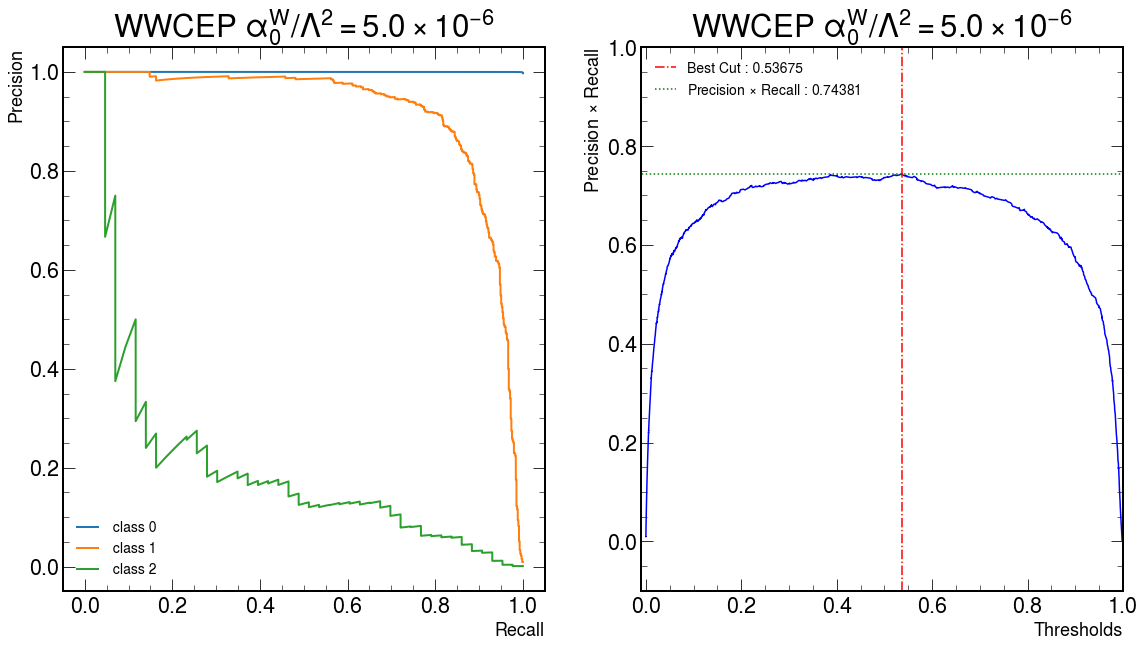

In [38]:
plot_precision_recall_curve(y_test8,predict_proba_LGBM8_binary_logloss_scale_pos_weight, r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 5.0 \times 10^{-6} $', 'Precision_Recal_Anomalo8' )


  Best Cut  0.552450712434034 



'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


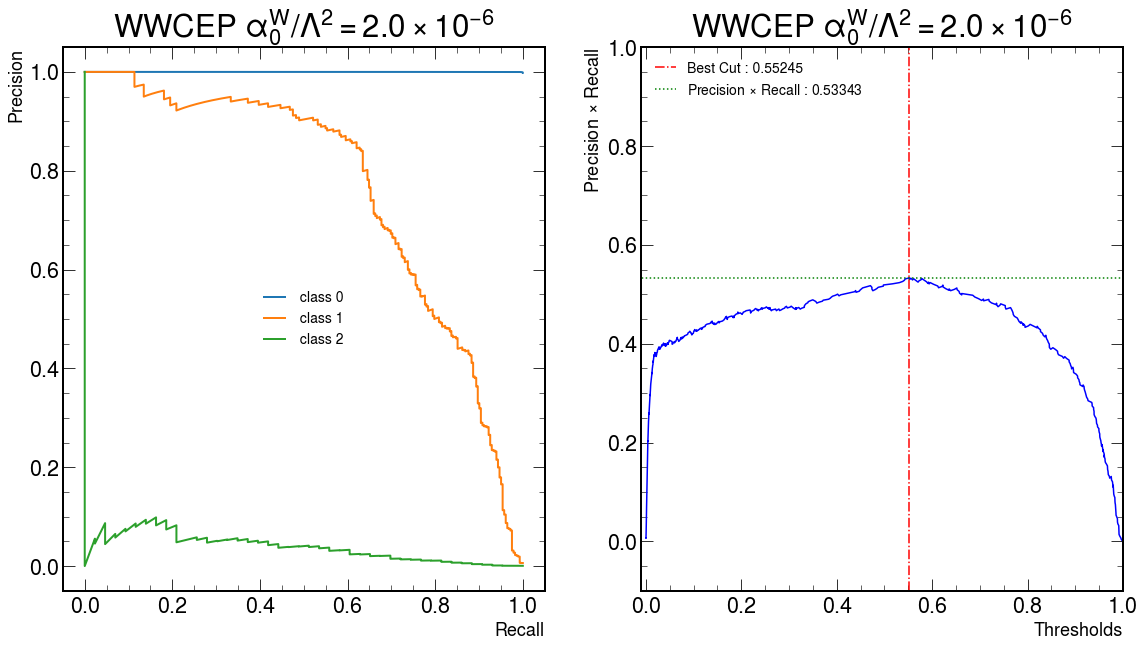

In [39]:
plot_precision_recall_curve(y_test7,predict_proba_LGBM7_binary_logloss_scale_pos_weight, r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 2.0 \times 10^{-6} $', 'Precision_Recal_Anomalo7' )


  Best Cut  0.3086557386677636 



'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


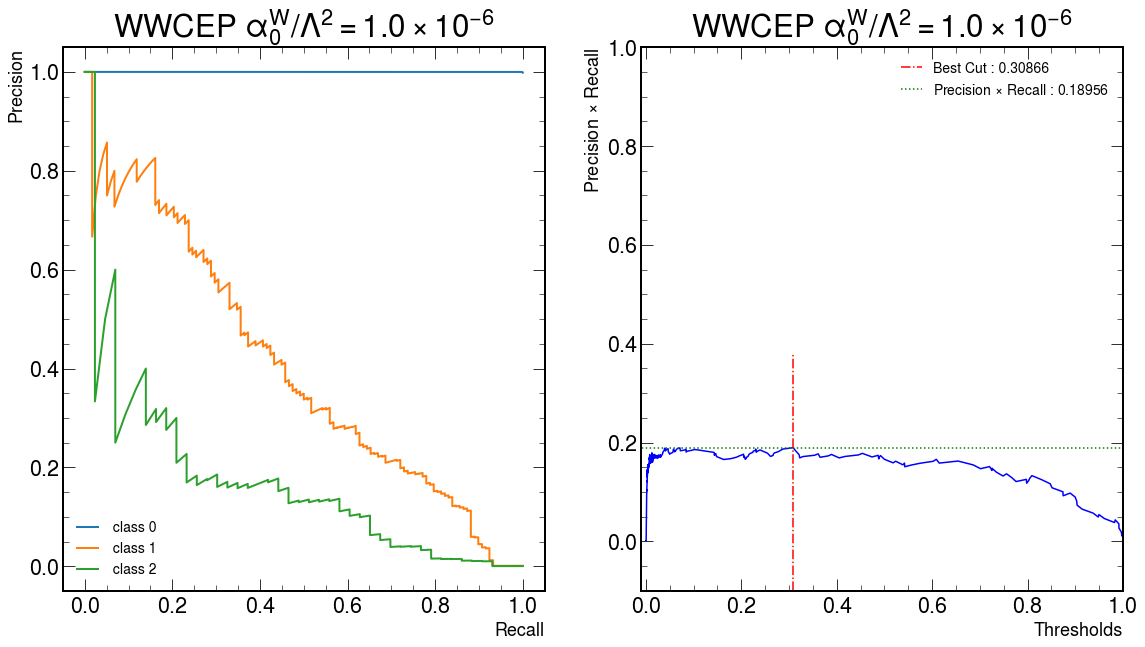

In [40]:
plot_precision_recall_curve(y_test6,predict_proba_LGBM6_binary_logloss_scale_pos_weight, r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 1.0 \times 10^{-6} $', 'Precision_Recal_Anomalo6' )


  Best Cut  0.41088588249436087 



'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


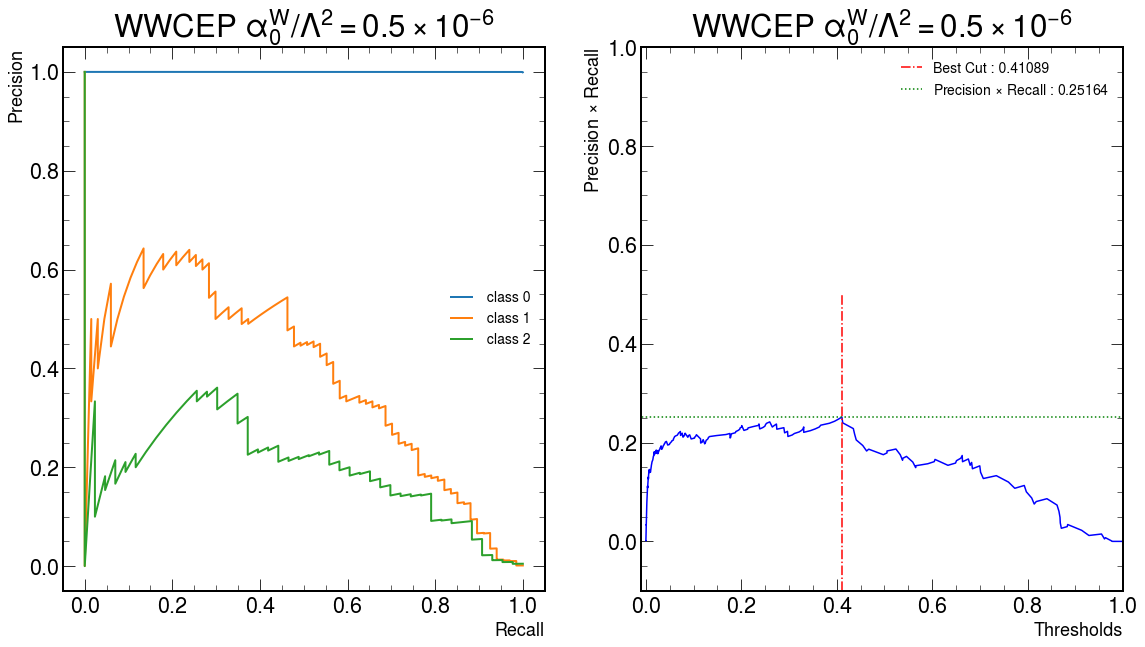

In [41]:
plot_precision_recall_curve(y_test5,predict_proba_LGBM5_binary_logloss_scale_pos_weight, r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 0.5 \times 10^{-6} $', 'Precision_Recal_Anomalo5' )


  Best Cut  0.33307499862150675 



'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


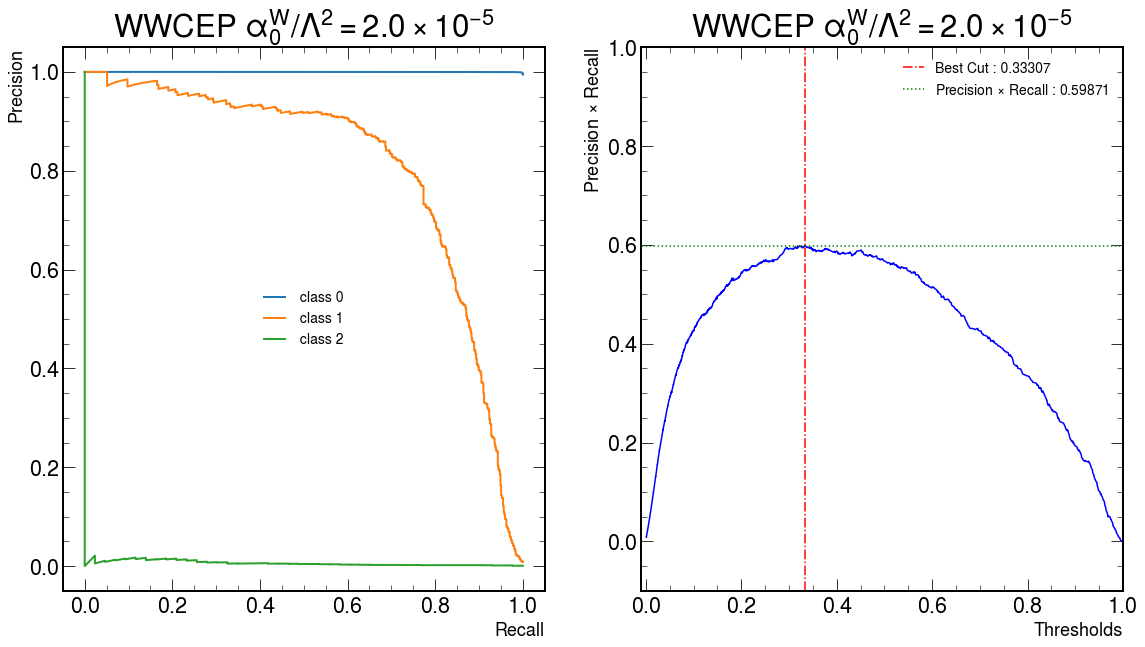

In [42]:
plot_precision_recall_curve(y_test1,predict_proba_LGBM1_binary_logloss_scale_pos_weight, r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 2.0 \times 10^{-5} $', 'Precision_Recal_Anomalo1' )


  Best Cut  0.1681148992117987 



'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


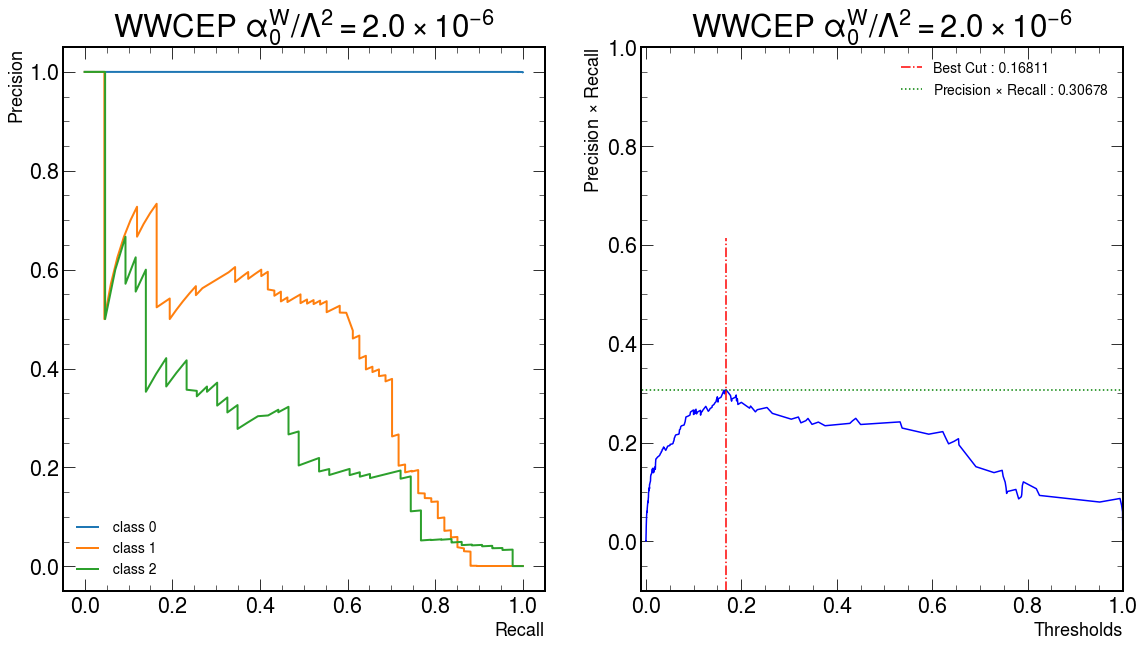

In [43]:
plot_precision_recall_curve(y_test2,predict_proba_LGBM2_binary_logloss_scale_pos_weight, r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 2.0 \times 10^{-6} $', 'Precision_Recal_Anomalo2' )


  Best Cut  0.4651902411624028 



'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


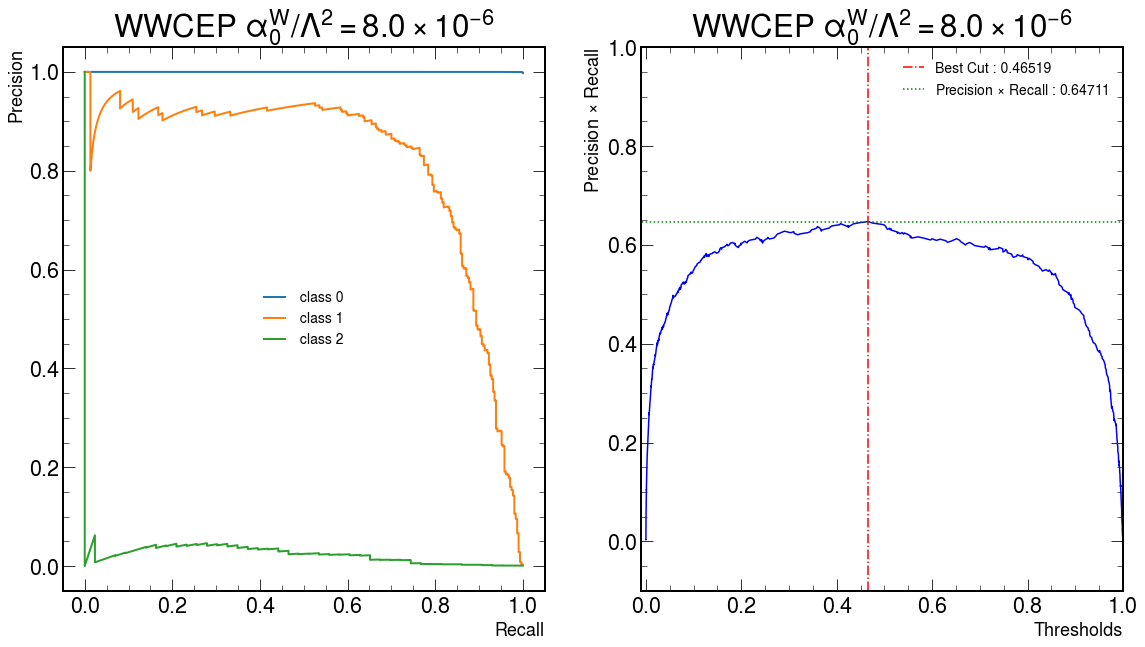

In [44]:
plot_precision_recall_curve(y_test4,predict_proba_LGBM4_binary_logloss_scale_pos_weight, r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 8.0 \times 10^{-6} $', 'Precision_Recal_Anomalo4' )


  Best Cut  0.21875444094286728 



'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


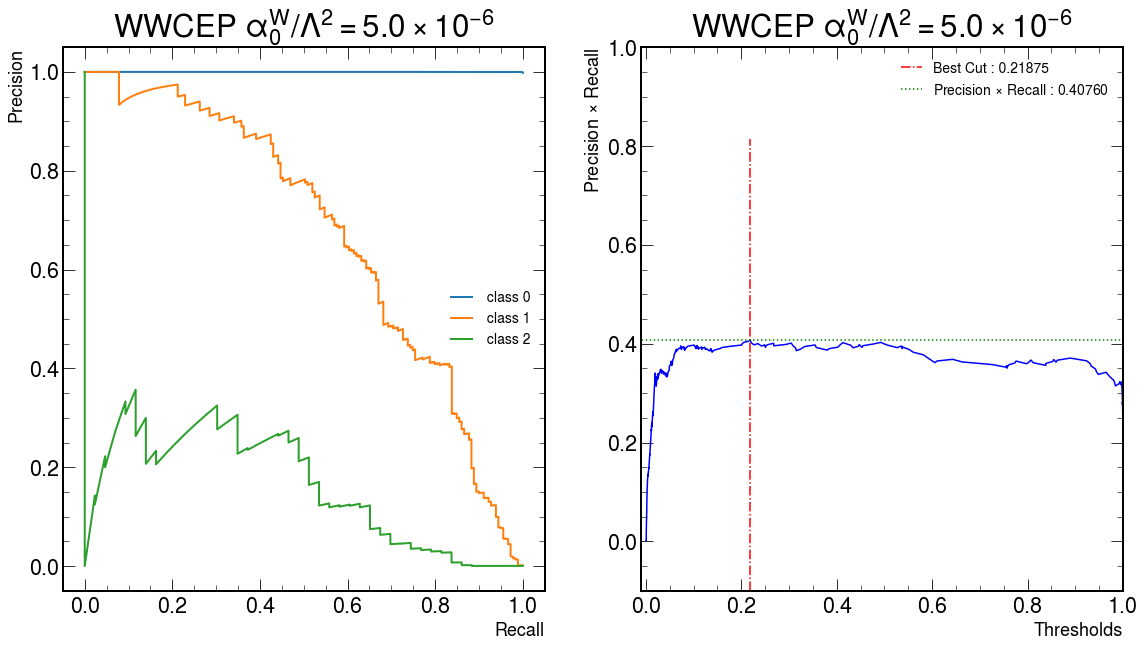

In [45]:
plot_precision_recall_curve(y_test3,predict_proba_LGBM3_binary_logloss_scale_pos_weight, r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 5.0 \times 10^{-6} $', 'Precision_Recal_Anomalo3' )

In [46]:
def plot_probab( bst, predict, label, label_anomalo, weight_back, weight_sig, weight_SM, nome ):
    predict_dados = bst.predict(data_set_dados_multirp)[:,1]
    bins = 25
    plt.figure(figsize = (15,10))

    hbgt_lgb = plt.hist( predict[ label == 0 ][:,1], bins = np.linspace(0,1,bins), alpha=1, histtype = 'bar', color = 'pink', label = 'Background', weights = weight_back/test_size )
    plt.hist( predict[ label == 1 ][:,1], bins = np.linspace(0,1,bins), ls='-', linewidth=2.5, histtype = 'step', label = label_anomalo, weights = weight_sig/test_size, color = 'green' )
    plt.hist( predict[ label == 2 ][:,1], bins = np.linspace(0,1,bins), ls='--', linewidth=2.5, histtype = 'step', label = 'Standar Model', weights = weight_SM/test_size, color = 'blue' )

    uppery_lgb=np.max(hbgt_lgb[0])
    plt.plot( [ best_cut(label,predict),best_cut(label,predict)],[0,uppery_lgb],"-.r", linewidth=2.5,  label='Best cut : {:2.3f}'.format( best_cut(label,predict) ) )
  
    counts_1, bin_edges_1 = np.histogram( predict_dados[ predict_dados < best_cut(label,predict) ] , bins = np.linspace(0,1,bins) )
    errors_1 = np.sqrt( counts_1 )
    bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
    plt.errorbar( bin_centres_1, counts_1, yerr=errors_1, xerr=abs(bin_centres_1[1] - bin_centres_1[2])/2, fmt='.', label = 'Data-2016', color = 'black' )

    n_events_back_after_cut = predict[ label == 0 ][:,1] > best_cut( label, predict ) 
    n_events_signal_after_cut = predict[ label == 1 ][:,1] > best_cut(label,predict )
    n_events_SM_after_cut = predict[ label == 2 ][:,1] > best_cut(label,predict )

    print('Numero de eventos de background depois do corte -->', weight_back[ n_events_back_after_cut ].sum() / test_size )
    print('Numero de eventos de signal depois do corte -->', weight_sig[ n_events_signal_after_cut].sum() / test_size )
    print('Numero de eventos de SM depois do corte -->', weight_SM[ n_events_SM_after_cut ].sum() / test_size )

    plt.text(best_cut( label, predict )+0.05 , 10, 'Signal Region', color = 'red')    
    plt.xlabel( "Probability" )
    plt.ylabel( "Events" )
    plt.title( "Mangueira Plot" )
    plt.legend( loc = "best", fontsize = 16 )
    #plt.yscale( 'log' )
    hep.cms.label( llabel="Preliminary", rlabel=r"$\mathcal{L} = 9.792\;fb^{-1}$", fontsize = 16 )
    plt.savefig( pwd_savefig+nome+'.pdf' )
    plt.ylim(0,90)
    #plt.show()
    #plt.close()

In [47]:
select_columns = ['Mww', 'Pt_W_lep', 'dPhi_Whad_Wlep', 'dPhi_jatos_MET', 'jetAK8_pt','jetAK8_eta', 'jetAK8_prunedMass', 'jetAK8_tau21', 'METPt', 'muon_pt', 'muon_eta', 'ExtraTracks', 'Yww', 'xi1', 'xi2', 'Mx', 'Yx', 'Mww/Mx', 'Yww_Yx']

In [48]:
#argmax() method 
y_pred_1 = [np.argmax(line) for line in predict_proba_LGBM1_binary_logloss_scale_pos_weight > best_cut( y_test1,predict_proba_LGBM1_binary_logloss_scale_pos_weight )]
y_pred_2 = [np.argmax(line) for line in predict_proba_LGBM2_binary_logloss_scale_pos_weight > best_cut( y_test2,predict_proba_LGBM2_binary_logloss_scale_pos_weight )]
y_pred_3 = [np.argmax(line) for line in predict_proba_LGBM3_binary_logloss_scale_pos_weight > best_cut( y_test3,predict_proba_LGBM3_binary_logloss_scale_pos_weight )]
y_pred_4 = [np.argmax(line) for line in predict_proba_LGBM4_binary_logloss_scale_pos_weight > best_cut( y_test4,predict_proba_LGBM4_binary_logloss_scale_pos_weight )]
y_pred_5 = [np.argmax(line) for line in predict_proba_LGBM5_binary_logloss_scale_pos_weight > best_cut( y_test5,predict_proba_LGBM5_binary_logloss_scale_pos_weight )]
y_pred_6 = [np.argmax(line) for line in predict_proba_LGBM6_binary_logloss_scale_pos_weight > best_cut( y_test6,predict_proba_LGBM6_binary_logloss_scale_pos_weight )]
y_pred_7 = [np.argmax(line) for line in predict_proba_LGBM7_binary_logloss_scale_pos_weight > best_cut( y_test7,predict_proba_LGBM7_binary_logloss_scale_pos_weight )]
y_pred_8 = [np.argmax(line) for line in predict_proba_LGBM8_binary_logloss_scale_pos_weight > best_cut( y_test8,predict_proba_LGBM8_binary_logloss_scale_pos_weight )]

from sklearn.metrics import recall_score,classification_report, precision_score

 --------------- Anomalo 4 --------------- 
Numero de eventos de background depois do corte --> 5.576313809753716
Numero de eventos de signal depois do corte --> 3.9010682359881623
Numero de eventos de SM depois do corte --> 0.1639710998222609
Recall Score 0.998734623959508
Precision Score 0.9983384496104858
 --------------- Anomalo 1 --------------- 
Numero de eventos de background depois do corte --> 14.81668541610577
Numero de eventos de signal depois do corte --> 21.732592230042673
Numero de eventos de SM depois do corte --> 0.11903896056259498
Numero de eventos de dados depois do corte --> 17
Recall Score 0.9966702995872201
Precision Score 0.9961220681545274
 --------------- Anomalo 3 --------------- 
Numero de eventos de background depois do corte --> 2.4295174299733877
Numero de eventos de signal depois do corte --> 1.2502419746569102
Numero de eventos de SM depois do corte --> 0.15397338018672566
Numero de eventos de dados depois do corte --> 8
Recall Score 0.9987245667404924
P

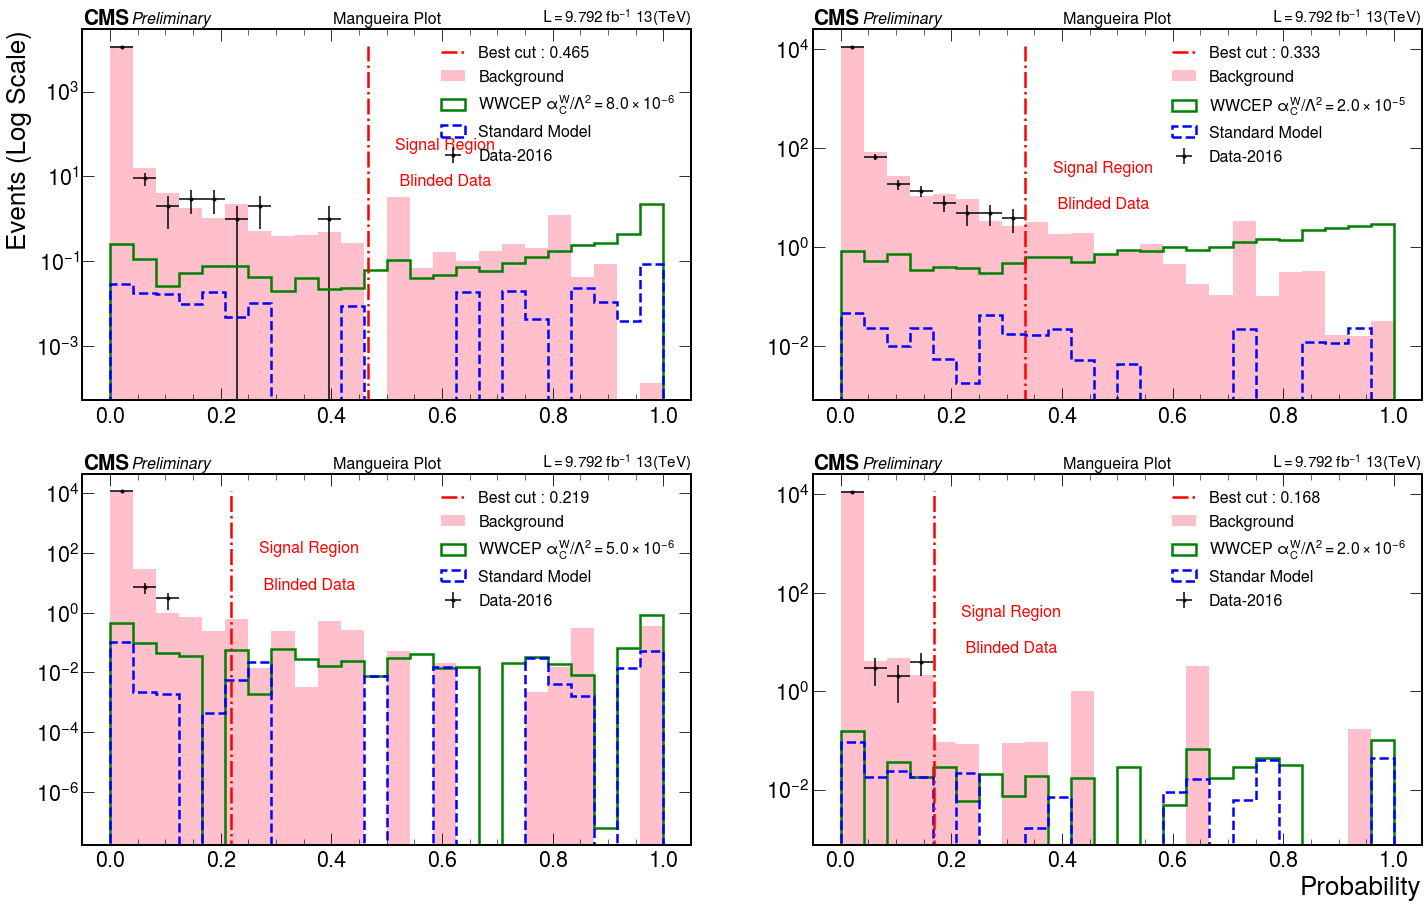

In [49]:
fig, ax = plt.subplots( 2, 2, figsize=(24,15) )
predict_dados = bst4_binary_logloss_scale_pos_weight.predict(data_set_dados_multirp[ select_columns ])[:,1]
bins = 25

hbgt_lgb = ax[0,0].hist( predict_proba_LGBM4_binary_logloss_scale_pos_weight[ y_test4 == 0 ][:,1], bins = np.linspace(0,1,bins), alpha=1, histtype = 'bar', color = 'pink', label = 'Background', weights = DataSet_Test4_weight_backgr/test_size )
ax[0,0].hist( predict_proba_LGBM4_binary_logloss_scale_pos_weight[ y_test4 == 1 ][:,1], bins = np.linspace(0,1,bins), ls='-', linewidth=2.5, histtype = 'step', label = r'WWCEP $\alpha_{C}^{W}/\Lambda^{2}=8.0 \times 10^{-6}$', weights = DataSet_Test4_weight_signal/test_size, color = 'green' )
ax[0,0].hist( predict_proba_LGBM4_binary_logloss_scale_pos_weight[ y_test4 == 2 ][:,1], bins = np.linspace(0,1,bins), ls='--', linewidth=2.5, histtype = 'step', label = 'Standard Model', weights = DataSet_TestSM4_weight_signal/test_size, color = 'blue' )

uppery_lgb=np.max(hbgt_lgb[0])
ax[0,0].plot( [ best_cut(y_test4,predict_proba_LGBM4_binary_logloss_scale_pos_weight),best_cut( y_test4,predict_proba_LGBM4_binary_logloss_scale_pos_weight)],[0,uppery_lgb],"-.r", linewidth=2.5,  label='Best cut : {:2.3f}'.format( best_cut( y_test4, predict_proba_LGBM4_binary_logloss_scale_pos_weight) ) )
  
counts_1, bin_edges_1 = np.histogram( predict_dados[ predict_dados < best_cut( y_test4,predict_proba_LGBM4_binary_logloss_scale_pos_weight ) ] , bins = np.linspace(0,1,bins) )
errors_1 = np.sqrt( counts_1 )
bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
ax[0,0].errorbar( bin_centres_1, counts_1, yerr=errors_1, xerr=abs(bin_centres_1[1] - bin_centres_1[2])/2, fmt='.', label = 'Data-2016', color = 'black' )

n_events_back_after_cut4 = predict_proba_LGBM4_binary_logloss_scale_pos_weight[ y_test4 == 0 ][:,1] > best_cut( y_test4, predict_proba_LGBM4_binary_logloss_scale_pos_weight ) 
n_events_signal_after_cut4 = predict_proba_LGBM4_binary_logloss_scale_pos_weight[ y_test4 == 1 ][:,1] > best_cut(y_test4,predict_proba_LGBM4_binary_logloss_scale_pos_weight )
n_events_SM_after_cut4 = predict_proba_LGBM4_binary_logloss_scale_pos_weight[ y_test4 == 2 ][:,1] > best_cut(y_test4,predict_proba_LGBM4_binary_logloss_scale_pos_weight )
n_eventos_Data_after_cut4 = predict_dados[ predict_dados >= best_cut( y_test4,predict_proba_LGBM4_binary_logloss_scale_pos_weight ) ]

print(" --------------- Anomalo 4 --------------- ")
print('Numero de eventos de background depois do corte -->', DataSet_Test4_weight_backgr[ n_events_back_after_cut4 ].sum() / test_size )
print('Numero de eventos de signal depois do corte -->', DataSet_Test4_weight_signal[ n_events_signal_after_cut4].sum() / test_size )
print('Numero de eventos de SM depois do corte -->', DataSet_TestSM4_weight_signal[ n_events_SM_after_cut4 ].sum() / test_size )
print('Recall Score',recall_score(y_test4,y_pred_4, average = 'weighted') )
print('Precision Score',precision_score(y_test4,y_pred_4, average = 'weighted') )

ax[0,0].text(best_cut( y_test4, predict_proba_LGBM4_binary_logloss_scale_pos_weight )+0.05 , 6, 'Signal Region \n\n Blinded Data', color = 'red', fontsize = 16)    
ax[0,0].set_ylabel( "Events (Log Scale)" )
ax[0,0].set_title( "Mangueira Plot", fontsize = 16  )
ax[0,0].legend( loc = "upper right", fontsize = 16 )
ax[0,0].set_yscale( 'log' )
ax[0,0] = hep.cms.label( llabel="Preliminary", rlabel=r"$\mathcal{L} = 9.792\;fb^{-1}$ 13(TeV)", fontsize = 16, ax = ax[0,0] )


predict_dados = bst1_binary_logloss_scale_pos_weight.predict(data_set_dados_multirp[ select_columns ])[:,1]
bins = 25

hbgt_lgb = ax[0,1].hist( predict_proba_LGBM1_binary_logloss_scale_pos_weight[ y_test1 == 0 ][:,1], bins = np.linspace(0,1,bins), alpha=1, histtype = 'bar', color = 'pink', label = 'Background', weights = DataSet_Test1_weight_backgr/test_size )
ax[0,1].hist( predict_proba_LGBM1_binary_logloss_scale_pos_weight[ y_test1 == 1 ][:,1], bins = np.linspace(0,1,bins), ls='-', linewidth=2.5, histtype = 'step', label = r'WWCEP $\alpha_{C}^{W}/\Lambda^{2}=2.0 \times 10^{-5}$', weights = DataSet_Test1_weight_signal/test_size, color = 'green' )
ax[0,1].hist( predict_proba_LGBM1_binary_logloss_scale_pos_weight[ y_test1 == 2 ][:,1], bins = np.linspace(0,1,bins), ls='--', linewidth=2.5, histtype = 'step', label = 'Standard Model', weights = DataSet_TestSM1_weight_signal/test_size, color = 'blue' )

uppery_lgb=np.max(hbgt_lgb[0])
ax[0,1].plot( [ best_cut(y_test1,predict_proba_LGBM1_binary_logloss_scale_pos_weight),best_cut(y_test1,predict_proba_LGBM1_binary_logloss_scale_pos_weight)],[0,uppery_lgb],"-.r", linewidth=2.5,  label='Best cut : {:2.3f}'.format( best_cut( y_test1, predict_proba_LGBM1_binary_logloss_scale_pos_weight) ) )
  
counts_1, bin_edges_1 = np.histogram( predict_dados[ predict_dados < best_cut( y_test1,predict_proba_LGBM1_binary_logloss_scale_pos_weight ) ] , bins = np.linspace(0,1,bins) )
errors_1 = np.sqrt( counts_1 )
bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
ax[0,1].errorbar( bin_centres_1, counts_1, yerr=errors_1, xerr=abs(bin_centres_1[1] - bin_centres_1[2])/2, fmt='.', label = 'Data-2016', color = 'black' )

n_events_back_after_cut1 = predict_proba_LGBM1_binary_logloss_scale_pos_weight[ y_test1 == 0 ][:,1] > best_cut( y_test1, predict_proba_LGBM1_binary_logloss_scale_pos_weight ) 
n_events_signal_after_cut1 = predict_proba_LGBM1_binary_logloss_scale_pos_weight[ y_test1 == 1 ][:,1] > best_cut(y_test1,predict_proba_LGBM1_binary_logloss_scale_pos_weight )
n_events_SM_after_cut1 = predict_proba_LGBM1_binary_logloss_scale_pos_weight[ y_test1 == 2 ][:,1] > best_cut(y_test1,predict_proba_LGBM1_binary_logloss_scale_pos_weight )
n_eventos_Data_after_cut1 = predict_dados[ predict_dados >= best_cut( y_test1,predict_proba_LGBM1_binary_logloss_scale_pos_weight ) ]

print(' --------------- Anomalo 1 --------------- ')
print('Numero de eventos de background depois do corte -->', DataSet_Test1_weight_backgr[ n_events_back_after_cut1 ].sum() / test_size )
print('Numero de eventos de signal depois do corte -->', DataSet_Test1_weight_signal[ n_events_signal_after_cut1].sum() / test_size )
print('Numero de eventos de SM depois do corte -->', DataSet_TestSM1_weight_signal[ n_events_SM_after_cut1 ].sum() / test_size )
print('Numero de eventos de dados depois do corte -->', len( n_eventos_Data_after_cut1 ) )
print('Recall Score',recall_score(y_test1,y_pred_1, average = 'weighted') )
print('Precision Score',precision_score(y_test1,y_pred_1, average = 'weighted') )

ax[0,1].text(best_cut( y_test1, predict_proba_LGBM1_binary_logloss_scale_pos_weight )+0.05 , 6, 'Signal Region \n\n Blinded Data', color = 'red', fontsize = 16)    
ax[0,1].set_title( "Mangueira Plot", fontsize = 16  )
ax[0,1].legend( loc = "upper right", fontsize = 16 )
ax[0,1].set_yscale( 'log' )
ax[0,1] = hep.cms.label( llabel="Preliminary", rlabel=r"$\mathcal{L} = 9.792\;fb^{-1}$ 13(TeV)", fontsize = 16, ax = ax[0,1] )

predict_dados = bst3_binary_logloss_scale_pos_weight.predict(data_set_dados_multirp[ select_columns ])[:,1]
bins = 25

hbgt_lgb = ax[1,0].hist( predict_proba_LGBM3_binary_logloss_scale_pos_weight[ y_test3 == 0 ][:,1], bins = np.linspace(0,1,bins), alpha=1, histtype = 'bar', color = 'pink', label = 'Background', weights = DataSet_Test3_weight_backgr/test_size )
ax[1,0].hist( predict_proba_LGBM3_binary_logloss_scale_pos_weight[ y_test3 == 1 ][:,1], bins = np.linspace(0,1,bins), ls='-', linewidth=2.5, histtype = 'step', label = r'WWCEP $\alpha_{C}^{W}/\Lambda^{2} = 5.0 \times 10^{-6} $', weights = DataSet_Test3_weight_signal/test_size, color = 'green' )
ax[1,0].hist( predict_proba_LGBM3_binary_logloss_scale_pos_weight[ y_test3 == 2 ][:,1], bins = np.linspace(0,1,bins), ls='--', linewidth=2.5, histtype = 'step', label = 'Standard Model', weights = DataSet_TestSM3_weight_signal/test_size, color = 'blue' )

uppery_lgb=np.max(hbgt_lgb[0])
ax[1,0].plot( [ best_cut(y_test3,predict_proba_LGBM3_binary_logloss_scale_pos_weight),best_cut(y_test3,predict_proba_LGBM3_binary_logloss_scale_pos_weight)],[0,uppery_lgb],"-.r", linewidth=2.5,  label='Best cut : {:2.3f}'.format( best_cut( y_test3, predict_proba_LGBM3_binary_logloss_scale_pos_weight) ) )
  
counts_1, bin_edges_1 = np.histogram( predict_dados[ predict_dados < best_cut( y_test3,predict_proba_LGBM3_binary_logloss_scale_pos_weight ) ] , bins = np.linspace(0,1,bins) )
errors_1 = np.sqrt( counts_1 )
bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
ax[1,0].errorbar( bin_centres_1, counts_1, yerr=errors_1, xerr=abs(bin_centres_1[1] - bin_centres_1[2])/2, fmt='.', label = 'Data-2016', color = 'black' )

n_events_back_after_cut3 = predict_proba_LGBM3_binary_logloss_scale_pos_weight[ y_test3 == 0 ][:,1] >= best_cut( y_test3, predict_proba_LGBM3_binary_logloss_scale_pos_weight ) 
n_events_signal_after_cut3 = predict_proba_LGBM3_binary_logloss_scale_pos_weight[ y_test3 == 1 ][:,1] >= best_cut(y_test3,predict_proba_LGBM3_binary_logloss_scale_pos_weight )
n_events_SM_after_cut3 = predict_proba_LGBM3_binary_logloss_scale_pos_weight[ y_test3 == 2 ][:,1] >= best_cut(y_test3,predict_proba_LGBM3_binary_logloss_scale_pos_weight )
n_eventos_Data_after_cut3 = predict_dados[ predict_dados >= best_cut( y_test3,predict_proba_LGBM3_binary_logloss_scale_pos_weight ) ]

print(' --------------- Anomalo 3 --------------- ')
print('Numero de eventos de background depois do corte -->', DataSet_Test3_weight_backgr[ n_events_back_after_cut3 ].sum() / test_size )
print('Numero de eventos de signal depois do corte -->', DataSet_Test3_weight_signal[ n_events_signal_after_cut3].sum() / test_size )
print('Numero de eventos de SM depois do corte -->', DataSet_TestSM3_weight_signal[ n_events_SM_after_cut3 ].sum() / test_size )
print('Numero de eventos de dados depois do corte -->', len( n_eventos_Data_after_cut3 ) )
print('Recall Score',recall_score(y_test3,y_pred_3, average = 'weighted') )
print('Precision Score',precision_score(y_test3,y_pred_3, average = 'weighted') )

ax[1,0].text(best_cut( y_test3, predict_proba_LGBM3_binary_logloss_scale_pos_weight )+0.05 , 6, 'Signal Region \n\n Blinded Data', color = 'red', fontsize = 16)    
ax[1,0].set_title( "Mangueira Plot", fontsize = 16  )
ax[1,0].legend( loc = "upper right", fontsize = 16 )
ax[1,0].set_yscale( 'log' )
ax[1,0] = hep.cms.label( llabel="Preliminary", rlabel=r"$\mathcal{L} = 9.792\;fb^{-1}$ 13(TeV)", fontsize = 16, ax = ax[1,0] )

predict_dados = bst2_binary_logloss_scale_pos_weight.predict(data_set_dados_multirp[ select_columns ])[:,1]
bins = 25

hbgt_lgb = ax[1,1].hist( predict_proba_LGBM2_binary_logloss_scale_pos_weight[ y_test2 == 0 ][:,1], bins = np.linspace(0,1,bins), alpha=1, histtype = 'bar', color = 'pink', label = 'Background', weights = DataSet_Test2_weight_backgr/test_size )
ax[1,1].hist( predict_proba_LGBM2_binary_logloss_scale_pos_weight[ y_test2 == 1 ][:,1], bins = np.linspace(0,1,bins), ls='-', linewidth=2.5, histtype = 'step', label = r'WWCEP $\alpha_{C}^{W}/\Lambda^{2} = 2.0 \times 10^{-6} $', weights = DataSet_Test2_weight_signal/test_size, color = 'green' )
ax[1,1].hist( predict_proba_LGBM2_binary_logloss_scale_pos_weight[ y_test2 == 2 ][:,1], bins = np.linspace(0,1,bins), ls='--', linewidth=2.5, histtype = 'step', label = 'Standar Model', weights = DataSet_TestSM2_weight_signal/test_size, color = 'blue' )

uppery_lgb=np.max(hbgt_lgb[0])
ax[1,1].plot( [ best_cut(y_test2,predict_proba_LGBM2_binary_logloss_scale_pos_weight),best_cut(y_test2,predict_proba_LGBM2_binary_logloss_scale_pos_weight)],[0,uppery_lgb],"-.r", linewidth=2.5,  label='Best cut : {:2.3f}'.format( best_cut( y_test2, predict_proba_LGBM2_binary_logloss_scale_pos_weight) ) )
  
counts_1, bin_edges_1 = np.histogram( predict_dados[ predict_dados < best_cut( y_test2,predict_proba_LGBM2_binary_logloss_scale_pos_weight ) ] , bins = np.linspace(0,1,bins) )
errors_1 = np.sqrt( counts_1 )
bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
ax[1,1].errorbar( bin_centres_1, counts_1, yerr=errors_1, xerr=abs(bin_centres_1[1] - bin_centres_1[2])/2, fmt='.', label = 'Data-2016', color = 'black' )

n_events_back_after_cut2 = predict_proba_LGBM2_binary_logloss_scale_pos_weight[ y_test2 == 0 ][:,1] > best_cut( y_test2, predict_proba_LGBM2_binary_logloss_scale_pos_weight ) 
n_events_signal_after_cut2 = predict_proba_LGBM2_binary_logloss_scale_pos_weight[ y_test2 == 1 ][:,1] > best_cut(y_test2,predict_proba_LGBM2_binary_logloss_scale_pos_weight )
n_events_SM_after_cut2 = predict_proba_LGBM2_binary_logloss_scale_pos_weight[ y_test2 == 2 ][:,1] > best_cut(y_test2,predict_proba_LGBM2_binary_logloss_scale_pos_weight )
n_eventos_Data_after_cut2 = predict_dados[ predict_dados > best_cut( y_test2,predict_proba_LGBM2_binary_logloss_scale_pos_weight ) ]

print(' --------------- Anomalo 2 --------------- ')
print('Numero de eventos de background depois do corte -->', DataSet_Test2_weight_backgr[ n_events_back_after_cut2 ].sum() / test_size )
print('Numero de eventos de signal depois do corte -->', DataSet_Test2_weight_signal[ n_events_signal_after_cut2 ].sum() / test_size )
print('Numero de eventos de SM depois do corte -->', DataSet_TestSM2_weight_signal[ n_events_SM_after_cut2 ].sum() / test_size )
print('Numero de eventos de dados depois do corte -->', len( n_eventos_Data_after_cut2 ) )
print('Recall Score',recall_score(y_test2,y_pred_2, average = 'weighted') )
print('Precision Score',precision_score(y_test2,y_pred_2, average = 'weighted') )

ax[1,1].set_xlabel( "Probability" )
ax[1,1].set_title( "Mangueira Plot", fontsize = 16  )
ax[1,1].legend( loc = "upper right", fontsize = 16 )
ax[1,1].set_yscale( 'log' )
ax[1,1].text(best_cut( y_test2, predict_proba_LGBM2_binary_logloss_scale_pos_weight )+0.05 , 6, 'Signal Region \n\n Blinded Data', color = 'red', fontsize = 16)    
ax[1,1] = hep.cms.label( llabel="Preliminary", rlabel=r"$\mathcal{L} = 9.792\;fb^{-1}$ 13(TeV)", fontsize = 16, ax = ax[1,1] )

Anomalo 5 
Numero de eventos de background depois do corte --> 0.17844801392667403
Numero de eventos de signal depois do corte --> 0.31875461936714705
Numero de eventos de SM depois do corte --> 0.14850860592860285
Recall Score 0.9992063971292279
Precision Score 0.9989729102264692
Anomalo 6
Numero de eventos de background depois do corte --> 1.5229761842170877
Numero de eventos de signal depois do corte --> 0.41115192967590225
Numero de eventos de SM depois do corte --> 0.08782253997610487
Numero de eventos de dados depois do corte --> 2
Recall Score 0.9987928849188215
Precision Score 0.9988709757170836
Anomalo 7
Numero de eventos de background depois do corte --> 5.534686873801408
Numero de eventos de signal depois do corte --> 2.8886706318856614
Numero de eventos de SM depois do corte --> 0.09845597925046444
Numero de eventos de dados depois do corte --> 3
Recall Score 0.9985707274652799
Precision Score 0.9981049417325599


/home/matheus/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Anomalo 8
Numero de eventos de background depois do corte --> 4.755102311964552
Numero de eventos de signal depois do corte --> 22.212324699462016
Numero de eventos de SM depois do corte --> 0.17515264202857916
Numero de eventos de dados depois do corte --> 6
Recall Score 0.9982754034783653
Precision Score 0.9982208141953859


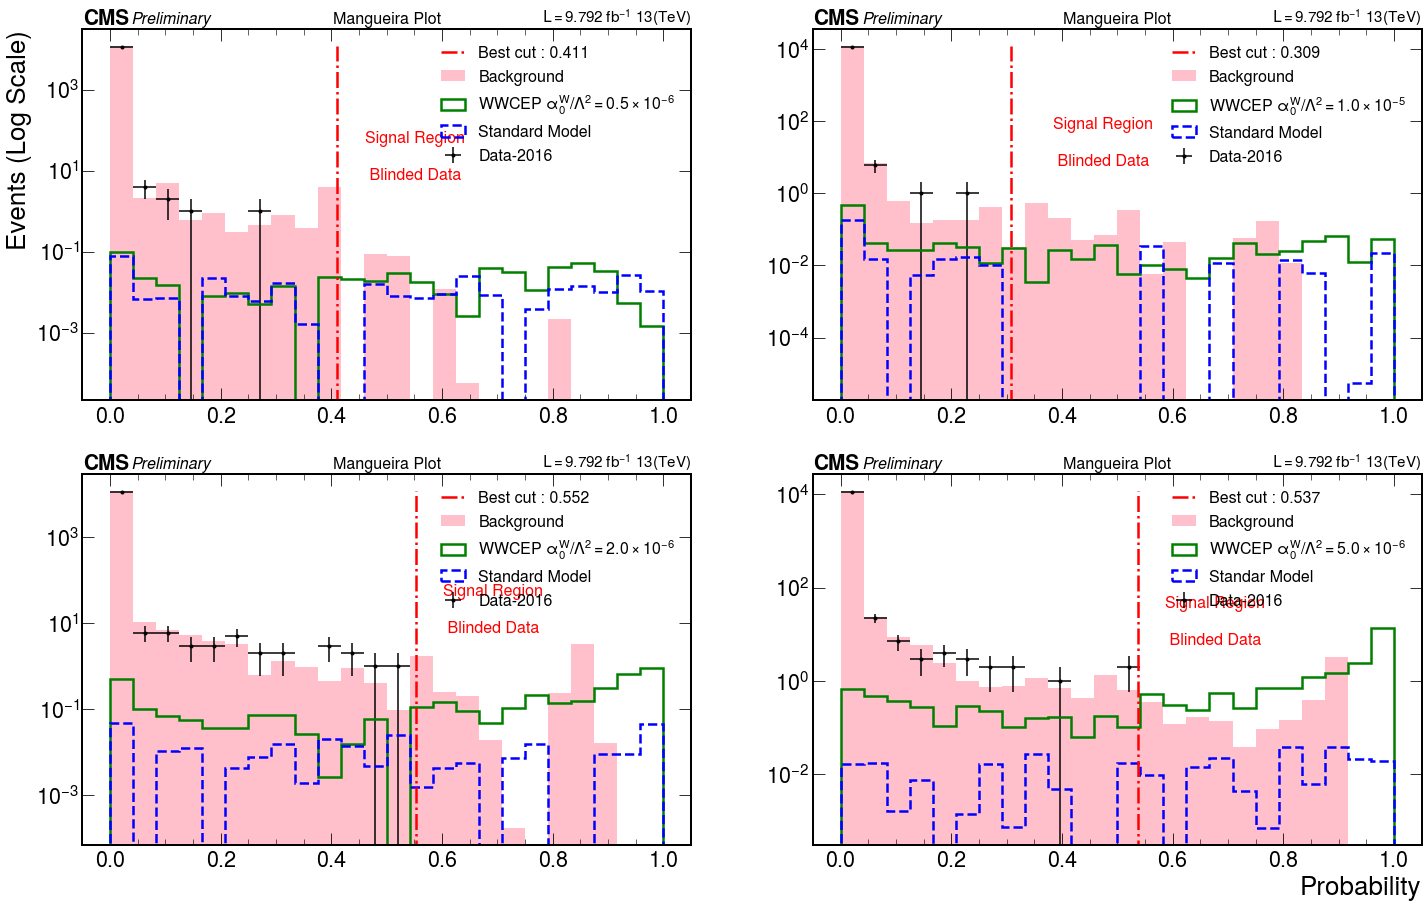

In [50]:
fig, ax = plt.subplots( 2, 2, figsize=(24,15) )
predict_dados = bst5_binary_logloss_scale_pos_weight.predict(data_set_dados_multirp[ select_columns ])[:,1]
bins = 25

hbgt_lgb = ax[0,0].hist( predict_proba_LGBM5_binary_logloss_scale_pos_weight[ y_test5 == 0 ][:,1], bins = np.linspace(0,1,bins), alpha=1, histtype = 'bar', color = 'pink', label = 'Background', weights = DataSet_Test5_weight_backgr/test_size )
ax[0,0].hist( predict_proba_LGBM5_binary_logloss_scale_pos_weight[ y_test5 == 1 ][:,1], bins = np.linspace(0,1,bins), ls='-', linewidth=2.5, histtype = 'step', label = r'WWCEP $\alpha_{0}^{W}/\Lambda^{2}=0.5 \times 10^{-6}$', weights = DataSet_Test5_weight_signal/test_size, color = 'green' )
ax[0,0].hist( predict_proba_LGBM5_binary_logloss_scale_pos_weight[ y_test5 == 2 ][:,1], bins = np.linspace(0,1,bins), ls='--', linewidth=2.5, histtype = 'step', label = 'Standard Model', weights = DataSet_TestSM5_weight_signal/test_size, color = 'blue' )

uppery_lgb=np.max(hbgt_lgb[0])
ax[0,0].plot( [ best_cut(y_test5,predict_proba_LGBM5_binary_logloss_scale_pos_weight),best_cut( y_test5,predict_proba_LGBM5_binary_logloss_scale_pos_weight)],[0,uppery_lgb],"-.r", linewidth=2.5,  label='Best cut : {:2.3f}'.format( best_cut( y_test5, predict_proba_LGBM5_binary_logloss_scale_pos_weight) ) )
  
counts_1, bin_edges_1 = np.histogram( predict_dados[ predict_dados < best_cut( y_test5,predict_proba_LGBM5_binary_logloss_scale_pos_weight ) ] , bins = np.linspace(0,1,bins) )
errors_1 = np.sqrt( counts_1 )
bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
ax[0,0].errorbar( bin_centres_1, counts_1, yerr=errors_1, xerr=abs(bin_centres_1[1] - bin_centres_1[2])/2, fmt='.', label = 'Data-2016', color = 'black' )

n_events_back_after_cut5 = predict_proba_LGBM5_binary_logloss_scale_pos_weight[ y_test5 == 0 ][:,1] > best_cut( y_test5, predict_proba_LGBM5_binary_logloss_scale_pos_weight ) 
n_events_signal_after_cut5 = predict_proba_LGBM5_binary_logloss_scale_pos_weight[ y_test5 == 1 ][:,1] > best_cut(y_test5,predict_proba_LGBM5_binary_logloss_scale_pos_weight )
n_events_SM_after_cut5 = predict_proba_LGBM5_binary_logloss_scale_pos_weight[ y_test5 == 2 ][:,1] > best_cut(y_test5,predict_proba_LGBM5_binary_logloss_scale_pos_weight )
n_eventos_Data_after_cut5 = predict_dados[ predict_dados >= best_cut( y_test5,predict_proba_LGBM5_binary_logloss_scale_pos_weight ) ]

print("Anomalo 5 ")
print('Numero de eventos de background depois do corte -->', DataSet_Test5_weight_backgr[ n_events_back_after_cut5 ].sum() / test_size )
print('Numero de eventos de signal depois do corte -->', DataSet_Test5_weight_signal[ n_events_signal_after_cut5 ].sum() / test_size )
print('Numero de eventos de SM depois do corte -->', DataSet_TestSM5_weight_signal[ n_events_SM_after_cut5 ].sum() / test_size )
print('Recall Score',recall_score(y_test5,y_pred_5, average = 'weighted') )
print('Precision Score',precision_score(y_test5,y_pred_5, average = 'weighted') )

ax[0,0].text(best_cut( y_test5, predict_proba_LGBM5_binary_logloss_scale_pos_weight )+0.05 , 6, 'Signal Region \n\n Blinded Data', color = 'red', fontsize = 16)    
ax[0,0].set_ylabel( "Events (Log Scale)" )
ax[0,0].set_title( "Mangueira Plot", fontsize = 16  )
ax[0,0].legend( loc = "upper right", fontsize = 16 )
ax[0,0].set_yscale( 'log' )
ax[0,0] = hep.cms.label( llabel="Preliminary", rlabel=r"$\mathcal{L} = 9.792\;fb^{-1}$ 13(TeV)", fontsize = 16, ax = ax[0,0] )


predict_dados = bst6_binary_logloss_scale_pos_weight.predict(data_set_dados_multirp[ select_columns ])[:,1]
bins = 25

hbgt_lgb = ax[0,1].hist( predict_proba_LGBM6_binary_logloss_scale_pos_weight[ y_test6 == 0 ][:,1], bins = np.linspace(0,1,bins), alpha=1, histtype = 'bar', color = 'pink', label = 'Background', weights = DataSet_Test6_weight_backgr/test_size )
ax[0,1].hist( predict_proba_LGBM6_binary_logloss_scale_pos_weight[ y_test6 == 1 ][:,1], bins = np.linspace(0,1,bins), ls='-', linewidth=2.5, histtype = 'step', label = r'WWCEP $\alpha_{0}^{W}/\Lambda^{2}=1.0 \times 10^{-5}$', weights = DataSet_Test6_weight_signal/test_size, color = 'green' )
ax[0,1].hist( predict_proba_LGBM6_binary_logloss_scale_pos_weight[ y_test6 == 2 ][:,1], bins = np.linspace(0,1,bins), ls='--', linewidth=2.5, histtype = 'step', label = 'Standard Model', weights = DataSet_TestSM6_weight_signal/test_size, color = 'blue' )

uppery_lgb=np.max(hbgt_lgb[0])
ax[0,1].plot( [ best_cut(y_test6,predict_proba_LGBM6_binary_logloss_scale_pos_weight),best_cut(y_test6,predict_proba_LGBM6_binary_logloss_scale_pos_weight)],[0,uppery_lgb],"-.r", linewidth=2.5,  label='Best cut : {:2.3f}'.format( best_cut( y_test6, predict_proba_LGBM6_binary_logloss_scale_pos_weight) ) )
  
counts_1, bin_edges_1 = np.histogram( predict_dados[ predict_dados < best_cut( y_test6,predict_proba_LGBM6_binary_logloss_scale_pos_weight ) ] , bins = np.linspace(0,1,bins) )
errors_1 = np.sqrt( counts_1 )
bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
ax[0,1].errorbar( bin_centres_1, counts_1, yerr=errors_1, xerr=abs(bin_centres_1[1] - bin_centres_1[2])/2, fmt='.', label = 'Data-2016', color = 'black' )

n_events_back_after_cut6 = predict_proba_LGBM6_binary_logloss_scale_pos_weight[ y_test6 == 0 ][:,1] > best_cut( y_test6, predict_proba_LGBM6_binary_logloss_scale_pos_weight ) 
n_events_signal_after_cut6 = predict_proba_LGBM6_binary_logloss_scale_pos_weight[ y_test6 == 1 ][:,1] > best_cut(y_test6,predict_proba_LGBM6_binary_logloss_scale_pos_weight )
n_events_SM_after_cut6 = predict_proba_LGBM6_binary_logloss_scale_pos_weight[ y_test6 == 2 ][:,1] > best_cut(y_test6,predict_proba_LGBM6_binary_logloss_scale_pos_weight )
n_eventos_Data_after_cut6 = predict_dados[ predict_dados >= best_cut( y_test6,predict_proba_LGBM6_binary_logloss_scale_pos_weight ) ]

print('Anomalo 6')
print('Numero de eventos de background depois do corte -->', DataSet_Test6_weight_backgr[ n_events_back_after_cut6 ].sum() / test_size )
print('Numero de eventos de signal depois do corte -->', DataSet_Test6_weight_signal[ n_events_signal_after_cut6].sum() / test_size )
print('Numero de eventos de SM depois do corte -->', DataSet_TestSM6_weight_signal[ n_events_SM_after_cut6 ].sum() / test_size )
print('Numero de eventos de dados depois do corte -->', len( n_eventos_Data_after_cut6 ) )
print('Recall Score',recall_score(y_test6,y_pred_6, average = 'weighted') )
print('Precision Score',precision_score(y_test6,y_pred_6, average = 'weighted') ) 

ax[0,1].text(best_cut( y_test1, predict_proba_LGBM1_binary_logloss_scale_pos_weight )+0.05 , 6, 'Signal Region \n\n Blinded Data', color = 'red', fontsize = 16)    
ax[0,1].set_title( "Mangueira Plot", fontsize = 16  )
ax[0,1].legend( loc = "upper right", fontsize = 16 )
ax[0,1].set_yscale( 'log' )
ax[0,1] = hep.cms.label( llabel="Preliminary", rlabel=r"$\mathcal{L} = 9.792\;fb^{-1}$ 13(TeV)", fontsize = 16, ax = ax[0,1] )

predict_dados = bst7_binary_logloss_scale_pos_weight.predict(data_set_dados_multirp[ select_columns ])[:,1]
bins = 25

hbgt_lgb = ax[1,0].hist( predict_proba_LGBM7_binary_logloss_scale_pos_weight[ y_test7 == 0 ][:,1], bins = np.linspace(0,1,bins), alpha=1, histtype = 'bar', color = 'pink', label = 'Background', weights = DataSet_Test7_weight_backgr/test_size )
ax[1,0].hist( predict_proba_LGBM7_binary_logloss_scale_pos_weight[ y_test7 == 1 ][:,1], bins = np.linspace(0,1,bins), ls='-', linewidth=2.5, histtype = 'step', label = r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 2.0 \times 10^{-6} $', weights = DataSet_Test7_weight_signal/test_size, color = 'green' )
ax[1,0].hist( predict_proba_LGBM7_binary_logloss_scale_pos_weight[ y_test7 == 2 ][:,1], bins = np.linspace(0,1,bins), ls='--', linewidth=2.5, histtype = 'step', label = 'Standard Model', weights = DataSet_TestSM7_weight_signal/test_size, color = 'blue' )

uppery_lgb=np.max(hbgt_lgb[0])
ax[1,0].plot( [ best_cut(y_test7,predict_proba_LGBM7_binary_logloss_scale_pos_weight),best_cut(y_test7,predict_proba_LGBM7_binary_logloss_scale_pos_weight)],[0,uppery_lgb],"-.r", linewidth=2.5,  label='Best cut : {:2.3f}'.format( best_cut( y_test7, predict_proba_LGBM7_binary_logloss_scale_pos_weight) ) )
  
counts_1, bin_edges_1 = np.histogram( predict_dados[ predict_dados < best_cut( y_test7,predict_proba_LGBM7_binary_logloss_scale_pos_weight ) ] , bins = np.linspace(0,1,bins) )
errors_1 = np.sqrt( counts_1 )
bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
ax[1,0].errorbar( bin_centres_1, counts_1, yerr=errors_1, xerr=abs(bin_centres_1[1] - bin_centres_1[2])/2, fmt='.', label = 'Data-2016', color = 'black' )

n_events_back_after_cut7 = predict_proba_LGBM7_binary_logloss_scale_pos_weight[ y_test7 == 0 ][:,1] >= best_cut( y_test7, predict_proba_LGBM7_binary_logloss_scale_pos_weight ) 
n_events_signal_after_cut7 = predict_proba_LGBM7_binary_logloss_scale_pos_weight[ y_test7 == 1 ][:,1] >= best_cut(y_test7,predict_proba_LGBM7_binary_logloss_scale_pos_weight )
n_events_SM_after_cut7 = predict_proba_LGBM7_binary_logloss_scale_pos_weight[ y_test7 == 2 ][:,1] >= best_cut(y_test7,predict_proba_LGBM7_binary_logloss_scale_pos_weight )
n_eventos_Data_after_cut7 = predict_dados[ predict_dados >= best_cut( y_test7,predict_proba_LGBM7_binary_logloss_scale_pos_weight ) ]

print('Anomalo 7')
print('Numero de eventos de background depois do corte -->', DataSet_Test7_weight_backgr[ n_events_back_after_cut7 ].sum() / test_size )
print('Numero de eventos de signal depois do corte -->', DataSet_Test7_weight_signal[ n_events_signal_after_cut7].sum() / test_size )
print('Numero de eventos de SM depois do corte -->', DataSet_TestSM7_weight_signal[ n_events_SM_after_cut7 ].sum() / test_size )
print('Numero de eventos de dados depois do corte -->', len( n_eventos_Data_after_cut7 ) )
print('Recall Score',recall_score(y_test7,y_pred_7, average = 'weighted') )
print('Precision Score',precision_score(y_test7,y_pred_7, average = 'weighted') )

ax[1,0].text(best_cut( y_test7, predict_proba_LGBM7_binary_logloss_scale_pos_weight )+0.05 , 6, 'Signal Region \n\n Blinded Data', color = 'red', fontsize = 16)    
ax[1,0].set_title( "Mangueira Plot", fontsize = 16  )
ax[1,0].legend( loc = "upper right", fontsize = 16 )
ax[1,0].set_yscale( 'log' )
ax[1,0] = hep.cms.label( llabel="Preliminary", rlabel=r"$\mathcal{L} = 9.792\;fb^{-1}$ 13(TeV)", fontsize = 16, ax = ax[1,0] )

predict_dados = bst8_binary_logloss_scale_pos_weight.predict(data_set_dados_multirp[ select_columns ])[:,1]
bins = 25

hbgt_lgb = ax[1,1].hist( predict_proba_LGBM8_binary_logloss_scale_pos_weight[ y_test8 == 0 ][:,1], bins = np.linspace(0,1,bins), alpha=1, histtype = 'bar', color = 'pink', label = 'Background', weights = DataSet_Test8_weight_backgr/test_size )
ax[1,1].hist( predict_proba_LGBM8_binary_logloss_scale_pos_weight[ y_test8 == 1 ][:,1], bins = np.linspace(0,1,bins), ls='-', linewidth=2.5, histtype = 'step', label = r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 5.0 \times 10^{-6} $', weights = DataSet_Test8_weight_signal/test_size, color = 'green' )
ax[1,1].hist( predict_proba_LGBM8_binary_logloss_scale_pos_weight[ y_test8 == 2 ][:,1], bins = np.linspace(0,1,bins), ls='--', linewidth=2.5, histtype = 'step', label = 'Standar Model', weights = DataSet_TestSM8_weight_signal/test_size, color = 'blue' )

uppery_lgb=np.max(hbgt_lgb[0])
ax[1,1].plot( [ best_cut(y_test8,predict_proba_LGBM8_binary_logloss_scale_pos_weight),best_cut(y_test8,predict_proba_LGBM8_binary_logloss_scale_pos_weight)],[0,uppery_lgb],"-.r", linewidth=2.5,  label='Best cut : {:2.3f}'.format( best_cut( y_test8, predict_proba_LGBM8_binary_logloss_scale_pos_weight) ) )
  
counts_1, bin_edges_1 = np.histogram( predict_dados[ predict_dados < best_cut( y_test8,predict_proba_LGBM8_binary_logloss_scale_pos_weight ) ] , bins = np.linspace(0,1,bins) )
errors_1 = np.sqrt( counts_1 )
bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
ax[1,1].errorbar( bin_centres_1, counts_1, yerr=errors_1, xerr=abs(bin_centres_1[1] - bin_centres_1[2])/2, fmt='.', label = 'Data-2016', color = 'black' )

n_events_back_after_cut8 = predict_proba_LGBM8_binary_logloss_scale_pos_weight[ y_test8 == 0 ][:,1] > best_cut( y_test8, predict_proba_LGBM8_binary_logloss_scale_pos_weight ) 
n_events_signal_after_cut8 = predict_proba_LGBM8_binary_logloss_scale_pos_weight[ y_test8 == 1 ][:,1] > best_cut(y_test8,predict_proba_LGBM8_binary_logloss_scale_pos_weight )
n_events_SM_after_cut8 = predict_proba_LGBM8_binary_logloss_scale_pos_weight[ y_test8 == 2 ][:,1] > best_cut(y_test8,predict_proba_LGBM8_binary_logloss_scale_pos_weight )
n_eventos_Data_after_cut8 = predict_dados[ predict_dados > best_cut( y_test8,predict_proba_LGBM8_binary_logloss_scale_pos_weight ) ]

print('Anomalo 8')
print('Numero de eventos de background depois do corte -->', DataSet_Test8_weight_backgr[ n_events_back_after_cut8 ].sum() / test_size )
print('Numero de eventos de signal depois do corte -->', DataSet_Test8_weight_signal[ n_events_signal_after_cut8 ].sum() / test_size )
print('Numero de eventos de SM depois do corte -->', DataSet_TestSM8_weight_signal[ n_events_SM_after_cut8 ].sum() / test_size )
print('Numero de eventos de dados depois do corte -->', len( n_eventos_Data_after_cut8 ) )
print('Recall Score',recall_score(y_test8,y_pred_8, average = 'weighted') )
print('Precision Score',precision_score(y_test8,y_pred_8, average = 'weighted') )

ax[1,1].set_xlabel( "Probability" )
ax[1,1].set_title( "Mangueira Plot", fontsize = 16  )
ax[1,1].legend( loc = "upper right", fontsize = 16 )
ax[1,1].set_yscale( 'log' )
ax[1,1].text(best_cut( y_test8, predict_proba_LGBM8_binary_logloss_scale_pos_weight )+0.05 , 6, 'Signal Region \n\n Blinded Data', color = 'red', fontsize = 16)    
ax[1,1] = hep.cms.label( llabel="Preliminary", rlabel=r"$\mathcal{L} = 9.792\;fb^{-1}$ 13(TeV)", fontsize = 16, ax = ax[1,1] )

In [51]:
SM['class_predict8'] = ( bst8_binary_logloss_scale_pos_weight.predict( SM[select_columns] )[:,1] > best_cut( y_test8, predict_proba_LGBM8_binary_logloss_scale_pos_weight ) ).astype(int)
SM['class_predict7'] = ( bst7_binary_logloss_scale_pos_weight.predict( SM[select_columns] )[:,1] > best_cut( y_test7, predict_proba_LGBM7_binary_logloss_scale_pos_weight ) ).astype(int)
SM['class_predict6'] = ( bst6_binary_logloss_scale_pos_weight.predict( SM[select_columns] )[:,1] > best_cut( y_test6, predict_proba_LGBM6_binary_logloss_scale_pos_weight ) ).astype(int)
SM['class_predict5'] = ( bst5_binary_logloss_scale_pos_weight.predict( SM[select_columns] )[:,1] > best_cut( y_test5, predict_proba_LGBM5_binary_logloss_scale_pos_weight ) ).astype(int)

SM['class_predict1'] = ( bst1_binary_logloss_scale_pos_weight.predict( SM[select_columns] )[:,1] > best_cut( y_test1, predict_proba_LGBM1_binary_logloss_scale_pos_weight ) ).astype(int)
SM['class_predict4'] = ( bst4_binary_logloss_scale_pos_weight.predict( SM[select_columns] )[:,1] > best_cut( y_test4, predict_proba_LGBM4_binary_logloss_scale_pos_weight ) ).astype(int)
SM['class_predict3'] = ( bst3_binary_logloss_scale_pos_weight.predict( SM[select_columns] )[:,1] > best_cut( y_test3, predict_proba_LGBM3_binary_logloss_scale_pos_weight ) ).astype(int)
SM['class_predict2'] = ( bst2_binary_logloss_scale_pos_weight.predict( SM[select_columns] )[:,1] > best_cut( y_test2, predict_proba_LGBM2_binary_logloss_scale_pos_weight ) ).astype(int)

In [52]:
ANOMALO8['class_predict'] = ( bst8_binary_logloss_scale_pos_weight.predict( ANOMALO8[select_columns] )[:,1] > best_cut( y_test8, predict_proba_LGBM8_binary_logloss_scale_pos_weight ) ).astype(int)
ANOMALO7['class_predict'] = ( bst7_binary_logloss_scale_pos_weight.predict( ANOMALO7[select_columns] )[:,1] > best_cut( y_test7, predict_proba_LGBM7_binary_logloss_scale_pos_weight ) ).astype(int)
ANOMALO1['class_predict'] = ( bst1_binary_logloss_scale_pos_weight.predict( ANOMALO1[select_columns] )[:,1] > best_cut( y_test1, predict_proba_LGBM1_binary_logloss_scale_pos_weight ) ).astype(int)
ANOMALO4['class_predict'] = ( bst4_binary_logloss_scale_pos_weight.predict( ANOMALO4[select_columns] )[:,1] > best_cut( y_test4, predict_proba_LGBM4_binary_logloss_scale_pos_weight ) ).astype(int)
ANOMALO6['class_predict'] = ( bst6_binary_logloss_scale_pos_weight.predict( ANOMALO6[select_columns] )[:,1] > best_cut( y_test6, predict_proba_LGBM6_binary_logloss_scale_pos_weight ) ).astype(int)
ANOMALO5['class_predict'] = ( bst5_binary_logloss_scale_pos_weight.predict( ANOMALO5[select_columns] )[:,1] > best_cut( y_test5, predict_proba_LGBM5_binary_logloss_scale_pos_weight ) ).astype(int)
ANOMALO3['class_predict'] = ( bst3_binary_logloss_scale_pos_weight.predict( ANOMALO3[select_columns] )[:,1] > best_cut( y_test3, predict_proba_LGBM3_binary_logloss_scale_pos_weight ) ).astype(int)
ANOMALO2['class_predict'] = ( bst2_binary_logloss_scale_pos_weight.predict( ANOMALO2[select_columns] )[:,1] > best_cut( y_test2, predict_proba_LGBM2_binary_logloss_scale_pos_weight ) ).astype(int)

In [53]:
# Fazendo um dicionário de tal forma que pudesse alocar todos os anomalos numa mesma estrutura apenas para aqueles classificados como sinal (signal region)
labels_signals = [r'ANOMALO8', r'ANOMALO7', r'ANOMALO1',r'ANOMALO4']
df_signals_protons_multiRP_events_sigreg = {}
df_signals_protons_multiRP_events_sigreg[labels_signals[0]] = ANOMALO8[ ANOMALO8['class_predict'] == 1 ]
df_signals_protons_multiRP_events_sigreg[labels_signals[1]] = ANOMALO7[ ANOMALO7['class_predict'] == 1 ]
df_signals_protons_multiRP_events_sigreg[labels_signals[2]] = ANOMALO1[ ANOMALO1['class_predict'] == 1 ]
df_signals_protons_multiRP_events_sigreg[labels_signals[3]] = ANOMALO4[ ANOMALO4['class_predict'] == 1 ]

In [54]:
DataSet_multiRP_DrellYan['class_predict8'] = ( bst8_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_DrellYan[select_columns] )[:,1] > best_cut( y_test8, predict_proba_LGBM8_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_QCD['class_predict8'] = ( bst8_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_QCD[select_columns] )[:,1] > best_cut( y_test8, predict_proba_LGBM8_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_single_top['class_predict8'] = ( bst8_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_single_top[select_columns] )[:,1] > best_cut( y_test8, predict_proba_LGBM8_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_TTbar['class_predict8'] = ( bst8_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_TTbar[select_columns] )[:,1] > best_cut( y_test8, predict_proba_LGBM8_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_VV_inclusivo['class_predict8'] = ( bst8_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_VV_inclusivo[select_columns] )[:,1] > best_cut( y_test8, predict_proba_LGBM8_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_WJets['class_predict8'] = ( bst8_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_WJets[select_columns] )[:,1] > best_cut( y_test8, predict_proba_LGBM8_binary_logloss_scale_pos_weight ) ).astype(int)
data_set_back_multirp['class_predict8'] = ( bst8_binary_logloss_scale_pos_weight.predict( data_set_back_multirp[select_columns] )[:,1] > best_cut( y_test8, predict_proba_LGBM8_binary_logloss_scale_pos_weight ) ).astype(int)

DataSet_multiRP_DrellYan['class_predict7'] = ( bst7_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_DrellYan[select_columns])[:,1] > best_cut( y_test7, predict_proba_LGBM7_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_QCD['class_predict7'] = ( bst7_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_QCD[select_columns] )[:,1] > best_cut( y_test7, predict_proba_LGBM7_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_single_top['class_predict7'] = ( bst7_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_single_top[select_columns] )[:,1] > best_cut( y_test7, predict_proba_LGBM7_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_TTbar['class_predict7'] = ( bst7_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_TTbar[select_columns] )[:,1] > best_cut( y_test7, predict_proba_LGBM7_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_VV_inclusivo['class_predict7'] = ( bst7_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_VV_inclusivo[select_columns] )[:,1] > best_cut( y_test7, predict_proba_LGBM7_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_WJets['class_predict7'] = ( bst7_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_WJets[select_columns] )[:,1] > best_cut( y_test7, predict_proba_LGBM7_binary_logloss_scale_pos_weight ) ).astype(int)
data_set_back_multirp['class_predict7'] = ( bst7_binary_logloss_scale_pos_weight.predict( data_set_back_multirp[select_columns] )[:,1] > best_cut( y_test7, predict_proba_LGBM7_binary_logloss_scale_pos_weight ) ).astype(int)

DataSet_multiRP_DrellYan['class_predict6'] = ( bst6_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_DrellYan[select_columns])[:,1] > best_cut( y_test6, predict_proba_LGBM6_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_QCD['class_predict6'] = ( bst6_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_QCD[select_columns] )[:,1] > best_cut( y_test6, predict_proba_LGBM6_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_single_top['class_predict6'] = ( bst6_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_single_top[select_columns] )[:,1] > best_cut( y_test6, predict_proba_LGBM6_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_TTbar['class_predict6'] = ( bst6_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_TTbar[select_columns] )[:,1] > best_cut( y_test6, predict_proba_LGBM6_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_VV_inclusivo['class_predict6'] = ( bst6_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_VV_inclusivo[select_columns] )[:,1] > best_cut( y_test6, predict_proba_LGBM6_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_WJets['class_predict6'] = ( bst6_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_WJets[select_columns] )[:,1] > best_cut( y_test6, predict_proba_LGBM6_binary_logloss_scale_pos_weight ) ).astype(int)
data_set_back_multirp['class_predict6'] = ( bst6_binary_logloss_scale_pos_weight.predict( data_set_back_multirp[select_columns] )[:,1] > best_cut( y_test6, predict_proba_LGBM6_binary_logloss_scale_pos_weight ) ).astype(int)

DataSet_multiRP_DrellYan['class_predict5'] = ( bst5_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_DrellYan[select_columns])[:,1] > best_cut( y_test5, predict_proba_LGBM5_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_QCD['class_predict5'] = ( bst5_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_QCD[select_columns] )[:,1] > best_cut( y_test5, predict_proba_LGBM5_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_single_top['class_predict5'] = ( bst5_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_single_top[select_columns] )[:,1] > best_cut( y_test5, predict_proba_LGBM5_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_TTbar['class_predict5'] = ( bst5_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_TTbar[select_columns] )[:,1] > best_cut( y_test5, predict_proba_LGBM5_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_VV_inclusivo['class_predict5'] = ( bst5_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_VV_inclusivo[select_columns] )[:,1] > best_cut( y_test5, predict_proba_LGBM5_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_WJets['class_predict5'] = ( bst5_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_WJets[select_columns] )[:,1] > best_cut( y_test5, predict_proba_LGBM5_binary_logloss_scale_pos_weight ) ).astype(int)
data_set_back_multirp['class_predict5'] = ( bst5_binary_logloss_scale_pos_weight.predict( data_set_back_multirp[select_columns] )[:,1] > best_cut( y_test5, predict_proba_LGBM5_binary_logloss_scale_pos_weight ) ).astype(int)

DataSet_multiRP_DrellYan['class_predict1'] = ( bst1_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_DrellYan[select_columns] )[:,1] > best_cut( y_test1, predict_proba_LGBM1_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_QCD['class_predict1'] = ( bst1_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_QCD[select_columns] )[:,1] > best_cut( y_test1, predict_proba_LGBM1_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_single_top['class_predict1'] = ( bst1_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_single_top[select_columns] )[:,1] > best_cut( y_test1, predict_proba_LGBM1_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_TTbar['class_predict1'] = ( bst1_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_TTbar[select_columns] )[:,1] > best_cut( y_test1, predict_proba_LGBM1_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_VV_inclusivo['class_predict1'] = ( bst1_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_VV_inclusivo[select_columns] )[:,1] > best_cut( y_test1, predict_proba_LGBM1_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_WJets['class_predict1'] = ( bst1_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_WJets[select_columns] )[:,1] > best_cut( y_test1, predict_proba_LGBM1_binary_logloss_scale_pos_weight ) ).astype(int)
data_set_back_multirp['class_predict1'] = ( bst1_binary_logloss_scale_pos_weight.predict( data_set_back_multirp[select_columns]  )[:,1] > best_cut( y_test1, predict_proba_LGBM1_binary_logloss_scale_pos_weight ) ).astype(int)

DataSet_multiRP_DrellYan['class_predict2'] = ( bst2_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_DrellYan[select_columns] )[:,1] > best_cut( y_test2, predict_proba_LGBM2_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_QCD['class_predict2'] = ( bst2_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_QCD[select_columns] )[:,1] > best_cut( y_test2, predict_proba_LGBM2_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_single_top['class_predict2'] = ( bst2_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_single_top[select_columns] )[:,1] > best_cut( y_test2, predict_proba_LGBM2_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_TTbar['class_predict2'] = ( bst2_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_TTbar[select_columns] )[:,1] > best_cut( y_test2, predict_proba_LGBM2_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_VV_inclusivo['class_predict2'] = ( bst2_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_VV_inclusivo[select_columns] )[:,1] > best_cut( y_test2, predict_proba_LGBM2_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_WJets['class_predict2'] = ( bst2_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_WJets[select_columns] )[:,1] > best_cut( y_test2, predict_proba_LGBM2_binary_logloss_scale_pos_weight ) ).astype(int)
data_set_back_multirp['class_predict2'] = ( bst2_binary_logloss_scale_pos_weight.predict( data_set_back_multirp[select_columns] )[:,1] > best_cut( y_test2, predict_proba_LGBM2_binary_logloss_scale_pos_weight ) ).astype(int)

DataSet_multiRP_DrellYan['class_predict3'] = ( bst3_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_DrellYan[select_columns] )[:,1] > best_cut( y_test3, predict_proba_LGBM3_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_QCD['class_predict3'] = ( bst3_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_QCD[select_columns] )[:,1] > best_cut( y_test3, predict_proba_LGBM3_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_single_top['class_predict3'] = ( bst3_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_single_top[select_columns] )[:,1] > best_cut( y_test3, predict_proba_LGBM3_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_TTbar['class_predict3'] = ( bst3_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_TTbar[select_columns] )[:,1] > best_cut( y_test3, predict_proba_LGBM3_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_VV_inclusivo['class_predict3'] = ( bst3_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_VV_inclusivo[select_columns] )[:,1] > best_cut( y_test3, predict_proba_LGBM3_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_WJets['class_predict3'] = ( bst3_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_WJets[select_columns] )[:,1] > best_cut( y_test3, predict_proba_LGBM3_binary_logloss_scale_pos_weight ) ).astype(int)
data_set_back_multirp['class_predict3'] = ( bst3_binary_logloss_scale_pos_weight.predict( data_set_back_multirp[select_columns]  )[:,1] > best_cut( y_test3, predict_proba_LGBM3_binary_logloss_scale_pos_weight ) ).astype(int)

DataSet_multiRP_DrellYan['class_predict4'] = ( bst4_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_DrellYan[select_columns] )[:,1] > best_cut( y_test4, predict_proba_LGBM4_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_QCD['class_predict4'] = ( bst4_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_QCD[select_columns] )[:,1] > best_cut( y_test4, predict_proba_LGBM4_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_single_top['class_predict4'] = ( bst4_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_single_top[select_columns] )[:,1] > best_cut( y_test4, predict_proba_LGBM4_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_TTbar['class_predict4'] = ( bst4_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_TTbar[select_columns] )[:,1] > best_cut( y_test4, predict_proba_LGBM4_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_VV_inclusivo['class_predict4'] = ( bst4_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_VV_inclusivo[select_columns] )[:,1] > best_cut( y_test4, predict_proba_LGBM4_binary_logloss_scale_pos_weight ) ).astype(int)
DataSet_multiRP_WJets['class_predict4'] = ( bst4_binary_logloss_scale_pos_weight.predict( DataSet_multiRP_WJets[select_columns] )[:,1] > best_cut( y_test4, predict_proba_LGBM4_binary_logloss_scale_pos_weight ) ).astype(int)
data_set_back_multirp['class_predict4'] = ( bst4_binary_logloss_scale_pos_weight.predict( data_set_back_multirp[select_columns] )[:,1] > best_cut( y_test4, predict_proba_LGBM4_binary_logloss_scale_pos_weight ) ).astype(int)

In [55]:
data_set_dados_multirp['class_predict8'] = ( bst8_binary_logloss_scale_pos_weight.predict( data_set_dados_multirp[select_columns] )[:,1] > best_cut( y_test8, predict_proba_LGBM8_binary_logloss_scale_pos_weight ) ).astype(int)
data_set_dados_multirp['class_predict7'] = ( bst7_binary_logloss_scale_pos_weight.predict( data_set_dados_multirp[select_columns] )[:,1] > best_cut( y_test7, predict_proba_LGBM7_binary_logloss_scale_pos_weight ) ).astype(int)
data_set_dados_multirp['class_predict1'] = ( bst1_binary_logloss_scale_pos_weight.predict( data_set_dados_multirp[select_columns] )[:,1] > best_cut( y_test1, predict_proba_LGBM1_binary_logloss_scale_pos_weight ) ).astype(int)
data_set_dados_multirp['class_predict4'] = ( bst4_binary_logloss_scale_pos_weight.predict( data_set_dados_multirp[select_columns] )[:,1] > best_cut( y_test4, predict_proba_LGBM4_binary_logloss_scale_pos_weight ) ).astype(int)
data_set_dados_multirp['class_predict5'] = ( bst5_binary_logloss_scale_pos_weight.predict( data_set_dados_multirp[select_columns] )[:,1] > best_cut( y_test5, predict_proba_LGBM5_binary_logloss_scale_pos_weight ) ).astype(int)
data_set_dados_multirp['class_predict2'] = ( bst2_binary_logloss_scale_pos_weight.predict( data_set_dados_multirp[select_columns] )[:,1] > best_cut( y_test2, predict_proba_LGBM2_binary_logloss_scale_pos_weight ) ).astype(int)
data_set_dados_multirp['class_predict6'] = ( bst6_binary_logloss_scale_pos_weight.predict( data_set_dados_multirp[select_columns] )[:,1] > best_cut( y_test6, predict_proba_LGBM6_binary_logloss_scale_pos_weight ) ).astype(int)
data_set_dados_multirp['class_predict3'] = ( bst3_binary_logloss_scale_pos_weight.predict( data_set_dados_multirp[select_columns] )[:,1] > best_cut( y_test3, predict_proba_LGBM3_binary_logloss_scale_pos_weight ) ).astype(int)

# Método ABCD

# Estiamando o Background

A partir das duas variáveis $ \left (  \dfrac{M_{WW}}{M_{PPS}} - 1  \;\; \text{e} \;\; Y_{WW} - Y_{PPS} \right ) $ que têm distribuições não correlacionadas para o background. Um corte em cada uma dessas variáveis terá uma eficiência independente de quaisquer seleções feitas na outra variável. Digamos que dividamos o plano 2D em quatro regiões (A, B, C, D) sendo A a região do sinal final onde os requisitos de seleção das variáveis são aplicados.

Se as seleções são de fato não correlacionadas para o background, então pode-se supor que a proporção de eventos em cada região pode ser relacionada como: 

$$
\dfrac{ N_{A}^{bkg} }{ N_{B}^{bkg} } = \dfrac{ N_{C}^{bkg} }{ N_{D}^{bkg} } \Leftrightarrow N_{A}^{bkg} = N_{B}^{bkg} \cdot \dfrac{N_{C}^{bkg}}{N_{D}^{bkg}}
$$

## Para as amostras de Background

Number of events for background: 11778.777048189935
Number of events (A): 774.0103746799049
Number of events (B): 2720.5961789309517
Number of events (C): 2034.4636470252772
Number of events (D): 6249.706847553803 



'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


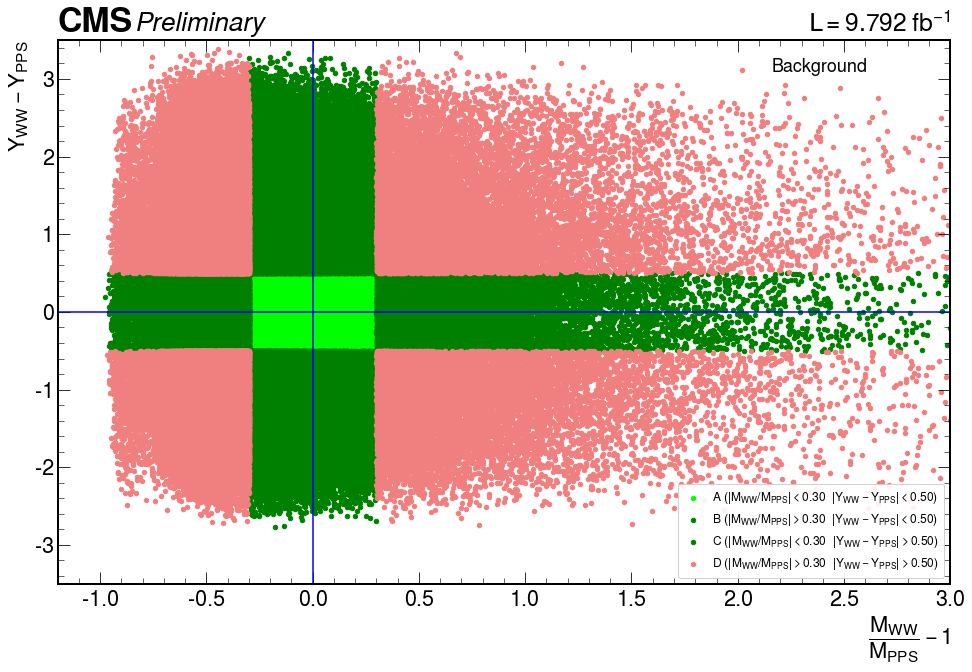

In [56]:
df_protons_multiRP_bkg_events = data_set_back_multirp
df_protons_multiRP_bkg_events['shiftedRatioMWW_MX'] =  df_protons_multiRP_bkg_events[ "Mww/Mx" ] - 1 
df_protons_multiRP_bkg_events['diffYWW_YX'] = df_protons_multiRP_bkg_events['Yww_Yx'] 

cutMww_Mx = 0.30
cutYww_Yx = 0.50 

msk_bkg_cut1 = ( np.abs( df_protons_multiRP_bkg_events[ "shiftedRatioMWW_MX" ] ) <= cutMww_Mx )
msk_bkg_cut2 = ( np.abs( df_protons_multiRP_bkg_events[ "diffYWW_YX" ] ) <= cutYww_Yx )
msk_bkg_A =  msk_bkg_cut1 &  msk_bkg_cut2
msk_bkg_B = ~msk_bkg_cut1 &  msk_bkg_cut2
msk_bkg_C =  msk_bkg_cut1 & ~msk_bkg_cut2
msk_bkg_D = ~msk_bkg_cut1 & ~msk_bkg_cut2

n_events_bkg   = np.sum( df_protons_multiRP_bkg_events[ "weight" ]  )
n_events_bkg_A = np.sum( df_protons_multiRP_bkg_events[ msk_bkg_A ][ "weight" ] )
n_events_bkg_B = np.sum( df_protons_multiRP_bkg_events[ msk_bkg_B ][ "weight" ])
n_events_bkg_C = np.sum( df_protons_multiRP_bkg_events[ msk_bkg_C ][ "weight" ])
n_events_bkg_D = np.sum( df_protons_multiRP_bkg_events[ msk_bkg_D ][ "weight" ])

print ( "Number of events for background: {}".format( n_events_bkg ) )
print ( "Number of events (A): {}".format( n_events_bkg_A ) )
print ( "Number of events (B): {}".format( n_events_bkg_B ) )
print ( "Number of events (C): {}".format( n_events_bkg_C ) )
print ( "Number of events (D): {}".format( n_events_bkg_D ), '\n')

x_min = -1.2
x_max = 3.
y_min = -3.5
y_max =  3.5
x_center = ( x_min + x_max ) / 2.
y_center = ( y_min + y_max ) / 2.

fig = plt.figure( figsize=(16,10) )
plt.plot( (x_min,x_max), (y_center,y_center), color='blue' )
plt.plot( (0,0), (y_min,y_max), color='blue' )
ax = plt.gca()
label_str_ = r"A ($|M_{WW} / M_{PPS}| < 0.30$  $|Y_{WW} - Y_{PPS}| < 0.50$)"
df_protons_multiRP_bkg_events[ msk_bkg_A ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='lime', label=label_str_ )
label_str_ = r"B ($|M_{WW} / M_{PPS}| > 0.30$  $|Y_{WW} - Y_{PPS}| < 0.50$)"
df_protons_multiRP_bkg_events[ msk_bkg_B ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='green', label=label_str_ )
label_str_ = r"C ($|M_{WW} / M_{PPS}| < 0.30$  $|Y_{WW} - Y_{PPS}| > 0.50$)"
df_protons_multiRP_bkg_events[ msk_bkg_C ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='green', label=label_str_ )
label_str_ = r"D ($|M_{WW} / M_{PPS}| > 0.30$  $|Y_{WW} - Y_{PPS}| > 0.50$)"
df_protons_multiRP_bkg_events[ msk_bkg_D ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='lightcoral', label=label_str_ )
plt.legend( loc='best', fontsize=12, framealpha=0.9, frameon=True, fancybox=True )
ax.text( 0.80, 0.95, "Background", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=18 )
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel( r"$\dfrac{M_{WW}}{M_{PPS}} - 1$", fontsize=22 )
plt.ylabel( r"$Y_{WW} - Y_{PPS}$", fontsize=22 )
hep.cms.label(llabel="Preliminary", rlabel=r"$\mathcal{L} = 9.792\;fb^{-1}$" )
plt.savefig( pwd_savefig+'ABCD_multiRP_bkg_events.pdf' )
#plt.show()
#plt.close()

## Para os Dados

Number of events for Data (B): 3029 - Ratio: 22.267178227018128
Number of events for Data (C): 1649 - Ratio: 16.210660754849183
Number of events for Data (D): 6094 - Ratio: 19.501714716059848 



'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


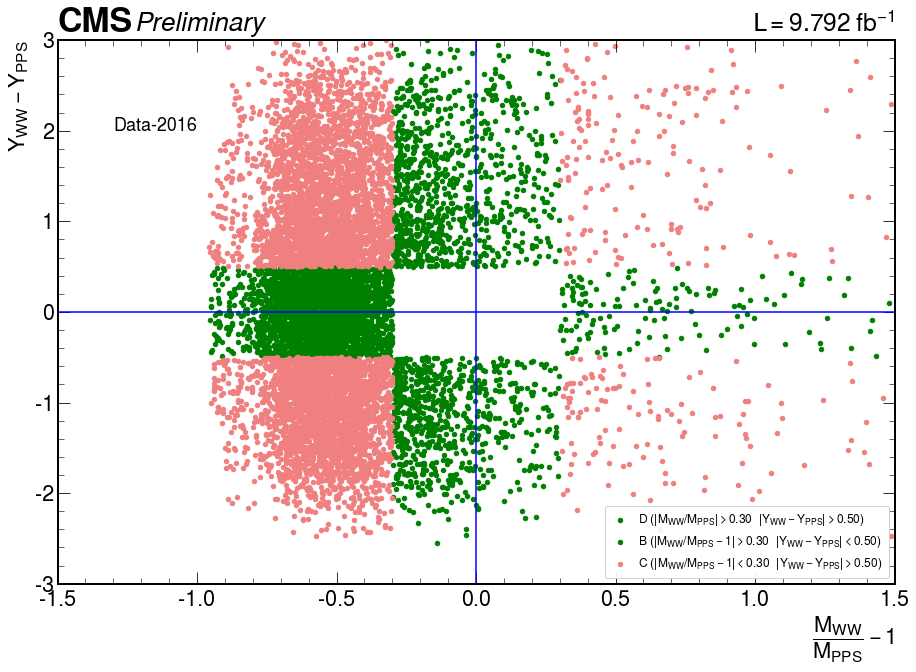

In [57]:
df_protons_multiRP_data_events = data_set_dados_multirp
df_protons_multiRP_data_events['shiftedRatioMWW_MX'] =  df_protons_multiRP_data_events[ "Mww/Mx" ] - 1 
df_protons_multiRP_data_events['diffYWW_YX'] = df_protons_multiRP_data_events['Yww_Yx'] 


msk_data_cut1 = ( np.abs( df_protons_multiRP_data_events[ "shiftedRatioMWW_MX" ] ) <= 0.30 )
msk_data_cut2 = ( np.abs( df_protons_multiRP_data_events[ "diffYWW_YX" ] ) <= 0.50 )
msk_data_A =  msk_data_cut1 &  msk_data_cut2
msk_data_B = ~msk_data_cut1 &  msk_data_cut2
msk_data_C =  msk_data_cut1 & ~msk_data_cut2
msk_data_D = ~msk_data_cut1 & ~msk_data_cut2
msk_data = ~msk_data_A


n_events_data_B = df_protons_multiRP_data_events[ msk_data_B ].shape[0]
n_events_data_C = df_protons_multiRP_data_events[ msk_data_C ].shape[0]
n_events_data_D = df_protons_multiRP_data_events[ msk_data_D ].shape[0]
resample_factor = 20
print ( "Number of events for Data (B): {} - Ratio: {}".format( n_events_data_B, ( n_events_data_B / ( n_events_bkg_B / resample_factor ) ) ) )
print ( "Number of events for Data (C): {} - Ratio: {}".format( n_events_data_C, ( n_events_data_C / ( n_events_bkg_C / resample_factor ) ) ) )
print ( "Number of events for Data (D): {} - Ratio: {}".format( n_events_data_D, ( n_events_data_D / ( n_events_bkg_D / resample_factor ) ) ), '\n' )


x_min = -1.5
x_max =  1.5
y_min = -3.0
y_max =  3.0
x_center = ( x_min + x_max ) / 2.
y_center = ( y_min + y_max ) / 2.

fig = plt.figure( figsize=(15,10) )
plt.plot( (x_min,x_max), (y_center,y_center), color='blue' )
plt.plot( (x_center,x_center), (y_min,y_max), color='blue' )
ax = plt.gca()
df_protons_multiRP_data_events[ msk_data_B ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='green', label = label_str_ )
label_str_ = r"B ($|M_{WW} / M_{PPS} - 1| > 0.30$  $|Y_{WW} - Y_{PPS}| < 0.50$)"
df_protons_multiRP_data_events[ msk_data_C ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='green', label = label_str_ )
label_str_ = r"C ($|M_{WW} / M_{PPS} - 1| < 0.30$  $|Y_{WW} - Y_{PPS}| > 0.50$)"
df_protons_multiRP_data_events[ msk_data_D ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='lightcoral', label = label_str_ )
label_str_ = r"D ($|M_{WW} / M_{PPS} - 1| > 0.30$  $|Y_{WW} - Y_{PPS}| > 0.50$"
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel( r"$\dfrac{M_{WW}}{ M_{PPS} } - 1$", fontsize=22 )
plt.ylabel( r"$Y_{WW} - Y_{PPS}$", fontsize=22 )
plt.legend( loc='best', fontsize=12, framealpha=0.9, frameon=True, fancybox=True )
ax.text( -1.3, 2, "Data-2016", fontsize=18 )
hep.cms.label(llabel="Preliminary", rlabel=r"$\mathcal{L} = 9.792\;fb^{-1}$" )
plt.savefig( pwd_savefig+'ABCD_multiRP_data_events.pdf' )
#plt.show()
#plt.close()

## Para os eventos de background na região de Background após o resultado da classificação do LightGBM com o anômalo 8

Number of events of the background on Signal Region: 11775.723831990195
Number of events (A): 772.1871878241292
Number of events (B): 2720.399542510227
Number of events (C): 2033.6762022033229
Number of events (D): 6249.460899452512 



'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


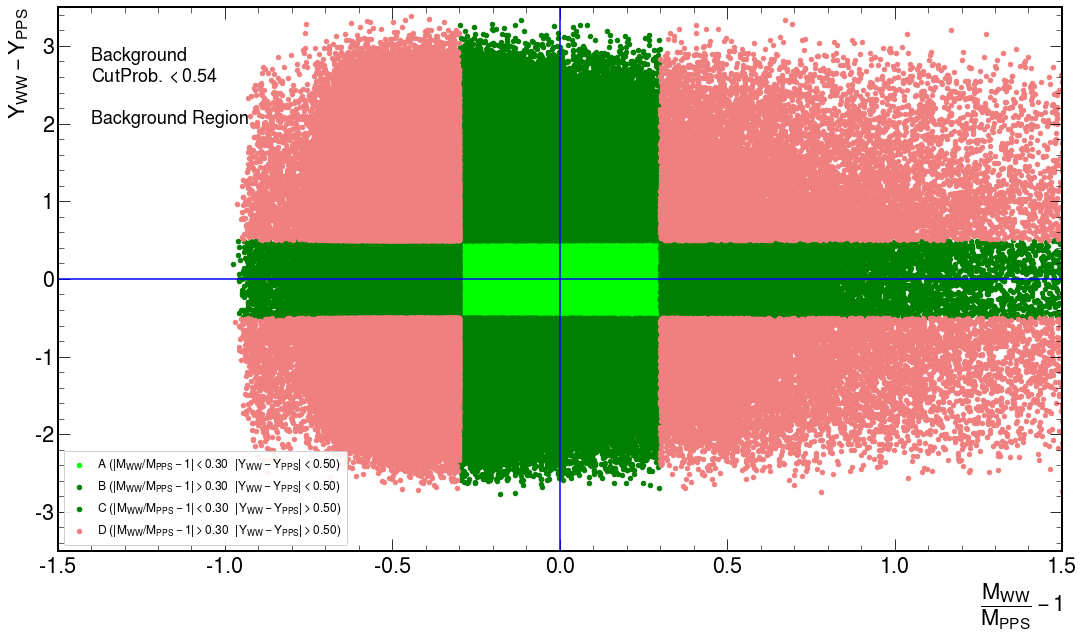

In [58]:
df_protons_multiRP_bkg_events_bkgreg = df_protons_multiRP_bkg_events[ df_protons_multiRP_bkg_events[ 'class_predict8' ] == 0 ]

msk_bkg_cut1 = ( np.abs( df_protons_multiRP_bkg_events_bkgreg[ "shiftedRatioMWW_MX" ] ) <= 0.30 )
msk_bkg_cut2 = ( np.abs( df_protons_multiRP_bkg_events_bkgreg[ "diffYWW_YX" ] ) <= 0.50 )
msk_bkg_A =  msk_bkg_cut1 &  msk_bkg_cut2
msk_bkg_B = ~msk_bkg_cut1 &  msk_bkg_cut2
msk_bkg_C =  msk_bkg_cut1 & ~msk_bkg_cut2
msk_bkg_D = ~msk_bkg_cut1 & ~msk_bkg_cut2

n_events_bkg_bkgreg   = np.sum(df_protons_multiRP_bkg_events_bkgreg[ "weight" ])
n_events_bkg_bkgreg_A = np.sum(df_protons_multiRP_bkg_events_bkgreg[ msk_bkg_A ][ "weight" ] )
n_events_bkg_bkgreg_B = np.sum(df_protons_multiRP_bkg_events_bkgreg[ msk_bkg_B ][ "weight" ]  )
n_events_bkg_bkgreg_C = np.sum(df_protons_multiRP_bkg_events_bkgreg[ msk_bkg_C ][ "weight" ] )
n_events_bkg_bkgreg_D = np.sum(df_protons_multiRP_bkg_events_bkgreg[ msk_bkg_D ][ "weight" ])

print ( "Number of events of the background on Signal Region: {}".format( n_events_bkg_bkgreg ) )
print ( "Number of events (A): {}".format( n_events_bkg_bkgreg_A ) )
print ( "Number of events (B): {}".format( n_events_bkg_bkgreg_B ) )
print ( "Number of events (C): {}".format( n_events_bkg_bkgreg_C ) )
print ( "Number of events (D): {}".format( n_events_bkg_bkgreg_D ),'\n' )

x_min = -1.5
x_max =  1.5
y_min = -3.5
y_max =  3.5
x_center = ( x_min + x_max ) / 2.
y_center = ( y_min + y_max ) / 2.

fig = plt.figure( figsize=(18,10) )
plt.plot( (x_min,x_max), (y_center,y_center), color='blue' )
plt.plot( (x_center,x_center), (y_min,y_max), color='blue' )
ax = plt.gca()
label_str_ = r"A ($|M_{WW} / M_{PPS} - 1| < 0.30$  $|Y_{WW} - Y_{PPS}| < 0.50$)"
df_protons_multiRP_bkg_events_bkgreg[ msk_bkg_A ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='lime', label=label_str_ )
label_str_ = r"B ($|M_{WW} / M_{PPS} - 1| > 0.30$  $|Y_{WW} - Y_{PPS}| < 0.50$)"
df_protons_multiRP_bkg_events_bkgreg[ msk_bkg_B ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='green', label=label_str_ )
label_str_ = r"C ($|M_{WW} / M_{PPS} - 1| < 0.30$  $|Y_{WW} - Y_{PPS}| > 0.50$)"
df_protons_multiRP_bkg_events_bkgreg[ msk_bkg_C ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='green', label=label_str_ )
label_str_ = r"D ($|M_{WW} / M_{PPS} - 1| > 0.30$  $|Y_{WW} - Y_{PPS}| > 0.50$)"
df_protons_multiRP_bkg_events_bkgreg[ msk_bkg_D ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='lightcoral', label=label_str_ )
plt.legend( loc='best', fontsize=12, framealpha=0.9, frameon=True, fancybox=True )
title_str_ = "Background \n$\\rm{{Cut Prob.}} < {:.2f}$\n\nBackground Region".format( best_cut(y_test8,predict_proba_LGBM8_binary_logloss_scale_pos_weight) )
title_str_ = r"{}".format( title_str_ )
ax.text( -1.4, 2, title_str_, fontsize=18 )
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
#plt.title(r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 5.0 \times 10^{-6} $')
plt.xlabel( r"$\dfrac{M_{WW}}{M_{PPS}} - 1$", fontsize=22 )
plt.ylabel( r"$Y_{WW} - Y_{PPS}$", fontsize=22 )
plt.savefig( pwd_savefig+'ABCD_multiRP_bkg_events_BACKGROUND_REGION.pdf' )
#plt.show()
#plt.close()

## Para o Background na Região de Signal 

ANOMALO8
Number of events: 3.053216199745094 +/- 1.2138689458423984
Number of events (A): 1.8231868557757553 +/- 1.1626978831562613
Number of events (B): 0.19663642072391643 +/- 0.08252857221477909
Number of events (C): 0.7874448219543224 +/- 0.322647097919515
Number of events (D): 0.24594810129110017 +/- 0.10343759063700739
0 0


/home/matheus/miniconda3/envs/root_/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


ANOMALO7
Number of events: 2.095230498562863 +/- 1.237196510092428
Number of events (A): 1.1800984069027871 +/- 1.1344661779035277
Number of events (B): 0.13304578755497118 +/- 0.07921186742637348
Number of events (C): 0.6058397931168109 +/- 0.47739763493190146
Number of events (D): 0.17624651098829436 +/- 0.09725571447528467
0 1


/home/matheus/miniconda3/envs/root_/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.
No handles with labels found to put in legend.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


ANOMALO1
Number of events: 13.596029935374043 +/- 1.8736247289868526
Number of events (A): 3.000407978685119 +/- 1.2172210532741983
Number of events (B): 4.768366573965039 +/- 1.0634729032216466
Number of events (C): 1.9591559672902796 +/- 0.41749498697640147
Number of events (D): 3.8680994154336052 +/- 0.8506267409974866
1 0


/home/matheus/miniconda3/envs/root_/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


ANOMALO4
Number of events: 1.9569891758831592 +/- 1.2095558151145076
Number of events (A): 1.175478015999188 +/- 1.133965021849225
Number of events (B): 0.02493668033693173 +/- 0.020353928096283953
Number of events (C): 0.21629328062862946 +/- 0.08634815478533418
Number of events (D): 0.54028119891841 +/- 0.4114344575701297
1 1


/home/matheus/miniconda3/envs/root_/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


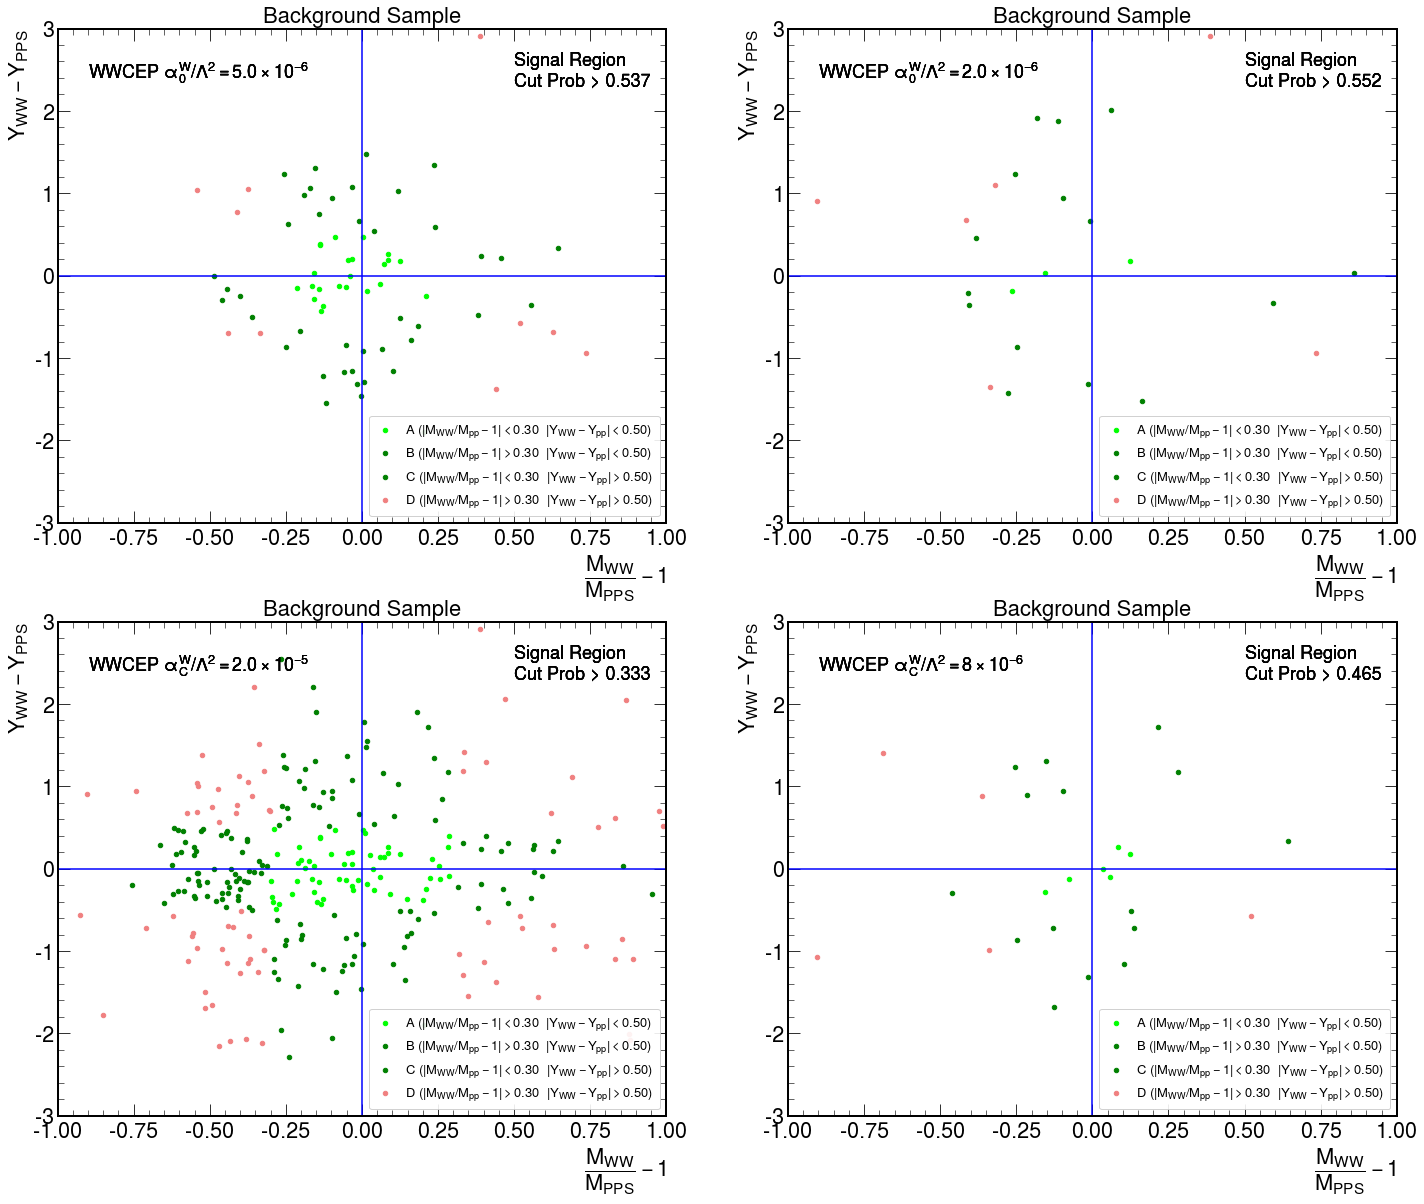

In [59]:
labels_signals = [r'ANOMALO8', r'ANOMALO7', r'ANOMALO1',r'ANOMALO4']
df_protons_multiRP_bkg_events_sigreg = {}
df_protons_multiRP_bkg_events_sigreg[labels_signals[0]] = data_set_back_multirp[ data_set_back_multirp['class_predict8'] == 1 ]
df_protons_multiRP_bkg_events_sigreg[labels_signals[1]] = data_set_back_multirp[ data_set_back_multirp['class_predict7'] == 1 ]
df_protons_multiRP_bkg_events_sigreg[labels_signals[2]] = data_set_back_multirp[ data_set_back_multirp['class_predict1'] == 1 ]
df_protons_multiRP_bkg_events_sigreg[labels_signals[3]] = data_set_back_multirp[ data_set_back_multirp['class_predict4'] == 1 ]

labels_samples = [
    r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 5.0 \times 10^{-6} $',
    r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 2.0 \times 10^{-6} $',
    r'WWCEP $\alpha_{C}^{W}/\Lambda^{2}=2.0 \times 10^{-5}$',
    r'WWCEP $\alpha_{C}^{W}/\Lambda^{2}=8 \times 10^{-6}$' ]

nrows_ = ( int( len(labels_signals)/2 ) + 1 if ( len(labels_signals) % 2 ) > 0 else  int( len(labels_signals)/2 ) )
fig, axes = plt.subplots( nrows_, 2, figsize=(24,nrows_*10) )

row_ = 0
col_ = 0
for label_ in labels_signals:
    print ( label_ )
    
    df_protons_multiRP_bkg_events_sigreg[ label_ ]['shiftedRatioMWW_MX'] = df_protons_multiRP_bkg_events_sigreg[ label_ ]['Mww/Mx'] - 1
    msk_sig_cut1 = ( np.abs( df_protons_multiRP_bkg_events_sigreg[ label_ ][ "shiftedRatioMWW_MX" ] ) <= 0.30 )
    msk_sig_cut2 = ( np.abs( df_protons_multiRP_bkg_events_sigreg[ label_ ][ "Yww_Yx" ] ) <= 0.50 )
    msk_sig_A =  msk_sig_cut1 &  msk_sig_cut2
    msk_sig_B = ~msk_sig_cut1 &  msk_sig_cut2
    msk_sig_C =  msk_sig_cut1 & ~msk_sig_cut2
    msk_sig_D = ~msk_sig_cut1 & ~msk_sig_cut2

    n_events_sig   = np.sum( df_protons_multiRP_bkg_events_sigreg[ label_ ][ "weight" ] )
    err_n_events_sig = np.sqrt( np.sum(np.square(  df_protons_multiRP_bkg_events_sigreg[ label_ ][ "weight" ] ) ) )
    n_events_sig_A = np.sum( df_protons_multiRP_bkg_events_sigreg[ label_ ][ msk_sig_A ][ "weight" ] )
    err_n_events_sig_A = np.sqrt( np.sum(np.square( df_protons_multiRP_bkg_events_sigreg[ label_ ][ msk_sig_A ][ "weight" ]  ) ) )
    n_events_sig_B = np.sum( df_protons_multiRP_bkg_events_sigreg[ label_ ][ msk_sig_B ][ "weight" ] )
    err_n_events_sig_B = np.sqrt( np.sum(np.square(  df_protons_multiRP_bkg_events_sigreg[ label_ ][ msk_sig_B ][ "weight" ] ) ) )
    n_events_sig_C = np.sum(  df_protons_multiRP_bkg_events_sigreg[ label_ ][ msk_sig_C ][ "weight" ] )
    err_n_events_sig_C = np.sqrt( np.sum(np.square( df_protons_multiRP_bkg_events_sigreg[ label_ ][ msk_sig_C ][ "weight" ] ) ) )
    n_events_sig_D = np.sum( df_protons_multiRP_bkg_events_sigreg[ label_ ][ msk_sig_D ][ "weight" ] )
    err_n_events_sig_D = np.sqrt( np.sum(np.square( df_protons_multiRP_bkg_events_sigreg[ label_ ][ msk_sig_D ][ "weight" ] ) ) )

    print ( "Number of events: {} +/- {}".format( n_events_sig, err_n_events_sig ) )
    print ( "Number of events (A): {} +/- {}".format( n_events_sig_A, err_n_events_sig_A ) )
    print ( "Number of events (B): {} +/- {}".format( n_events_sig_B, err_n_events_sig_B ) )
    print ( "Number of events (C): {} +/- {}".format( n_events_sig_C, err_n_events_sig_C ) )
    print ( "Number of events (D): {} +/- {}".format( n_events_sig_D, err_n_events_sig_D ) )

    x_min = -1.0
    x_max =  1.0
    y_min = -3.0
    y_max =  3.0
    x_center = ( x_min + x_max ) / 2.
    y_center = ( y_min + y_max ) / 2.

    print ( row_, col_ )
    axes[ row_, col_ ].plot( (x_min,x_max), (y_center,y_center), color='blue' )
    axes[ row_, col_ ].plot( (x_center,x_center), (y_min,y_max), color='blue' )
    if np.sum( msk_sig_A ) > 0:
        label_str_ = r"A ($|M_{WW} / M_{pp} - 1| < 0.30$  $|Y_{WW} - Y_{pp}| < 0.50$)"
        df_protons_multiRP_bkg_events_sigreg[ label_ ][ msk_sig_A ].plot( "shiftedRatioMWW_MX", "Yww_Yx", 'scatter', ax=axes[ row_, col_ ], color='lime', label = label_str_ )
    if np.sum( msk_sig_B ) > 0:
        label_str_ = r"B ($|M_{WW} / M_{pp} - 1| > 0.30$  $|Y_{WW} - Y_{pp}| < 0.50$)"
        df_protons_multiRP_bkg_events_sigreg[ label_ ][ msk_sig_B ].plot( "shiftedRatioMWW_MX", "Yww_Yx", 'scatter', ax=axes[ row_, col_ ], color='green', label = label_str_ )
    if np.sum( msk_sig_C ) > 0:
        label_str_ = r"C ($|M_{WW} / M_{pp} - 1| < 0.30$  $|Y_{WW} - Y_{pp}| > 0.50$)"
        df_protons_multiRP_bkg_events_sigreg[ label_ ][ msk_sig_C ].plot( "shiftedRatioMWW_MX", "Yww_Yx", 'scatter', ax=axes[ row_, col_ ], color='green', label = label_str_ )
    if np.sum( msk_sig_D ) > 0:
        label_str_ = r"D ($|M_{WW} / M_{pp} - 1| > 0.30$  $|Y_{WW} - Y_{pp}| > 0.50$)"
        df_protons_multiRP_bkg_events_sigreg[ label_ ][ msk_sig_D ].plot( "shiftedRatioMWW_MX", "Yww_Yx", 'scatter', ax=axes[ row_, col_ ], color='lightcoral', label = label_str_ )
    #title_str_ = "{}\n$\\rm{{Prob.}} > {:.2f}$".format( labels_samples[ label_ ], prob_cut )
    #title_str_ = r"{}".format( title_str_ )
    #axes[ row_, col_ ].text( 0.70, 0.92, title_str_, horizontalalignment='left', verticalalignment='center', transform=axes[ row_, col_ ].transAxes, fontsize=18 )
    axes[ row_, col_ ].set_xlim(x_min, x_max)
    axes[ row_, col_ ].set_ylim(y_min, y_max)
    axes[ row_, col_ ].set_xlabel( r"$\dfrac{M_{WW}}{M_{PPS}} - 1$", fontsize=22 )
    axes[ row_, col_ ].set_ylabel( r"$Y_{WW} - Y_{PPS}$", fontsize=22 )
    axes[ row_, col_ ].set_title( "Background Sample", fontsize=22 )
    axes[ 0 , 0].text( -0.9, 2.4 , labels_samples[0], fontsize=18)
    axes[ 0 , 0].text( 0.5, 2.3 , 'Signal Region\nCut Prob > {:2.3f}'.format(best_cut(y_test8,predict_proba_LGBM8_binary_logloss_scale_pos_weight)), fontsize=18) 
    axes[ 0 , 1].text( -0.9, 2.4 , labels_samples[1], fontsize=18)
    axes[ 0 , 1].text( 0.5, 2.3 , 'Signal Region\nCut Prob > {:2.3f}'.format(best_cut(y_test7,predict_proba_LGBM7_binary_logloss_scale_pos_weight)), fontsize=18)
    axes[ 1 , 0].text( -0.9, 2.4 , labels_samples[2], fontsize=18)
    axes[ 1 , 0].text( 0.5, 2.3 , 'Signal Region\nCut Prob > {:2.3f}'.format(best_cut(y_test1,predict_proba_LGBM1_binary_logloss_scale_pos_weight)), fontsize=18)
    axes[ 1 , 1].text( -0.9, 2.4 , labels_samples[3], fontsize=18)
    axes[ 1 , 1].text( 0.5, 2.3 , 'Signal Region\nCut Prob > {:2.3f}'.format(best_cut(y_test4,predict_proba_LGBM4_binary_logloss_scale_pos_weight)), fontsize=18)
    axes[ 0 , 0].legend(loc='lower right', fontsize=13,framealpha=0.9, frameon=True, fancybox=True)
    axes[ 0 , 1].legend(loc='lower right', fontsize=13,framealpha=0.9, frameon=True, fancybox=True)
    axes[ 1 , 0].legend(loc='lower right', fontsize=13,framealpha=0.9, frameon=True, fancybox=True)
    axes[ 1 , 1].legend(loc='lower right', fontsize=13,framealpha=0.9, frameon=True, fancybox=True)
    plt.savefig(pwd_savefig+'multiRP_events_sigreg_BACKGROUND_SignalRegion.pdf')
    col_ += 1
    if col_ >= 2:
        row_ += 1
        col_  = 0

## Para o Signal na Região de Signal

ANOMALO8
Number of events: 22.41569506514322 +/- 0.6532201738818978
Number of events (A): 11.759243286981892 +/- 0.470177817163117
Number of events (B): 0.5503580226312108 +/- 0.11535095985772474
Number of events (C): 9.80776312143578 +/- 0.4310823611295308
Number of events (D): 0.29833063409433963 +/- 0.0805702786200576
0 0


/home/matheus/miniconda3/envs/root_/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


ANOMALO7
Number of events: 2.9853359230589347 +/- 0.1457073707481087
Number of events (A): 1.5655729426863965 +/- 0.10424669461146156
Number of events (B): 0.09745981699125653 +/- 0.02680832541969473
Number of events (C): 1.286452798883003 +/- 0.09702548616793985
Number of events (D): 0.035850364498279226 +/- 0.01518661499407083
0 1


/home/matheus/miniconda3/envs/root_/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
No handles with labels found to put in legend.
No handles with labels found to put in legend.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


ANOMALO1
Number of events: 22.147558446616515 +/- 0.6680592561589107
Number of events (A): 13.311481998651637 +/- 0.5129562957904368
Number of events (B): 0.6345132702617218 +/- 0.12380435554186343
Number of events (C): 8.094047324528395 +/- 0.407426819267412
Number of events (D): 0.10751585317476059 +/- 0.04306828112491291
1 0


/home/matheus/miniconda3/envs/root_/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
No handles with labels found to put in legend.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


ANOMALO4
Number of events: 4.220792395190817 +/- 0.17650933354457124
Number of events (A): 2.275022168524666 +/- 0.1290649507027336
Number of events (B): 0.09646055458772637 +/- 0.029555779378118603
Number of events (C): 1.7731832971163641 +/- 0.11430225365303465
Number of events (D): 0.07612637496206073 +/- 0.0236481298127136
1 1


/home/matheus/miniconda3/envs/root_/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


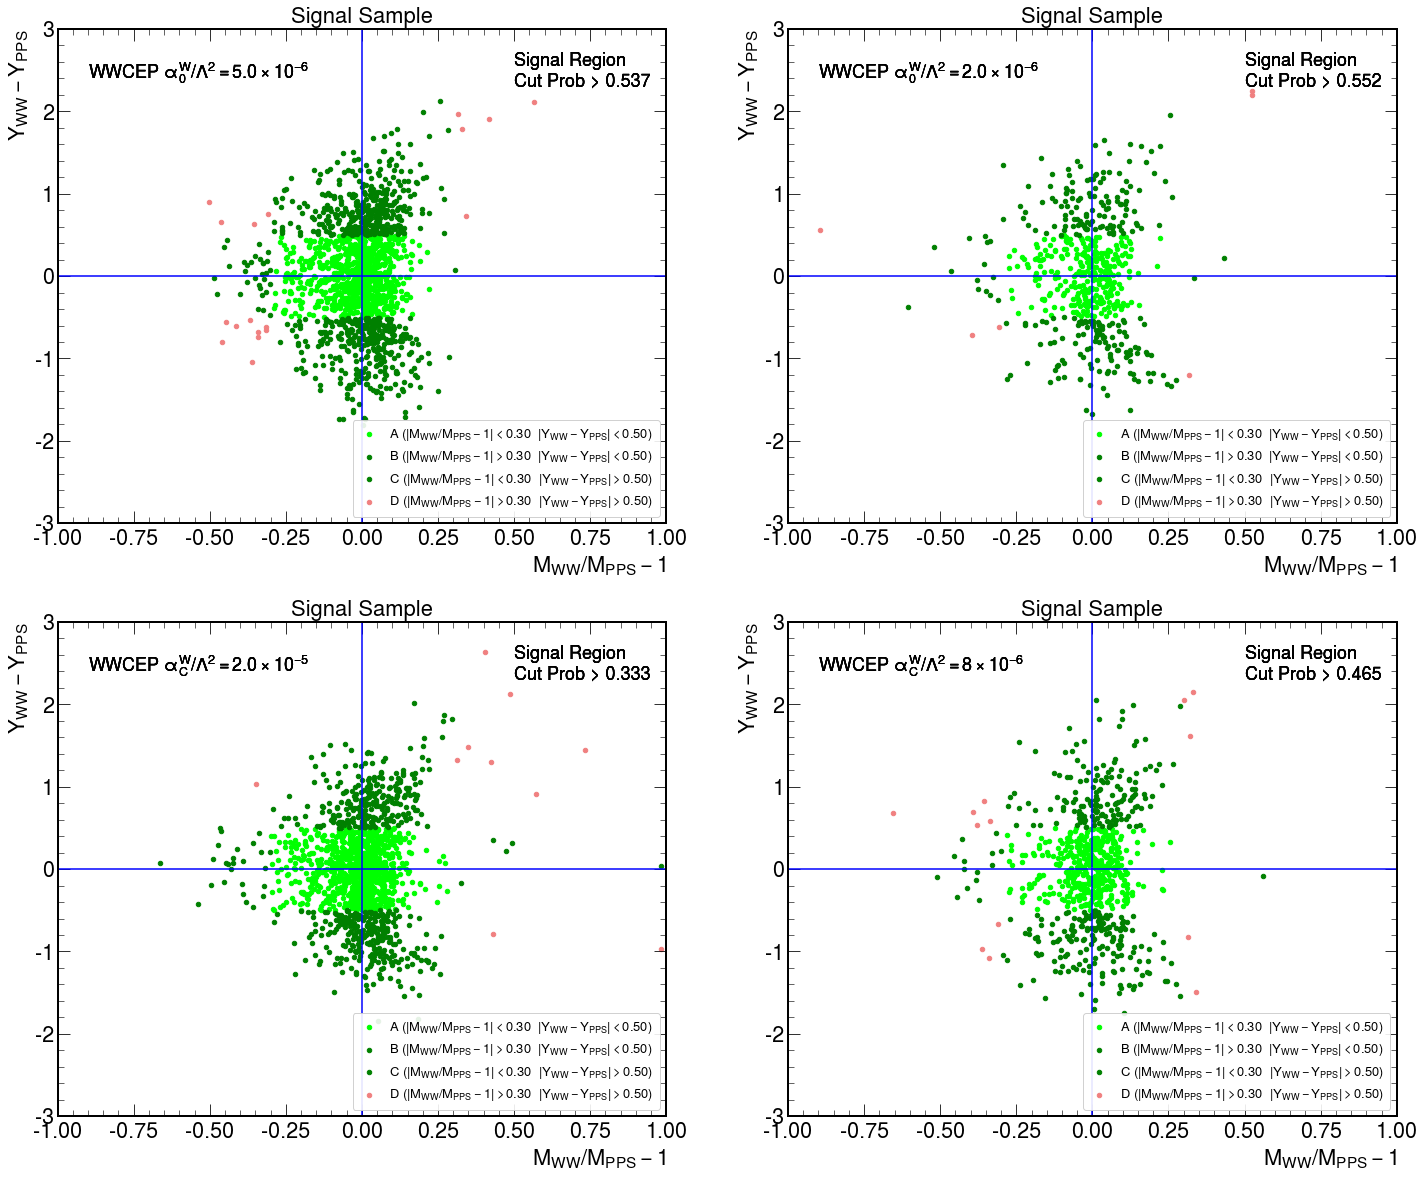

In [60]:
labels_samples = [
    r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 5.0 \times 10^{-6} $',
    r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 2.0 \times 10^{-6} $',
    r'WWCEP $\alpha_{C}^{W}/\Lambda^{2}=2.0 \times 10^{-5}$',
    r'WWCEP $\alpha_{C}^{W}/\Lambda^{2}=8 \times 10^{-6}$' ]

nrows_ = ( int( len(labels_signals)/2 ) + 1 if ( len(labels_signals) % 2 ) > 0 else  int( len(labels_signals)/2 ) )
fig, axes = plt.subplots( nrows_, 2, figsize=(24,nrows_*10) )

row_ = 0
col_ = 0
for label_ in labels_signals:
    print ( label_ )
    
    df_signals_protons_multiRP_events_sigreg[ label_ ]['shiftedRatioMWW_MX'] = df_signals_protons_multiRP_events_sigreg[ label_ ]['Mww/Mx'] - 1
    msk_sig_cut1 = ( np.abs( df_signals_protons_multiRP_events_sigreg[ label_ ][ "shiftedRatioMWW_MX" ] ) <= 0.30 )
    msk_sig_cut2 = ( np.abs( df_signals_protons_multiRP_events_sigreg[ label_ ][ "Yww_Yx" ] ) <= 0.50 )
    msk_sig_A =  msk_sig_cut1 &  msk_sig_cut2
    msk_sig_B = ~msk_sig_cut1 &  msk_sig_cut2
    msk_sig_C =  msk_sig_cut1 & ~msk_sig_cut2
    msk_sig_D = ~msk_sig_cut1 & ~msk_sig_cut2

    n_events_sig   = np.sum(  df_signals_protons_multiRP_events_sigreg[ label_ ][ "weight" ] )
    err_n_events_sig = np.sqrt( np.sum( np.square( df_signals_protons_multiRP_events_sigreg[ label_ ][ "weight" ] ) ) )
    n_events_sig_A = np.sum(  df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_A ][ "weight" ] )
    err_n_events_sig_A = np.sqrt( np.sum( np.square( df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_A ][ "weight" ]  ) ) )
    n_events_sig_B = np.sum( df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_B ][ "weight" ] )
    err_n_events_sig_B = np.sqrt( np.sum( np.square( df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_B ][ "weight" ] ) ) )
    n_events_sig_C = np.sum( df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_C ][ "weight" ] )
    err_n_events_sig_C = np.sqrt( np.sum( np.square( df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_C ][ "weight" ] ) ) )
    n_events_sig_D = np.sum(  df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_D ][ "weight" ] )
    err_n_events_sig_D = np.sqrt( np.sum( np.square( df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_D ][ "weight" ] ) ) )

    print ( "Number of events: {} +/- {}".format( n_events_sig, err_n_events_sig ) )
    print ( "Number of events (A): {} +/- {}".format( n_events_sig_A, err_n_events_sig_A ) )
    print ( "Number of events (B): {} +/- {}".format( n_events_sig_B, err_n_events_sig_B ) )
    print ( "Number of events (C): {} +/- {}".format( n_events_sig_C, err_n_events_sig_C ) )
    print ( "Number of events (D): {} +/- {}".format( n_events_sig_D, err_n_events_sig_D ) )

    x_min = -1.0
    x_max =  1.0
    y_min = -3.0
    y_max =  3.0
    x_center = ( x_min + x_max ) / 2.
    y_center = ( y_min + y_max ) / 2.

    print ( row_, col_ )
    axes[ row_, col_ ].plot( (x_min,x_max), (y_center,y_center), color='blue' )
    axes[ row_, col_ ].plot( (x_center,x_center), (y_min,y_max), color='blue' )
    if np.sum( msk_sig_A ) > 0:
        label_str_ = r"A ($|M_{WW} / M_{PPS} - 1| < 0.30$  $|Y_{WW} - Y_{PPS}| < 0.50$)"
        df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_A ].plot( "shiftedRatioMWW_MX", "Yww_Yx", 'scatter', ax=axes[ row_, col_ ], color='lime', label = label_str_ )
    if np.sum( msk_sig_B ) > 0:
        label_str_ = r"B ($|M_{WW} / M_{PPS} - 1| > 0.30$  $|Y_{WW} - Y_{PPS}| < 0.50$)"
        df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_B ].plot( "shiftedRatioMWW_MX", "Yww_Yx", 'scatter', ax=axes[ row_, col_ ], color='green', label = label_str_ )
    if np.sum( msk_sig_C ) > 0:
        label_str_ = r"C ($|M_{WW} / M_{PPS} - 1| < 0.30$  $|Y_{WW} - Y_{PPS}| > 0.50$)"
        df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_C ].plot( "shiftedRatioMWW_MX", "Yww_Yx", 'scatter', ax=axes[ row_, col_ ], color='green', label = label_str_ )
    if np.sum( msk_sig_D ) > 0:
        label_str_ = r"D ($|M_{WW} / M_{PPS} - 1| > 0.30$  $|Y_{WW} - Y_{PPS}| > 0.50$)"
        df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_D ].plot( "shiftedRatioMWW_MX", "Yww_Yx", 'scatter', ax=axes[ row_, col_ ], color='lightcoral', label = label_str_ )
    #title_str_ = "{}\n$\\rm{{Prob.}} > {:.2f}$".format( labels_samples[ label_ ], prob_cut )
    #title_str_ = r"{}".format( title_str_ )
    #axes[ row_, col_ ].text( 0.70, 0.92, title_str_, horizontalalignment='left', verticalalignment='center', transform=axes[ row_, col_ ].transAxes, fontsize=18 )
    axes[ row_, col_ ].set_xlim(x_min, x_max)
    axes[ row_, col_ ].set_ylim(y_min, y_max)
    axes[ row_, col_ ].set_xlabel( r"$M_{WW} / M_{PPS} - 1$", fontsize=22 )
    axes[ row_, col_ ].set_ylabel( r"$Y_{WW} - Y_{PPS}$", fontsize=22 )
    axes[ row_, col_ ].set_title( "Signal Sample", fontsize=22 )
    axes[ 0 , 0].text( -0.9, 2.4 , labels_samples[0], fontsize=18)
    axes[ 0 , 0].text( 0.5, 2.3 , 'Signal Region\nCut Prob > {:2.3f}'.format(best_cut(y_test8,predict_proba_LGBM8_binary_logloss_scale_pos_weight)), fontsize=18)
    axes[ 0 , 1].text( -0.9, 2.4 , labels_samples[1], fontsize=18)
    axes[ 0 , 1].text( 0.5, 2.3 , 'Signal Region\nCut Prob > {:2.3f}'.format(best_cut(y_test7,predict_proba_LGBM7_binary_logloss_scale_pos_weight)), fontsize=18)
    axes[ 1 , 0].text( -0.9, 2.4 , labels_samples[2], fontsize=18)
    axes[ 1 , 0].text( 0.5, 2.3 , 'Signal Region\nCut Prob > {:2.3f}'.format(best_cut(y_test1,predict_proba_LGBM1_binary_logloss_scale_pos_weight)), fontsize=18)
    axes[ 1 , 1].text( -0.9, 2.4 , labels_samples[3], fontsize=18)
    axes[ 1 , 1].text( 0.5, 2.3 , 'Signal Region\nCut Prob > {:2.3f}'.format(best_cut(y_test4,predict_proba_LGBM4_binary_logloss_scale_pos_weight)), fontsize=18)
    axes[ 0 , 0].legend(loc='lower right', fontsize=13, framealpha=0.9, frameon=True, fancybox=True)
    axes[ 0 , 1].legend(loc='lower right', fontsize=13, framealpha=0.9, frameon=True, fancybox=True)
    axes[ 1 , 0].legend(loc='lower right', fontsize=13, framealpha=0.9, frameon=True, fancybox=True)
    axes[ 1 , 1].legend(loc='lower right', fontsize=13, framealpha=0.9, frameon=True, fancybox=True)
    plt.savefig(pwd_savefig+'multiRP_events_sigreg_SIGNAL_SignalRegion.pdf')
    col_ += 1
    if col_ >= 2:
        row_ += 1
        col_  = 0

## Para os dados na região de background

/home/matheus/miniconda3/envs/root_/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/matheus/miniconda3/envs/root_/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


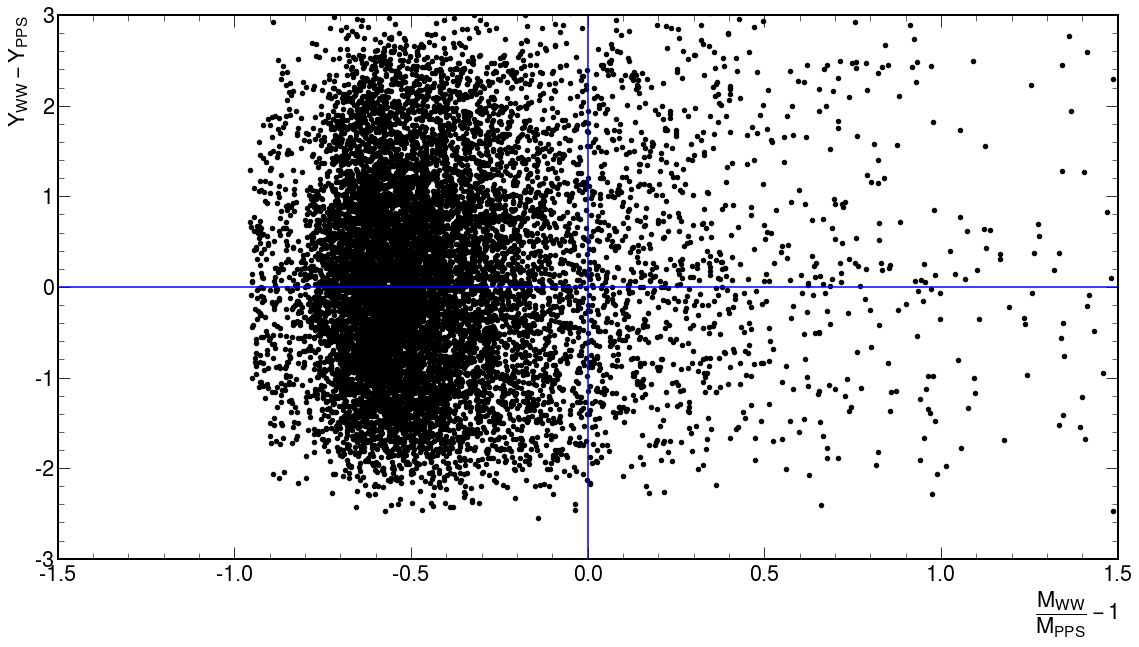

In [61]:
df_protons_multiRP_data_events_bkgreg = data_set_dados_multirp[ data_set_dados_multirp['class_predict8'] == 0 ]
df_protons_multiRP_data_events_bkgreg['shiftedRatioMWW_MX'] =  df_protons_multiRP_data_events_bkgreg[ "Mww/Mx" ] - 1 
df_protons_multiRP_data_events_bkgreg['diffYWW_YX'] = df_protons_multiRP_data_events_bkgreg['Yww_Yx'] 

x_min = -1.5
x_max =  1.5
y_min = -3.0
y_max =  3.0
x_center = ( x_min + x_max ) / 2.
y_center = ( y_min + y_max ) / 2.

fig = plt.figure( figsize=(19,10) )
plt.plot( (x_min,x_max), (y_center,y_center), color='blue' )
plt.plot( (x_center,x_center), (y_min,y_max), color='blue' )
ax = plt.gca()
df_protons_multiRP_data_events_bkgreg.plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='black' )
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel( r"$\dfrac{M_{WW}}{M_{PPS}} - 1$", fontsize=22 )
plt.ylabel( r"$Y_{WW} - Y_{PPS}$", fontsize=22 )
plt.savefig( pwd_savefig+'ABCD_multiRP_data_events_BACKGROUND_REGION.pdf' )
#plt.show()
#plt.close()

## Para os Dados na região de Signal

/home/matheus/miniconda3/envs/root_/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/matheus/miniconda3/envs/root_/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


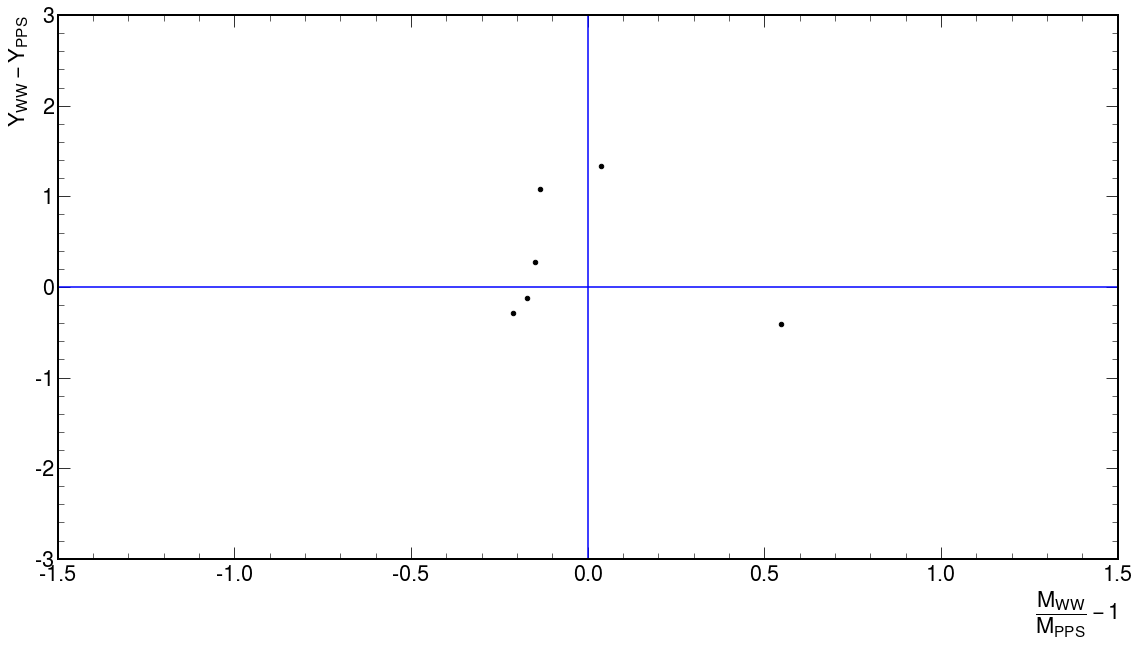

In [62]:
df_protons_multiRP_data_events_bkgreg = data_set_dados_multirp[ data_set_dados_multirp['class_predict8'] == 1 ]
df_protons_multiRP_data_events_bkgreg['shiftedRatioMWW_MX'] =  df_protons_multiRP_data_events_bkgreg[ "Mww/Mx" ] - 1 
df_protons_multiRP_data_events_bkgreg['diffYWW_YX'] = df_protons_multiRP_data_events_bkgreg['Yww_Yx'] 

x_min = -1.5
x_max =  1.5
y_min = -3.0
y_max =  3.0
x_center = ( x_min + x_max ) / 2.
y_center = ( y_min + y_max ) / 2.

fig = plt.figure( figsize=(19,10) )
plt.plot( (x_min,x_max), (y_center,y_center), color='blue' )
plt.plot( (x_center,x_center), (y_min,y_max), color='blue' )
ax = plt.gca()
df_protons_multiRP_data_events_bkgreg.plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='black' )
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel( r"$\dfrac{M_{WW}}{M_{PPS}} - 1$", fontsize=22 )
plt.ylabel( r"$Y_{WW} - Y_{PPS}$", fontsize=22 )
plt.savefig( pwd_savefig+'ABCD_multiRP_data_events_SIGNAL_REGION.pdf' )
#plt.show()
#plt.close()

### Na célula a seguir, plotamos as regiões ABCD para sinal, dados e fundo em cada uma delas. Para os dados, selecionamos apenas os eventos que são categorizados como eventos de fundo (ou seja, cega a seleção do sinal final). 

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


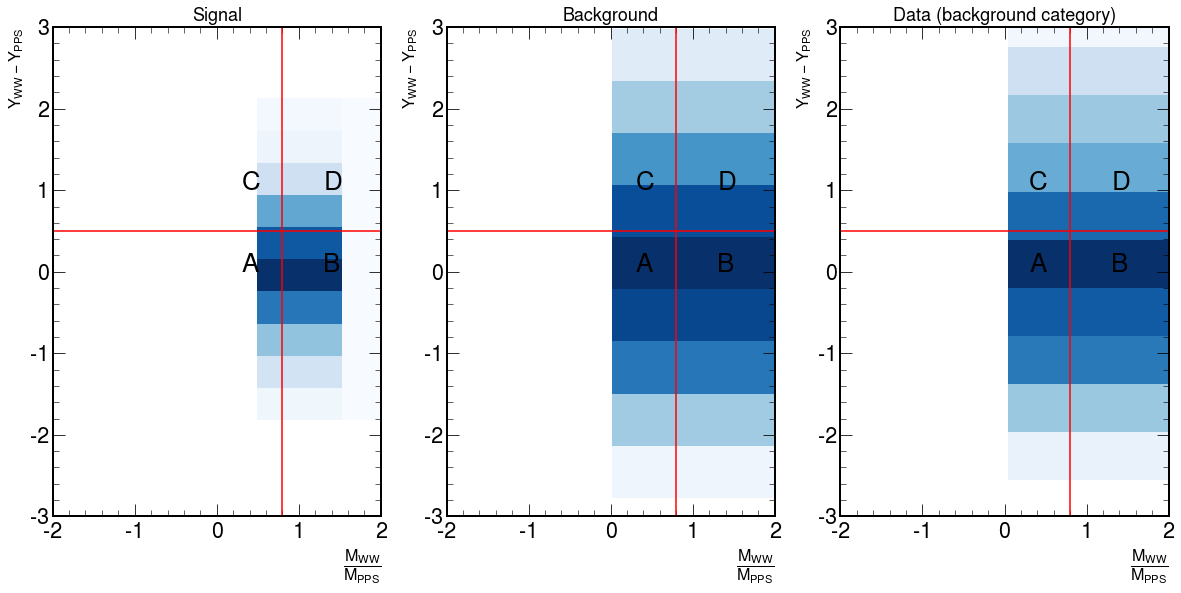

In [63]:
v1='Mww/Mx'
label_x = r'$\dfrac{M_{WW}}{M_{PPS}}$'
cut_v1=0.8
range_v1=(-2,2)

v2='Yww_Yx'
label_y = r'$Y_{WW} - Y_{PPS}$'
cut_v2=0.5
range_v2=(-3,3)

def doScatter(df,label, ax):
    ax.hist2d(df[v1],df[v2], cmap='Blues')
    ax.set_xlim(*range_v1)
    ax.set_ylim(*range_v2)
    ax.set_xlabel(label_x, fontsize = 16)
    ax.set_ylabel(label_y, fontsize = 16)
    ax.plot([cut_v1,cut_v1],[range_v2[0],range_v2[1]],color='red')
    ax.plot([range_v1[0],range_v1[1]],[cut_v2,cut_v2],color='red')
    #ax.text(0.2,0.9,label, transform=ax.transAxes)
    ax.set_title(label, fontsize = 18)
    ax.text(cut_v1-0.5,cut_v2-0.5,'A')
    ax.text(cut_v1+0.5,cut_v2-0.5,'B')
    ax.text(cut_v1-0.5,cut_v2+0.5,'C')
    ax.text(cut_v1+0.5,cut_v2+0.5,'D')

    
fig, ax = plt.subplots( 1, 3, figsize = (20,9) )
doScatter( df_signals_protons_multiRP_events_sigreg['ANOMALO8'],'Signal', ax[0] )
doScatter( data_set_back_multirp,'Background', ax[1] )
doScatter( data_set_dados_multirp[data_set_dados_multirp['class_predict8'] == 0 ],'Data (background category)', ax[2] )
plt.savefig( pwd_savefig+'ABCD_methods_Anomalo8.pdf' )
#plt.show()
#plt.close()

In [64]:
def getABCDYields(df):
    
    """obtém os rendimentos nas diferentes regiões abcd"""

    mask_a = ( df[v1] < cut_v1 ) & ( df[v2] < cut_v2 )
    mask_b = ( df[v1] > cut_v1 ) & ( df[v2] < cut_v2 )
    mask_c = ( df[v1] < cut_v1 ) & ( df[v2] > cut_v2 )
    mask_d = ( df[v1] > cut_v1 ) & ( df[v2] > cut_v2 )
    
    yields = {'A': df[ mask_a ].shape[0],
              'B': df[ mask_b ].shape[0],
              'C': df[ mask_c ].shape[0],
              'D': df[ mask_d ].shape[0]}

    return yields
 
def getABCDPrediction(df):
    
    """
    partindo dos rendimentos nas diferentes regiões, aplica-se a fórmula ABCD
    retorna o número de eventos observados na região do sinal e o número estimado de eventos
    """
    
    yields = getABCDYields( df )
    
    return yields['A'], yields['B']*yields['C']/yields['D']


In [65]:
print( 'Data (background category)' )
nA,nAest=getABCDPrediction( data_set_dados_multirp[data_set_dados_multirp[ 'class_predict8' ] == 0 ] )
print('\n Número de eventos observados na região de Sinal=%d \n Número de eventos estimados=%3.1f bias=%3.3f'%( nA, nAest, nAest / nA ), '\n' )

print( 'Data (background)' )
nA,nAest=getABCDPrediction( data_set_back_multirp )
print('\n Número de eventos observados na região de Sinal=%d \n Número de eventos estimados=%3.1f bias=%3.3f'%( nA, nAest, nAest / nA ), '\n' )

# calcular o erro sistemático do teste de fechamento em segundo plano 
SYS_ERROR = '%2.3f'%( nAest/nA if ( nAest > nA ) else nA/nAest )
print( 'erro sistemático = '+SYS_ERROR, '\n' )

Data (background category)

 Número de eventos observados na região de Sinal=6126 
 Número de eventos estimados=5268.4 bias=0.860 

Data (background)

 Número de eventos observados na região de Sinal=135917 
 Número de eventos estimados=132155.1 bias=0.972 

erro sistemático = 1.028 



In [66]:
print('Iniciando a análise estatística \n')

import ROOT

samples={'bkg':data_set_back_multirp,
         'sig':data_set_dados_multirp,
         'data_obs':data_set_dados_multirp}

# loop sobre as amostras
# obter rendimentos nas diferentes regiões 
yields_abcd={}
for df_name,df in samples.items():    
    yields_abcd[df_name]=getABCDYields(df)

# aplicar um fator de escala à estimativa de fundo de forma que corresponda aos dados na região D 
bkgSF=yields_abcd['data_obs']['D']/yields_abcd['bkg']['D']
for x in yields_abcd['bkg']: 
    yields_abcd['bkg'][x]=bkgSF*yields_abcd['bkg'][x]


print('A estimativa de fundo foi dimensionada por %3.3f'%bkgSF, '\n')

# aplicar um fator de escala ao sinal para normalizar por luminosidade 
SingleMuon_Run2016B = 4.55
SingleMuon_Run2016C = 1.59
SingleMuon_Run2016G = 3.65
Luminosidade        = SingleMuon_Run2016B + SingleMuon_Run2016C + SingleMuon_Run2016G 

cross_section_SM       = 40.41*0.17
cross_section_ANOMALO1 = 166.1*0.17 
cross_section_ANOMALO2 = 41.90*0.17
cross_section_ANOMALO3 = 48.75*0.17
cross_section_ANOMALO4 = 61.14*0.17
cross_section_ANOMALO5 = 41.58*0.17
cross_section_ANOMALO6 = 44.93*0.17
cross_section_ANOMALO7 = 58.18*0.17 
cross_section_ANOMALO8 = 150.3*0.17

sigSF = cross_section_ANOMALO8 * Luminosidade # cross section and luminosity

# normalize o sinal para o número total de eventos
sigSF=sigSF/ANOMALO8.shape[0]

for x in yields_abcd['sig']: 
    yields_abcd['sig'][x]=sigSF*yields_abcd['sig'][x]


print('A estimativa do sinal foi dimensionada por %3.3f'%sigSF, '\n')

Iniciando a análise estatística 

Welcome to JupyROOT 6.22/02
A estimativa de fundo foi dimensionada por 0.018 

A estimativa do sinal foi dimensionada por 0.127 



In [67]:
def maskForRegion(df,region):
    
    """obtém o conjunto de dados em uma das regiões ABCD - será útil ao projetar a forma nessas regiões """
    
    if region=='A':
        return df[ (df[v1]<cut_v1) & (df[v2]<cut_v2) ]
    if region=='B':
        return df[ (df[v1]>cut_v1) & (df[v2]<cut_v2) ]
    if region=='C':
        return df[ (df[v1]<cut_v1) & (df[v2]>cut_v2) ]
    if region=='D':
        return df[ (df[v1]>cut_v1) & (df[v2]>cut_v2) ]

    return df

In [68]:
# modelo para a forma da distribuição a ser analisada
nbins=11
shapeH=ROOT.TH1F('shape','shape',nbins-1,0,nbins-1)
shapeH.SetDirectory(0)

# abra o arquivo de saída
fOut=ROOT.TFile.Open('shapesMVA_.root','RECREATE')

# loop sobre as amostras
for df_name in samples:    
    
    # salve as contagens no histograma e armazene-as no arquivo 
    for region in yields_abcd[df_name]:
        shape=shapeH.Clone('{}_{}'.format(df_name,region))
        nevts=yields_abcd[df_name][region]
        #print('yields_abcd', yields_abcd)
        print('shape',shape)
        print('nevts',nevts)
        # experimento de contagem simples
        if nbins==1:
            shape.SetBinContent(1,nevts)
         # análise de forma: construir o histograma para o discriminador
         # normalize para a previsão de rendimento final
         # save para o histograma ROOT 
        else:
            df_masked= maskForRegion( samples[df_name], region )
            hist,_=np.histogram(df_masked['class_predict8'],
                                bins = np.linspace( 0,1,nbins ) )
            #print('df_masked', df_masked)
            #print('hist', hist)
            norm=sum(hist)
            #print('norm',norm)
            if norm>0:
                for i in range(nbins-1):
                    #do not leave absolute 0 except for data
                    cts=hist[i]*yields_abcd[df_name][region]/norm
                    #print('cts',cts)
                    if df_name!='data_obs': 
                        cts=max(float(cts),1e-6)
                    shape.SetBinContent(i+1,cts)
                
        # salvar shape para arquivo
        shape.SetDirectory(fOut)
        shape.Write()

fOut.Close()

shapeH.Delete()

shape Name: bkg_A Title: shape NbinsX: 10
nevts 2454.5184510355643
shape Name: bkg_B Title: shape NbinsX: 10
nevts 1292.515245168135
shape Name: bkg_C Title: shape NbinsX: 10
nevts 1445.7815628027122
shape Name: bkg_D Title: shape NbinsX: 10
nevts 783.0
shape Name: sig_A Title: shape NbinsX: 10
nevts 779.5697176144457
shape Name: sig_B Title: shape NbinsX: 10
nevts 157.64434145981693
shape Name: sig_C Title: shape NbinsX: 10
nevts 423.5657891200408
shape Name: sig_D Title: shape NbinsX: 10
nevts 99.62511651576808
shape Name: data_obs_A Title: shape NbinsX: 10
nevts 6127
shape Name: data_obs_B Title: shape NbinsX: 10
nevts 1239
shape Name: data_obs_C Title: shape NbinsX: 10
nevts 3329
shape Name: data_obs_D Title: shape NbinsX: 10
nevts 783


## Contagem dos eventos depois do corte

In [69]:
DrellYan_counting = np.sum(DataSet_multiRP_DrellYan['weight'])
QCD_counting = np.sum(DataSet_multiRP_QCD['weight'])
Single_top_counting = np.sum(DataSet_multiRP_single_top['weight'])
VV_inclusive_counting = np.sum(DataSet_multiRP_VV_inclusivo['weight'])
WJets_counting = np.sum(DataSet_multiRP_WJets['weight'])
ttbar_counting = np.sum(DataSet_multiRP_TTbar['weight'])
ANOMALO8_counting = np.sum(ANOMALO8['weight'])
SM_counting = np.sum(SM['weight'])


In [70]:
DrellYan_counting_8 = np.sum(DataSet_multiRP_DrellYan[DataSet_multiRP_DrellYan['class_predict8']==1]['weight'])
QCD_counting_8 = np.sum(DataSet_multiRP_QCD[DataSet_multiRP_QCD['class_predict8']==1]['weight'])
Single_top_counting_8 = np.sum(DataSet_multiRP_single_top[DataSet_multiRP_single_top['class_predict8']==1]['weight'])
VV_inclusive_counting_8 = np.sum(DataSet_multiRP_VV_inclusivo[DataSet_multiRP_VV_inclusivo['class_predict8']==1]['weight'])
WJets_counting_8 = np.sum(DataSet_multiRP_WJets[DataSet_multiRP_WJets['class_predict8']==1]['weight'])
ttbar_counting_8 = np.sum(DataSet_multiRP_TTbar[DataSet_multiRP_TTbar['class_predict8']==1]['weight'])
ANOMALO8_counting_8 = np.sum(ANOMALO8[ANOMALO8['class_predict']==1]['weight'])
SM_counting_8 = np.sum(SM[SM['class_predict8']==1]['weight'])

DrellYan_counting_7 = np.sum(DataSet_multiRP_DrellYan[DataSet_multiRP_DrellYan['class_predict7']==1]['weight'])
QCD_counting_7 = np.sum(DataSet_multiRP_QCD[DataSet_multiRP_QCD['class_predict7']==1]['weight'])
Single_top_counting_7 = np.sum(DataSet_multiRP_single_top[DataSet_multiRP_single_top['class_predict7']==1]['weight'])
VV_inclusive_counting_7 = np.sum(DataSet_multiRP_VV_inclusivo[DataSet_multiRP_VV_inclusivo['class_predict7']==1]['weight'])
WJets_counting_7 = np.sum(DataSet_multiRP_WJets[DataSet_multiRP_WJets['class_predict7']==1]['weight'])
ttbar_counting_7 = np.sum(DataSet_multiRP_TTbar[DataSet_multiRP_TTbar['class_predict7']==1]['weight'])
ANOMALO7_counting_7 = np.sum(ANOMALO7[ANOMALO7['class_predict']==1]['weight'])
SM_counting_7 = np.sum(SM[SM['class_predict7']==1]['weight'])

DrellYan_counting_6 = np.sum(DataSet_multiRP_DrellYan[DataSet_multiRP_DrellYan['class_predict6']==1]['weight'])
QCD_counting_6 = np.sum(DataSet_multiRP_QCD[DataSet_multiRP_QCD['class_predict6']==1]['weight'])
Single_top_counting_6 = np.sum(DataSet_multiRP_single_top[DataSet_multiRP_single_top['class_predict6']==1]['weight'])
VV_inclusive_counting_6 = np.sum(DataSet_multiRP_VV_inclusivo[DataSet_multiRP_VV_inclusivo['class_predict6']==1]['weight'])
WJets_counting_6 = np.sum(DataSet_multiRP_WJets[DataSet_multiRP_WJets['class_predict6']==1]['weight'])
ttbar_counting_6 = np.sum(DataSet_multiRP_TTbar[DataSet_multiRP_TTbar['class_predict6']==1]['weight'])
ANOMALO6_counting_6 = np.sum(ANOMALO6[ANOMALO6['class_predict']==1]['weight'])
SM_counting_6 = np.sum(SM[SM['class_predict6']==1]['weight'])

DrellYan_counting_5 = np.sum(DataSet_multiRP_DrellYan[DataSet_multiRP_DrellYan['class_predict5']==1]['weight'])
QCD_counting_5 = np.sum(DataSet_multiRP_QCD[DataSet_multiRP_QCD['class_predict5']==1]['weight'])
Single_top_counting_5 = np.sum(DataSet_multiRP_single_top[DataSet_multiRP_single_top['class_predict5']==1]['weight'])
VV_inclusive_counting_5 = np.sum(DataSet_multiRP_VV_inclusivo[DataSet_multiRP_VV_inclusivo['class_predict5']==1]['weight'])
WJets_counting_5 = np.sum(DataSet_multiRP_WJets[DataSet_multiRP_WJets['class_predict7']==1]['weight'])
ttbar_counting_5 = np.sum(DataSet_multiRP_TTbar[DataSet_multiRP_TTbar['class_predict5']==1]['weight'])
ANOMALO5_counting_5 = np.sum(ANOMALO5[ANOMALO5['class_predict']==1]['weight'])
SM_counting_5 = np.sum(SM[SM['class_predict5']==1]['weight'])

DrellYan_counting_1 = np.sum(DataSet_multiRP_DrellYan[DataSet_multiRP_DrellYan['class_predict1']==1]['weight'])
QCD_counting_1 = np.sum(DataSet_multiRP_QCD[DataSet_multiRP_QCD['class_predict1']==1]['weight'])
Single_top_counting_1 = np.sum(DataSet_multiRP_single_top[DataSet_multiRP_single_top['class_predict1']==1]['weight'])
VV_inclusive_counting_1 = np.sum(DataSet_multiRP_VV_inclusivo[DataSet_multiRP_VV_inclusivo['class_predict1']==1]['weight'])
WJets_counting_1 = np.sum(DataSet_multiRP_WJets[DataSet_multiRP_WJets['class_predict1']==1]['weight'])
ttbar_counting_1 = np.sum(DataSet_multiRP_TTbar[DataSet_multiRP_TTbar['class_predict1']==1]['weight'])
ANOMALO7_counting_1 = np.sum(ANOMALO1[ANOMALO1['class_predict']==1]['weight'])
SM_counting_1 = np.sum(SM[SM['class_predict1']==1]['weight'])

DrellYan_counting_2 = np.sum(DataSet_multiRP_DrellYan[DataSet_multiRP_DrellYan['class_predict2']==1]['weight'])
QCD_counting_2 = np.sum(DataSet_multiRP_QCD[DataSet_multiRP_QCD['class_predict2']==1]['weight'])
Single_top_counting_2 = np.sum(DataSet_multiRP_single_top[DataSet_multiRP_single_top['class_predict2']==1]['weight'])
VV_inclusive_counting_2 = np.sum(DataSet_multiRP_VV_inclusivo[DataSet_multiRP_VV_inclusivo['class_predict2']==1]['weight'])
WJets_counting_2 = np.sum(DataSet_multiRP_WJets[DataSet_multiRP_WJets['class_predict2']==1]['weight'])
ttbar_counting_2 = np.sum(DataSet_multiRP_TTbar[DataSet_multiRP_TTbar['class_predict2']==1]['weight'])
ANOMALO2_counting_2 = np.sum(ANOMALO2[ANOMALO2['class_predict']==1]['weight'])
SM_counting_2 = np.sum(SM[SM['class_predict2']==1]['weight'])

DrellYan_counting_3 = np.sum(DataSet_multiRP_DrellYan[DataSet_multiRP_DrellYan['class_predict3']==1]['weight'])
QCD_counting_3 = np.sum(DataSet_multiRP_QCD[DataSet_multiRP_QCD['class_predict3']==1]['weight'])
Single_top_counting_3 = np.sum(DataSet_multiRP_single_top[DataSet_multiRP_single_top['class_predict3']==1]['weight'])
VV_inclusive_counting_3 = np.sum(DataSet_multiRP_VV_inclusivo[DataSet_multiRP_VV_inclusivo['class_predict3']==1]['weight'])
WJets_counting_3 = np.sum(DataSet_multiRP_WJets[DataSet_multiRP_WJets['class_predict3']==1]['weight'])
ttbar_counting_3 = np.sum(DataSet_multiRP_TTbar[DataSet_multiRP_TTbar['class_predict3']==1]['weight'])
ANOMALO7_counting_3 = np.sum(ANOMALO3[ANOMALO3['class_predict']==1]['weight'])
SM_counting_3 = np.sum(SM[SM['class_predict3']==1]['weight'])

DrellYan_counting_4 = np.sum(DataSet_multiRP_DrellYan[DataSet_multiRP_DrellYan['class_predict4']==1]['weight'])
QCD_counting_4 = np.sum(DataSet_multiRP_QCD[DataSet_multiRP_QCD['class_predict4']==1]['weight'])
Single_top_counting_4 = np.sum(DataSet_multiRP_single_top[DataSet_multiRP_single_top['class_predict4']==1]['weight'])
VV_inclusive_counting_4 = np.sum(DataSet_multiRP_VV_inclusivo[DataSet_multiRP_VV_inclusivo['class_predict4']==1]['weight'])
WJets_counting_4 = np.sum(DataSet_multiRP_WJets[DataSet_multiRP_WJets['class_predict4']==1]['weight'])
ttbar_counting_4 = np.sum(DataSet_multiRP_TTbar[DataSet_multiRP_TTbar['class_predict4']==1]['weight'])
ANOMALO4_counting_4 = np.sum(ANOMALO4[ANOMALO4['class_predict']==1]['weight'])
SM_counting_4 = np.sum(SM[SM['class_predict4']==1]['weight'])

# Datacard

* ### O layout do datacard é o seguinte:


No topo estão os números imax, jmax e kmax que representam o número de bins, processos e parâmetros de incômodo(nuisance), respectivamente.
Aqui, um "bin" pode se referir a uma contagem literal de evento único, ou uma distribuição completa que estamos ajustando, em geral com muitos bins de histograma. É possível substituir esses números por * e eles serão deduzidos automaticamente.

A primeira linha começando com bin fornece um rótulo exclusivo para cada canal, e a linha seguinte começando com observação fornece o número de eventos observados dos $\textbf{DADOS}$.

As primeiras quatro linhas rotuladas bin, process, process e rate fornecem o rótulo do canal, o rótulo do processo, um identificador de processo (<= 0 para signal,> 0 para background) e o número de eventos esperados, respectivamente.

As linhas restantes descrevem fontes de incerteza sistemática. Cada linha dá o nome da incerteza (que se tornará o nome do parâmetro incômodo dentro de nosso modelo RooFit), o tipo de incerteza ("lnN" = incerteza de normalização logarítmica) e o efeito em cada processo em cada canal. Por exemplo. uma incerteza de 20% no rendimento é escrita como 1,20.

Também é possível adicionar um símbolo hash (#) no início de uma linha, que a combinação irá ignorar quando ler o cartão.

* ### Limites assintóticos


Como estamos procurando por um processo de sinal que não existe no modelo padrão, é natural definir um limite superior na seção de choque vezes a fração de ramificação do processo (assumindo que nosso conjunto de dados não contém uma descoberta significativa de nova física). $\texttt{Combine}$ tem método dedicado para calcular os limites superiores. O mais comumente usado é $\texttt{AsymptoticLimits}$, que implementa o critério $\texttt{CLs}$ e usa a razão de verossimilhança do perfil como estatística de teste. Como o nome indica, as distribuições estatísticas de teste são determinadas analiticamente na aproximação assintótica, portanto, não há necessidade de mais tempo para arremessar e ajustar o brinquedo. Executando o seguinte comando: 

$\texttt{combine -M AsymptoticLimits datacard_part1.txt -n .part1A}$

Você deve ver os resultados dos cálculos dos limites observados e esperados impressos na tela. Aqui adicionamos uma opção extra, -n .part1A, que é a abreviação de --name, e é usada para rotular os arquivos de saída combinados produzidos.

In [71]:
print('Inciando o Datacard com o método ABCD\n')

dc=open('datacard_ABCD_8.dat','w')

dc.write('imax *  number of channels\n')
dc.write('jmax *  number of processes -1\n')
dc.write('kmax *  number of nuisance parameters (sources of systematical uncertainties)\n')
dc.write('------------------------------------------------------------------------------------------------------------ \n')

#spell out out the shapes are stored in the ROOT file
dc.write('shapes * * shapesMVA_.root $PROCESS_$CHANNEL $PROCESS_$CHANNEL_$SYSTEMATIC\n')

#add the data observations
dc.write('bin            A   B    C    D\n')
dc.write('observation  {0} {1} {2} {3}\n'.format(yields_abcd['data_obs']['A'],
                                                 yields_abcd['data_obs']['B'],
                                                 yields_abcd['data_obs']['C'],
                                                 yields_abcd['data_obs']['D']))
dc.write('------------------------------------------------------------------------------------------------------------ \n')
dc.write('------------------------------------------------------------------------------------------------------------ \n')

#add the expectations for signal and background
dc.write('bin         A               A            B           B          C           C            D          D\n')
dc.write('process     sig             bkg          sig         bkg        sig         bkg          sig        bkg\n')
dc.write('process     0               1            0           1          0           1            0          1\n')
dc.write('rate        {0:.3f}      {1:.3f}      {2:.3f}     {3:.3f}     {4:.3f}     {5:.3f}     {6:.3f}     {7:.3f}\n'.format(yields_abcd['sig']['A'],
                                                                                                  yields_abcd['bkg']['A'],
                                                                                                  yields_abcd['sig']['B'],
                                                                                                  yields_abcd['bkg']['B'],
                                                                                                  yields_abcd['sig']['C'],
                                                                                                  yields_abcd['bkg']['C'],
                                                                                                  yields_abcd['sig']['D'],
                                                                                                  yields_abcd['bkg']['D'],
                                                                                                 ))
dc.write('------------------------------------------------------------------------------------------------------------ \n')
dc.write('------------------------------------------------------------------------------------------------------------ \n')

#add 2.7% unc. on luminosity
dc.write('lumi_13TeV lnN 1.10 - 1.10- 1.10 - 1.10 -\n')
if '1.00' not in SYS_ERROR: 
    dc.write('syst_bkg lnN - '+SYS_ERROR+' - - - - - -\n')

#spell-out the ABCD method
dc.write('alpha rateParam A bkg (@0*@1/@2) beta,gamma,delta\n')
dc.write('beta  rateParam B bkg {}\n'.format(yields_abcd['bkg']['B']))
dc.write('gamma rateParam C bkg {}\n'.format(yields_abcd['bkg']['C']))
dc.write('delta rateParam D bkg {}\n'.format(yields_abcd['bkg']['D']))
         
#all done
dc.close()

print('datacard.dat is ready to be used with combine\n\n')

import os

_ = os.system('cat datacard_ABCD_8.dat')

Inciando o Datacard com o método ABCD

datacard.dat is ready to be used with combine


imax *  number of channels
jmax *  number of processes -1
kmax *  number of nuisance parameters (sources of systematical uncertainties)
------------------------------------------------------------------------------------------------------------ 
shapes * * shapesMVA_.root $PROCESS_$CHANNEL $PROCESS_$CHANNEL_$SYSTEMATIC
bin            A   B    C    D
observation  6127 1239 3329 783
------------------------------------------------------------------------------------------------------------ 
------------------------------------------------------------------------------------------------------------ 
bin         A               A            B           B          C           C            D          D
process     sig             bkg          sig         bkg        sig         bkg          sig        bkg
process     0               1            0           1          0           1            0          1
r

In [72]:
print('Inciando o Datacard com o método simple_counting\n')

dc=open('datacard_simple_counting_alpha0_5e-6.txt','w')

dc.write('imax *  number of channels\n')
dc.write('jmax *  number of processes -1\n')
dc.write('kmax *  number of nuisance parameters (sources of systematical uncertainties)\n')
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')

#add the data observations
dc.write('bin           signal_region  \n')
dc.write('observation       {}\n'.format(len( n_eventos_Data_after_cut8 )))

dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')

#add the expectations for signal and background
dc.write('bin       signal_region    signal_region      signal_region    \n')
dc.write('process     Anomalo8       Standard_Model      Background        \n')
dc.write('process         0                 1                2            \n')
dc.write('rate         {0:.3f}             {1:.3f}             {2:.3f}    \n'.format(DataSet_Test8_weight_signal[ n_events_signal_after_cut8 ].sum() / test_size,
                                                                                     DataSet_TestSM8_weight_signal[ n_events_SM_after_cut8 ].sum() / test_size,
                                                                                     DataSet_Test8_weight_backgr[ n_events_back_after_cut8 ].sum() / test_size
                                                                                                                                                     ))
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')

#add the sources of systematic uncertainty
dc.write('lumi      lnN  1.025                1.0              1.0         \n')
#dc.write('effic_pps lnN  1.10                 -               -       \n')


       
#all done  cross_section_TT
dc.close()

print('datacard.dat is ready to be used with combine\n\n')

import os

_ = os.system('cat datacard_simple_counting_alpha0_5e-6.txt')

Inciando o Datacard com o método simple_counting

datacard.dat is ready to be used with combine


imax *  number of channels
jmax *  number of processes -1
kmax *  number of nuisance parameters (sources of systematical uncertainties)
----------------------------------------------------------------------------------------------------------------------------------------------------- 
bin           signal_region  
observation       6
----------------------------------------------------------------------------------------------------------------------------------------------------- 
----------------------------------------------------------------------------------------------------------------------------------------------------- 
bin       signal_region    signal_region      signal_region    
process     Anomalo8       Standard_Model      Background        
process         0                 1                2            
rate         22.212             0.175             4.755    
--------

In [73]:
print('Inciando o Datacard com o método simple_counting\n')

dc=open('datacard_simple_counting_alpha0_2e-6.txt','w')

dc.write('imax *  number of channels\n')
dc.write('jmax *  number of processes -1\n')
dc.write('kmax *  number of nuisance parameters (sources of systematical uncertainties)\n')
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')

#add the data observations
dc.write('bin           signal_region  \n')
dc.write('observation       {}\n'.format(len( n_eventos_Data_after_cut7 )))

dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')

#add the expectations for signal and background
dc.write('bin       signal_region    signal_region      signal_region     \n')
dc.write('process     Anomalo7       Standard_Model       Background         \n')
dc.write('process         0                 1                2           \n')
dc.write('rate         {0:.3f}             {1:.3f}             {2:.3f}     \n'.format(DataSet_Test7_weight_signal[ n_events_signal_after_cut7 ].sum() / test_size ,
                                                                                      DataSet_TestSM7_weight_signal[ n_events_SM_after_cut7 ].sum() / test_size,
                                                                                      DataSet_Test7_weight_backgr[ n_events_back_after_cut7 ].sum() / test_size
                                                                               
                                                                                                                                                     ))
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')

#add the sources of systematic uncertainty
dc.write('lumi      lnN  1.025               1.0               1.0      \n')
#dc.write('effic_pps lnN  1.10              1.10             1.10    \n')


       
#all done  cross_section_TT
dc.close()

print('datacard.dat is ready to be used with combine\n\n')

import os

_ = os.system('cat datacard_simple_counting_alpha0_2e-6.txt')

Inciando o Datacard com o método simple_counting

datacard.dat is ready to be used with combine


imax *  number of channels
jmax *  number of processes -1
kmax *  number of nuisance parameters (sources of systematical uncertainties)
----------------------------------------------------------------------------------------------------------------------------------------------------- 
bin           signal_region  
observation       3
----------------------------------------------------------------------------------------------------------------------------------------------------- 
----------------------------------------------------------------------------------------------------------------------------------------------------- 
bin       signal_region    signal_region      signal_region     
process     Anomalo7       Standard_Model       Background         
process         0                 1                2           
rate         2.889             0.098             5.535     
------

In [74]:
print('Inciando o Datacard com o método simple_counting\n')

dc=open('datacard_simple_counting_alpha0_1e-6.txt','w')

dc.write('imax *  number of channels\n')
dc.write('jmax *  number of processes -1\n')
dc.write('kmax *  number of nuisance parameters (sources of systematical uncertainties)\n')
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')

#add the data observations
dc.write('bin           signal_region  \n')
dc.write('observation       {}\n'.format(len( n_eventos_Data_after_cut6 )))

dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')

#add the expectations for signal and background
dc.write('bin       signal_region    signal_region      signal_region    \n')
dc.write('process     Anomalo6      Standard_Model       Background       \n')
dc.write('process         0                 1                2           \n')
dc.write('rate         {0:.3f}             {1:.3f}             {2:.3f}   \n'.format(DataSet_Test6_weight_signal[ n_events_signal_after_cut6].sum() / test_size,
                                                                                    DataSet_TestSM6_weight_signal[ n_events_SM_after_cut6 ].sum() / test_size,
                                                                                    DataSet_Test6_weight_backgr[ n_events_back_after_cut6 ].sum() / test_size
                                                                            ,
                                                                                                                                                     ))
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')

#add the sources of systematic uncertainty
dc.write('lumi      lnN  1.025                1.0              1.0humm          \n')
#dc.write('effic_pps lnN  1.10              1.10             1.10          \n')


       
#all done  cross_section_TT
dc.close()

print('datacard.dat is ready to be used with combine\n\n')

import os

_ = os.system('cat datacard_simple_counting_alpha0_1e-6.txt')

Inciando o Datacard com o método simple_counting

datacard.dat is ready to be used with combine


imax *  number of channels
jmax *  number of processes -1
kmax *  number of nuisance parameters (sources of systematical uncertainties)
----------------------------------------------------------------------------------------------------------------------------------------------------- 
bin           signal_region  
observation       2
----------------------------------------------------------------------------------------------------------------------------------------------------- 
----------------------------------------------------------------------------------------------------------------------------------------------------- 
bin       signal_region    signal_region      signal_region    
process     Anomalo6      Standard_Model       Background       
process         0                 1                2           
rate         0.411             0.088             1.523   
------------

In [75]:
print('Inciando o Datacard com o método simple_counting\n')

dc=open('datacard_simple_counting_alpha0_0.5e-6.txt','w')

dc.write('imax *  number of channels\n')
dc.write('jmax *  number of processes -1\n')
dc.write('kmax *  number of nuisance parameters (sources of systematical uncertainties)\n')
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')

#add the data observations
dc.write('bin           signal_region  \n')
dc.write('observation       {}\n'.format(len( n_eventos_Data_after_cut5 )))

dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')

#add the expectations for signal and background
dc.write('bin       signal_region    signal_region      signal_region       \n')
dc.write('process     Anomalo5       Standard_Model      Background         \n')
dc.write('process         0                 1                2              \n')
dc.write('rate         {0:.3f}             {1:.3f}         {2:.3f}                                                                             \n'.format(DataSet_Test5_weight_signal[ n_events_signal_after_cut5 ].sum() / test_size,
                                                                                                                                                   DataSet_TestSM5_weight_signal[ n_events_SM_after_cut5 ].sum() / test_size,
                                                                                                                                                   DataSet_Test5_weight_backgr[ n_events_back_after_cut5 ].sum() / test_size
                                                                                                                                                     ))
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')

#add the sources of systematic uncertainty
dc.write('lumi      lnN  1.025                -               -                 \n')
#dc.write('xsecttbar lnN    -                 -              1.013              \n')
dc.write('effic_pps lnN  1.10              1.10             1.10                \n')


       
#all done  cross_section_TT
dc.close()

print('datacard.dat is ready to be used with combine\n\n')

import os

_ = os.system('cat datacard_simple_counting_alpha0_0.5e-6.txt')

Inciando o Datacard com o método simple_counting

datacard.dat is ready to be used with combine


imax *  number of channels
jmax *  number of processes -1
kmax *  number of nuisance parameters (sources of systematical uncertainties)
----------------------------------------------------------------------------------------------------------------------------------------------------- 
bin           signal_region  
observation       3
----------------------------------------------------------------------------------------------------------------------------------------------------- 
----------------------------------------------------------------------------------------------------------------------------------------------------- 
bin       signal_region    signal_region      signal_region       
process     Anomalo5       Standard_Model      Background         
process         0                 1                2              
rate         0.319             0.149         0.178            

In [76]:
print('Inciando o Datacard com o método simple_counting\n')

dc=open('datacard_simple_counting_alphaC_8e-6.txt','w')

dc.write('imax *  number of channels\n')
dc.write('jmax *  number of processes -1\n')
dc.write('kmax *  number of nuisance parameters (sources of systematical uncertainties)\n')
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')

#add the data observations
dc.write('bin           signal_region  \n')
dc.write('observation       {}\n'.format(len( n_eventos_Data_after_cut4 )))

dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')

#add the expectations for signal and background
dc.write('bin       signal_region    signal_region      signal_region    \n')
dc.write('process     Anomalo4       Standard_Model       Background       \n')
dc.write('process         0                 1                2           \n')
dc.write('rate         {0:.3f}               {1:.3f}         {2:.3f}   \n'.format(DataSet_Test4_weight_signal[ n_events_signal_after_cut4 ].sum() / test_size,
                                                                                DataSet_TestSM4_weight_signal[ n_events_SM_after_cut4 ].sum() / test_size,
                                                                                DataSet_Test4_weight_backgr[ n_events_back_after_cut4 ].sum() / test_size,
                                                                                                                                                     ))
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')

#add the sources of systematic uncertainty
dc.write('lumi      lnN  1.025             1.025            1.025     \n')
#dc.write('xsecttbar lnN    -                 -              1.013  \n')
dc.write('effic_pps lnN  1.10              1.10             1.10    \n')


       
#all done  cross_section_TT
dc.close()

print('datacard.dat is ready to be used with combine\n\n')

import os

_ = os.system('cat datacard_simple_counting_alphaC_8e-6.txt')

Inciando o Datacard com o método simple_counting

datacard.dat is ready to be used with combine


imax *  number of channels
jmax *  number of processes -1
kmax *  number of nuisance parameters (sources of systematical uncertainties)
----------------------------------------------------------------------------------------------------------------------------------------------------- 
bin           signal_region  
observation       8
----------------------------------------------------------------------------------------------------------------------------------------------------- 
----------------------------------------------------------------------------------------------------------------------------------------------------- 
bin       signal_region    signal_region      signal_region    
process     Anomalo4       Standard_Model       Background       
process         0                 1                2           
rate         3.901               0.164         5.576   
-------------

In [77]:
print('Inciando o Datacard com o método simple_counting\n')

dc=open('datacard_simple_counting_alphaC_2e-5.txt','w')

dc.write('imax *  number of channels\n')
dc.write('jmax *  number of processes -1\n')
dc.write('kmax *  number of nuisance parameters (sources of systematical uncertainties)\n')
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')

#add the data observations
dc.write('bin           signal_region  \n')
dc.write('observation       {}\n'.format(len( n_eventos_Data_after_cut2 )))

dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')

#add the expectations for signal and background
dc.write('bin       signal_region    signal_region      signal_region    \n')
dc.write('process     Anomalo1       Standard_Model       Background       \n')
dc.write('process         0                 1                2           \n')
dc.write('rate         {0:.3f}             {1:.3f}         {2:.3f}   \n'.format(DataSet_Test1_weight_signal[ n_events_signal_after_cut1 ].sum() / test_size,
                                                                                DataSet_TestSM1_weight_signal[ n_events_SM_after_cut1 ].sum() / test_size,
                                                                                DataSet_Test1_weight_backgr[ n_events_back_after_cut1 ].sum() / test_size,
                                                                                                                                                     ))
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')

#add the sources of systematic uncertainty
dc.write('lumi      lnN  1.025                -               -     \n')
#dc.write('xsecttbar lnN    -                 -              1.013  \n')
dc.write('effic_pps lnN  1.10              1.10             1.10    \n')


       
#all done  cross_section_TT
dc.close()

print('datacard.dat is ready to be used with combine\n\n')

import os

_ = os.system('cat datacard_simple_counting_alphaC_2e-5.txt')

Inciando o Datacard com o método simple_counting

datacard.dat is ready to be used with combine


imax *  number of channels
jmax *  number of processes -1
kmax *  number of nuisance parameters (sources of systematical uncertainties)
----------------------------------------------------------------------------------------------------------------------------------------------------- 
bin           signal_region  
observation       5
----------------------------------------------------------------------------------------------------------------------------------------------------- 
----------------------------------------------------------------------------------------------------------------------------------------------------- 
bin       signal_region    signal_region      signal_region    
process     Anomalo1       Standard_Model       Background       
process         0                 1                2           
rate         21.733             0.119         14.817   
-------------

In [78]:
print('Inciando o Datacard com o método simple_counting\n')

dc=open('datacard_simple_counting_alphaC_5e-6.txt','w')

dc.write('imax *  number of channels\n')
dc.write('jmax *  number of processes -1\n')
dc.write('kmax *  number of nuisance parameters (sources of systematical uncertainties)\n')
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')

#add the data observations
dc.write('bin           signal_region  \n')
dc.write('observation       {}\n'.format(len( n_eventos_Data_after_cut3 )))

dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')

#add the expectations for signal and background
dc.write('bin       signal_region    signal_region      signal_region    \n')
dc.write('process     Anomalo3       Standard_Model       Background       \n')
dc.write('process         0                 1                2           \n')
dc.write('rate         {0:.3f}             {1:.3f}         {2:.3f}   \n'.format(DataSet_Test3_weight_signal[ n_events_signal_after_cut3 ].sum() / test_size,
                                                                                DataSet_TestSM3_weight_signal[ n_events_SM_after_cut3 ].sum() / test_size,
                                                                                DataSet_Test3_weight_backgr[ n_events_back_after_cut3 ].sum() / test_size,
                                                                                                                                                     ))
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')

#add the sources of systematic uncertainty
dc.write('lumi      lnN  1.025                -               -     \n')
#dc.write('xsecttbar lnN    -                 -              1.013  \n')
dc.write('effic_pps lnN  1.10              1.10             1.10    \n')


       
#all done  cross_section_TT
dc.close()

print('datacard.dat is ready to be used with combine\n\n')

import os

_ = os.system('cat datacard_simple_counting_alphaC_5e-6.txt')

Inciando o Datacard com o método simple_counting

datacard.dat is ready to be used with combine


imax *  number of channels
jmax *  number of processes -1
kmax *  number of nuisance parameters (sources of systematical uncertainties)
----------------------------------------------------------------------------------------------------------------------------------------------------- 
bin           signal_region  
observation       8
----------------------------------------------------------------------------------------------------------------------------------------------------- 
----------------------------------------------------------------------------------------------------------------------------------------------------- 
bin       signal_region    signal_region      signal_region    
process     Anomalo3       Standard_Model       Background       
process         0                 1                2           
rate         1.250             0.154         2.430   
---------------

In [79]:
print('Inciando o Datacard com o método simple_counting\n')

dc=open('datacard_simple_counting_alphaC_2e-6.txt','w')

dc.write('imax *  number of channels\n')
dc.write('jmax *  number of processes -1\n')
dc.write('kmax *  number of nuisance parameters (sources of systematical uncertainties)\n')
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')

#add the data observations
dc.write('bin           signal_region  \n')
dc.write('observation       {}\n'.format(len( n_eventos_Data_after_cut2 )))

dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')

#add the expectations for signal and background
dc.write('bin       signal_region    signal_region      signal_region    \n')
dc.write('process     Anomalo2       Standard_Model       Background       \n')
dc.write('process         0                 1                2           \n')
dc.write('rate         {0:.3f}             {1:.3f}             {2:.3f}   \n'.format(DataSet_Test2_weight_signal[ n_events_signal_after_cut2 ].sum() / test_size,
                                                                                DataSet_TestSM2_weight_signal[ n_events_SM_after_cut2 ].sum() / test_size,
                                                                                DataSet_Test2_weight_backgr[ n_events_back_after_cut2 ].sum() / test_size,
                                                                                                                                                     ))
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')
dc.write('----------------------------------------------------------------------------------------------------------------------------------------------------- \n')

#add the sources of systematic uncertainty
dc.write('lumi      lnN  1.025                -               -     \n')
#dc.write('xsecttbar lnN    -                 -              1.013  \n')
dc.write('effic_pps lnN  1.10              1.10             1.10    \n')


       
#all done  cross_section_TT
dc.close()

print('datacard.dat is ready to be used with combine\n\n')

import os

_ = os.system('cat datacard_simple_counting_alphaC_2e-6.txt')

Inciando o Datacard com o método simple_counting

datacard.dat is ready to be used with combine


imax *  number of channels
jmax *  number of processes -1
kmax *  number of nuisance parameters (sources of systematical uncertainties)
----------------------------------------------------------------------------------------------------------------------------------------------------- 
bin           signal_region  
observation       5
----------------------------------------------------------------------------------------------------------------------------------------------------- 
----------------------------------------------------------------------------------------------------------------------------------------------------- 
bin       signal_region    signal_region      signal_region    
process     Anomalo2       Standard_Model       Background       
process         0                 1                2           
rate         0.404             0.146             4.791   
-----------

# Inspecionando o arquivo de shape

As linhas de código a seguir abrem o arquivo de formas e fazem uma comparação rápida de dados/expectativas antes de qualquer ajuste. 

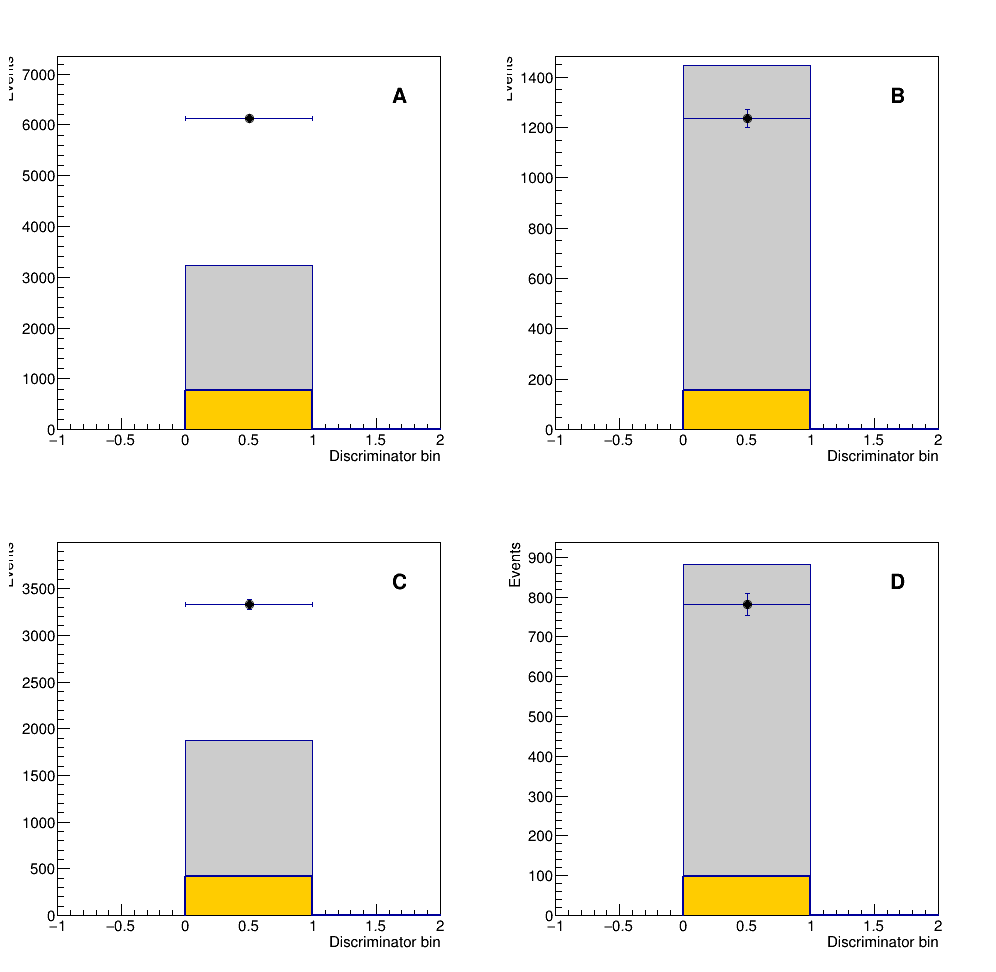

In [80]:
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)

fIn=ROOT.TFile.Open('shapesMVA_.root')

c=ROOT.TCanvas('c','c',1000,1000)
c.Divide(2,2)
objList=[]
for i,reg in enumerate(['A','B','C','D']): 
    
    c.cd(i+1)

    sig=fIn.Get('sig_{}'.format(reg))
    bkg=fIn.Get('bkg_{}'.format(reg))
    data=fIn.Get('data_obs_{}'.format(reg))
    
    frame=data.Clone('frame_{}'.format(reg))
    frame.SetDirectory(0)
    frame.Reset('ICE')
    frame.Draw()
    frame.GetYaxis().SetTitle('Events')
    frame.GetXaxis().SetTitle('Discriminator bin')
    frame.GetXaxis().SetRangeUser(-0.2, 1.2)
    objList.append(frame)
    
    #stack background+ signal
    stack=ROOT.THStack()
    sig.SetFillColor(ROOT.kOrange)
    stack.Add(sig,'hist')
    bkg.SetFillColor(ROOT.kGray)
    stack.Add(bkg,'hist')
    stack.Draw('same')
    objList.append(stack)
    
    #overlay signal
    sig_overlay=sig.Clone()
    sig_overlay.SetLineWidth(2)
    sig_overlay.SetDirectory(0)
    sig_overlay.SetFillStyle(0)
    sig_overlay.Draw('histsame')
    objList.append(sig_overlay)
    
    #plot data
    data.SetMarkerStyle(20)
    data.Draw('e1same')

    
    frame.GetYaxis().SetRangeUser(0,data.GetMaximum()*1.2)

    
    
    txt=ROOT.TLatex()
    txt.DrawTextNDC(0.8,0.8,reg)

c.Modified()
c.Update()
c.Draw()

In [81]:
def plots_results( var, label_x, range_ ):
    
    fig, ax = plt.subplots( 2,2, figsize=(19,13) )
    var = var
    label_x = label_x
    range_ = range_
    bins = 15
    
    data_set_dados_multirp8 = data_set_dados_multirp[data_set_dados_multirp[ 'class_predict8' ] == 1 ]
    data_set_dados_multirp7 = data_set_dados_multirp[data_set_dados_multirp[ 'class_predict7' ] == 1 ]
    data_set_dados_multirp1 = data_set_dados_multirp[data_set_dados_multirp[ 'class_predict1' ] == 1 ]
    data_set_dados_multirp4 = data_set_dados_multirp[data_set_dados_multirp[ 'class_predict4' ] == 1 ]
    
    counts_8, bin_edges_8 = np.histogram( data_set_dados_multirp8[var] , bins = bins, range = range_ )
    errors_8 = np.sqrt( counts_8 )
    bin_centres_8 = ( bin_edges_8[:-1] + bin_edges_8[1:] ) / 2.

    counts_7, bin_edges_7 = np.histogram( data_set_dados_multirp7[var] , bins = bins, range = range_ )
    errors_7 = np.sqrt( counts_7 )
    bin_centres_7 = ( bin_edges_7[:-1] + bin_edges_7[1:] ) / 2.
    
    counts_1, bin_edges_1 = np.histogram( data_set_dados_multirp1[var] , bins = bins, range = range_ )
    errors_1 = np.sqrt( counts_1 )
    bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
    
    counts_4, bin_edges_4 = np.histogram( data_set_dados_multirp4[var] , bins = bins, range = range_ )
    errors_4 = np.sqrt( counts_4 )
    bin_centres_4 = ( bin_edges_4[:-1] + bin_edges_4[1:] ) / 2.    
    
    num = 8
    df_background8 = [ DataSet_multiRP_DrellYan[ DataSet_multiRP_DrellYan['class_predict{}'.format(num)] == 1 ][var], 
                      DataSet_multiRP_QCD[ DataSet_multiRP_QCD['class_predict{}'.format(num)] == 1 ][var],
                      DataSet_multiRP_single_top[ DataSet_multiRP_single_top['class_predict{}'.format(num)] == 1 ][var],
                      DataSet_multiRP_TTbar[ DataSet_multiRP_TTbar['class_predict{}'.format(num)] == 1 ][var],
                      DataSet_multiRP_VV_inclusivo[ DataSet_multiRP_VV_inclusivo['class_predict{}'.format(num)] == 1 ][var],
                      DataSet_multiRP_WJets[ DataSet_multiRP_WJets['class_predict{}'.format(num)] == 1 ][var] ]

    df_background_weight8 = [ DataSet_multiRP_DrellYan[ DataSet_multiRP_DrellYan['class_predict{}'.format(num)] == 1 ]['weight'], 
                      DataSet_multiRP_QCD[ DataSet_multiRP_QCD['class_predict{}'.format(num)] == 1 ]['weight'] ,
                      DataSet_multiRP_single_top[ DataSet_multiRP_single_top['class_predict{}'.format(num)] == 1 ]['weight'],
                      DataSet_multiRP_TTbar[ DataSet_multiRP_TTbar['class_predict{}'.format(num)] == 1 ]['weight'],
                      DataSet_multiRP_VV_inclusivo[ DataSet_multiRP_VV_inclusivo['class_predict{}'.format(num)] == 1 ]['weight'],
                      DataSet_multiRP_WJets[ DataSet_multiRP_WJets['class_predict{}'.format(num)] == 1 ]['weight'] ]
    num = 7
    df_background7 = [ DataSet_multiRP_DrellYan[ DataSet_multiRP_DrellYan['class_predict{}'.format(num)] == 1 ][var], 
                      DataSet_multiRP_QCD[ DataSet_multiRP_QCD['class_predict{}'.format(num)] == 1 ][var],
                      DataSet_multiRP_single_top[ DataSet_multiRP_single_top['class_predict{}'.format(num)] == 1 ][var],
                      DataSet_multiRP_TTbar[ DataSet_multiRP_TTbar['class_predict{}'.format(num)] == 1 ][var],
                      DataSet_multiRP_VV_inclusivo[ DataSet_multiRP_VV_inclusivo['class_predict{}'.format(num)] == 1 ][var],
                      DataSet_multiRP_WJets[ DataSet_multiRP_WJets['class_predict{}'.format(num)] == 1 ][var] ]

    df_background_weight7 = [ DataSet_multiRP_DrellYan[ DataSet_multiRP_DrellYan['class_predict{}'.format(num)] == 1 ]['weight'], 
                      DataSet_multiRP_QCD[ DataSet_multiRP_QCD['class_predict{}'.format(num)] == 1 ]['weight'] ,
                      DataSet_multiRP_single_top[ DataSet_multiRP_single_top['class_predict{}'.format(num)] == 1 ]['weight'],
                      DataSet_multiRP_TTbar[ DataSet_multiRP_TTbar['class_predict{}'.format(num)] == 1 ]['weight'],
                      DataSet_multiRP_VV_inclusivo[ DataSet_multiRP_VV_inclusivo['class_predict{}'.format(num)] == 1 ]['weight'],
                      DataSet_multiRP_WJets[ DataSet_multiRP_WJets['class_predict{}'.format(num)] == 1 ]['weight'] ]

    num = 1
    df_background1 = [ DataSet_multiRP_DrellYan[ DataSet_multiRP_DrellYan['class_predict{}'.format(num)] == 1 ][var], 
                      DataSet_multiRP_QCD[ DataSet_multiRP_QCD['class_predict{}'.format(num)] == 1 ][var],
                      DataSet_multiRP_single_top[ DataSet_multiRP_single_top['class_predict{}'.format(num)] == 1 ][var],
                      DataSet_multiRP_TTbar[ DataSet_multiRP_TTbar['class_predict{}'.format(num)] == 1 ][var],
                      DataSet_multiRP_VV_inclusivo[ DataSet_multiRP_VV_inclusivo['class_predict{}'.format(num)] == 1 ][var],
                      DataSet_multiRP_WJets[ DataSet_multiRP_WJets['class_predict{}'.format(num)] == 1 ][var] ]

    df_background_weight1 = [ DataSet_multiRP_DrellYan[ DataSet_multiRP_DrellYan['class_predict{}'.format(num)] == 1 ]['weight'], 
                      DataSet_multiRP_QCD[ DataSet_multiRP_QCD['class_predict{}'.format(num)] == 1 ]['weight'] ,
                      DataSet_multiRP_single_top[ DataSet_multiRP_single_top['class_predict{}'.format(num)] == 1 ]['weight'],
                      DataSet_multiRP_TTbar[ DataSet_multiRP_TTbar['class_predict{}'.format(num)] == 1 ]['weight'],
                      DataSet_multiRP_VV_inclusivo[ DataSet_multiRP_VV_inclusivo['class_predict{}'.format(num)] == 1 ]['weight'],
                      DataSet_multiRP_WJets[ DataSet_multiRP_WJets['class_predict{}'.format(num)] == 1 ]['weight'] ]

    num = 4
    df_background4 = [ DataSet_multiRP_DrellYan[ DataSet_multiRP_DrellYan['class_predict{}'.format(num)] == 1 ][var], 
                      DataSet_multiRP_QCD[ DataSet_multiRP_QCD['class_predict{}'.format(num)] == 1 ][var],
                      DataSet_multiRP_single_top[ DataSet_multiRP_single_top['class_predict{}'.format(num)] == 1 ][var],
                      DataSet_multiRP_TTbar[ DataSet_multiRP_TTbar['class_predict{}'.format(num)] == 1 ][var],
                      DataSet_multiRP_VV_inclusivo[ DataSet_multiRP_VV_inclusivo['class_predict{}'.format(num)] == 1 ][var],
                      DataSet_multiRP_WJets[ DataSet_multiRP_WJets['class_predict{}'.format(num)] == 1 ][var] ]

    df_background_weight4 = [ DataSet_multiRP_DrellYan[ DataSet_multiRP_DrellYan['class_predict{}'.format(num)] == 1 ]['weight'], 
                      DataSet_multiRP_QCD [ DataSet_multiRP_QCD['class_predict{}'.format(num)] == 1 ]['weight'] ,
                      DataSet_multiRP_single_top[ DataSet_multiRP_single_top['class_predict{}'.format(num)] == 1 ]['weight'],
                      DataSet_multiRP_TTbar[ DataSet_multiRP_TTbar['class_predict{}'.format(num)] == 1 ]['weight'],
                      DataSet_multiRP_VV_inclusivo[ DataSet_multiRP_VV_inclusivo['class_predict{}'.format(num)] == 1 ]['weight'],
                      DataSet_multiRP_WJets[ DataSet_multiRP_WJets['class_predict{}'.format(num)] == 1 ]['weight'] ]



    label_back = [ 'Drell-Yan', 'QCD', 'Single Top', r'$t\bar{t}$', '(WW,WZ,ZZ) Inclusive', 'W+Jets' ]

    ax[0,0].hist( df_background8, stacked = True, bins = bins, range = range_, histtype = 'bar', label = label_back, weights = df_background_weight8 )
    ax[0,0].hist( ANOMALO8[ANOMALO8['class_predict'] == 1 ][var], ls=':', linewidth=3, bins = bins, range = range_, histtype = 'step', color = 'blue', label = r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 5 \times 10^{-6} $', weights = ANOMALO8[ANOMALO8['class_predict'] == 1 ]['weight'] )
    #ax[0,0].errorbar( bin_centres_8, counts_8, yerr=errors_8, xerr=abs(bin_centres_8[0] - bin_centres_8[1])/2,fmt='.', label = 'Data-2016', color = 'black' )
    ax[0,0].legend(loc='best', fontsize = 12)
    ax[0,0].set_xlabel(label_x, fontsize = 15)
    ax[0,0].set_ylabel('Events', fontsize = 15)

    ax[1,0].hist( df_background7, stacked = True, bins = bins, range = range_, histtype = 'bar', label = label_back, weights = df_background_weight7 )
    ax[1,0].hist( ANOMALO7[ANOMALO7['class_predict'] == 1 ][var], ls=':', linewidth=3, bins = bins, range = range_, histtype = 'step', color = 'blue', label =  r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 2.0 \times 10^{-6} $', weights = ANOMALO7[ANOMALO7['class_predict'] == 1 ]['weight'] )
    #ax[1,0].errorbar( bin_centres_7, counts_7, yerr=errors_7, xerr=abs(bin_centres_7[0] - bin_centres_7[1])/2,fmt='.', label = 'Data-2016', color = 'black' )    
    ax[1,0].legend(loc='best', fontsize = 12)
    ax[1,0].set_xlabel(label_x, fontsize = 15)
    ax[1,0].set_ylabel('Events', fontsize = 15)

    ax[0,1].hist( df_background1, stacked = True, bins = bins, range = range_, histtype = 'bar', label = label_back, weights = df_background_weight1 )
    ax[0,1].hist( ANOMALO1[ANOMALO1['class_predict'] == 1 ][var], ls=':', linewidth=3, bins = bins, range = range_, histtype = 'step', color = 'blue', label = r'WWCEP $\alpha_{C}^{W}/\Lambda^{2}=2.0 \times 10^{-5}$', weights = ANOMALO1[ANOMALO1['class_predict'] == 1 ]['weight'] )
    #ax[0,1].errorbar( bin_centres_1, counts_1, yerr=errors_1, xerr=abs(bin_centres_1[0] - bin_centres_1[1])/2,fmt='.', label = 'Data-2016', color = 'black' )    
    ax[0,1].legend(loc='best', fontsize = 12)
    ax[0,1].set_xlabel(label_x, fontsize = 15)
    ax[0,1].set_ylabel('Events', fontsize = 15)

    ax[1,1].hist( df_background4, stacked = True, bins = bins, range = range_, histtype = 'bar', label = label_back, weights = df_background_weight4 )
    ax[1,1].hist( ANOMALO4[ANOMALO4['class_predict'] == 1 ][var], ls=':', linewidth=3, bins = bins, range = range_, histtype = 'step', color = 'blue', label =  r'WWCEP $\alpha_{C}^{W}/\Lambda^{2}=8 \times 10^{-6}$', weights = ANOMALO4[ANOMALO4['class_predict'] == 1 ]['weight'] )
    #ax[1,1].errorbar( bin_centres_4, counts_4, yerr=errors_4, xerr=abs(bin_centres_4[0] - bin_centres_4[1])/2,fmt='.', label = 'Data-2016', color = 'black' )    
    ax[1,1].legend(loc='best', fontsize = 12)
    ax[1,1].set_xlabel(label_x, fontsize = 15)
    ax[1,1].set_ylabel('Events', fontsize = 15)

# Histogramas das variáveis após o treinamento e corte no discriminante

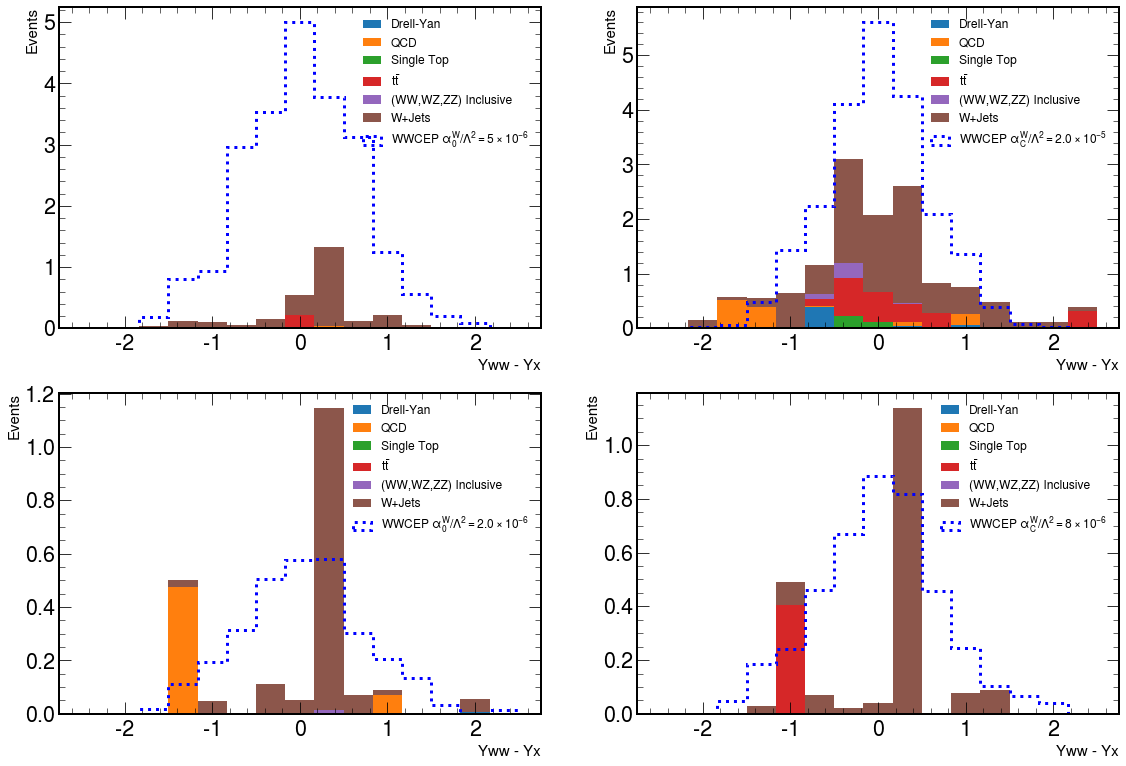

In [82]:
plots_results('Yww_Yx','Yww - Yx', (-2.5,2.5))

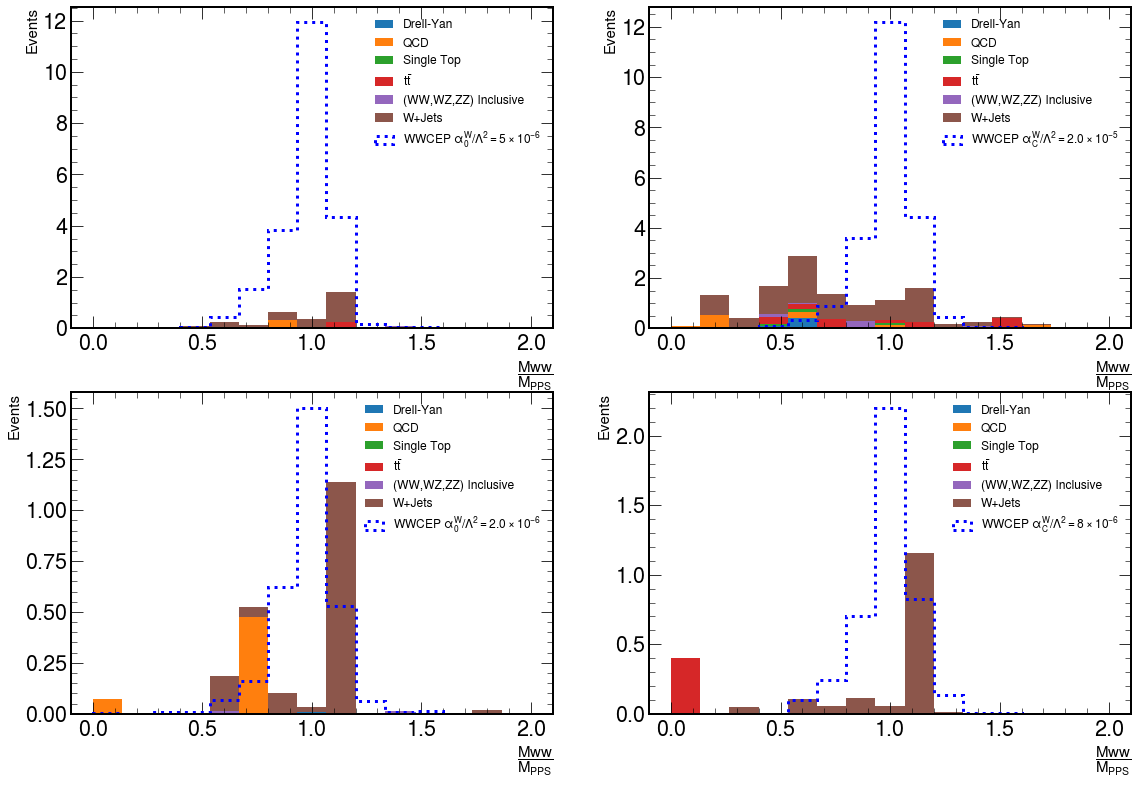

In [83]:
plots_results('Mww/Mx','$\dfrac{Mww}{M_{PPS}}$', (0,2))

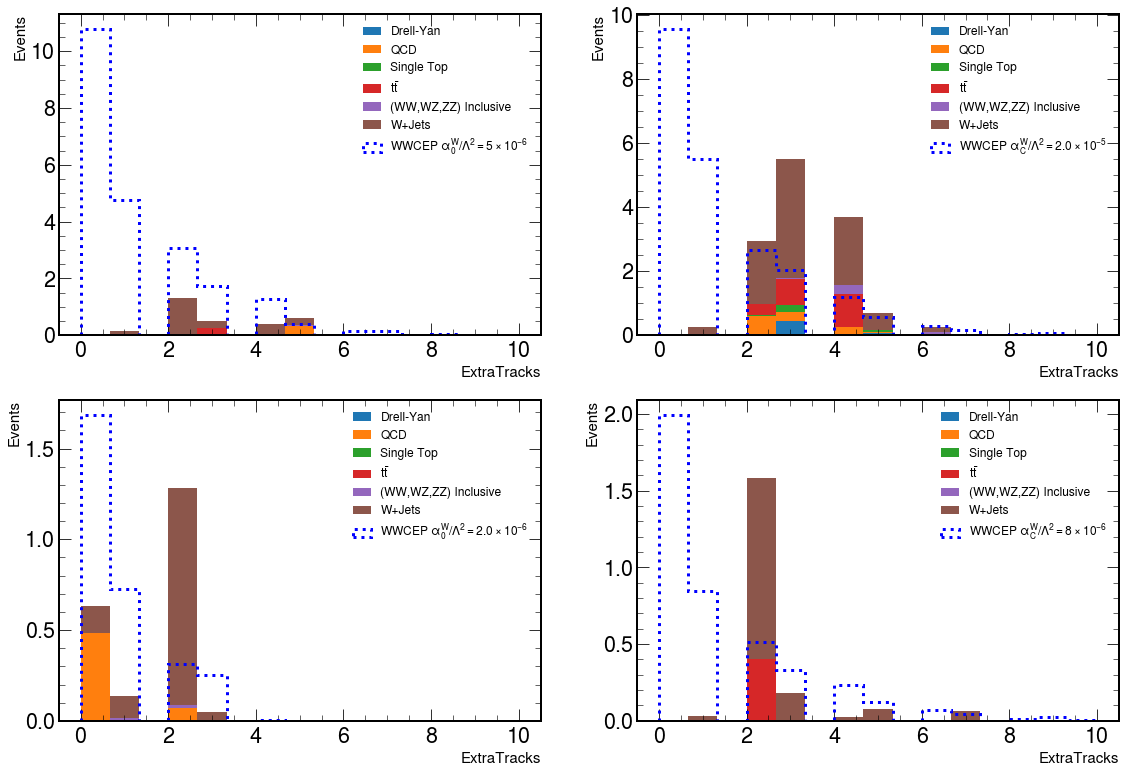

In [84]:
plots_results('ExtraTracks', 'ExtraTracks', (0,10))

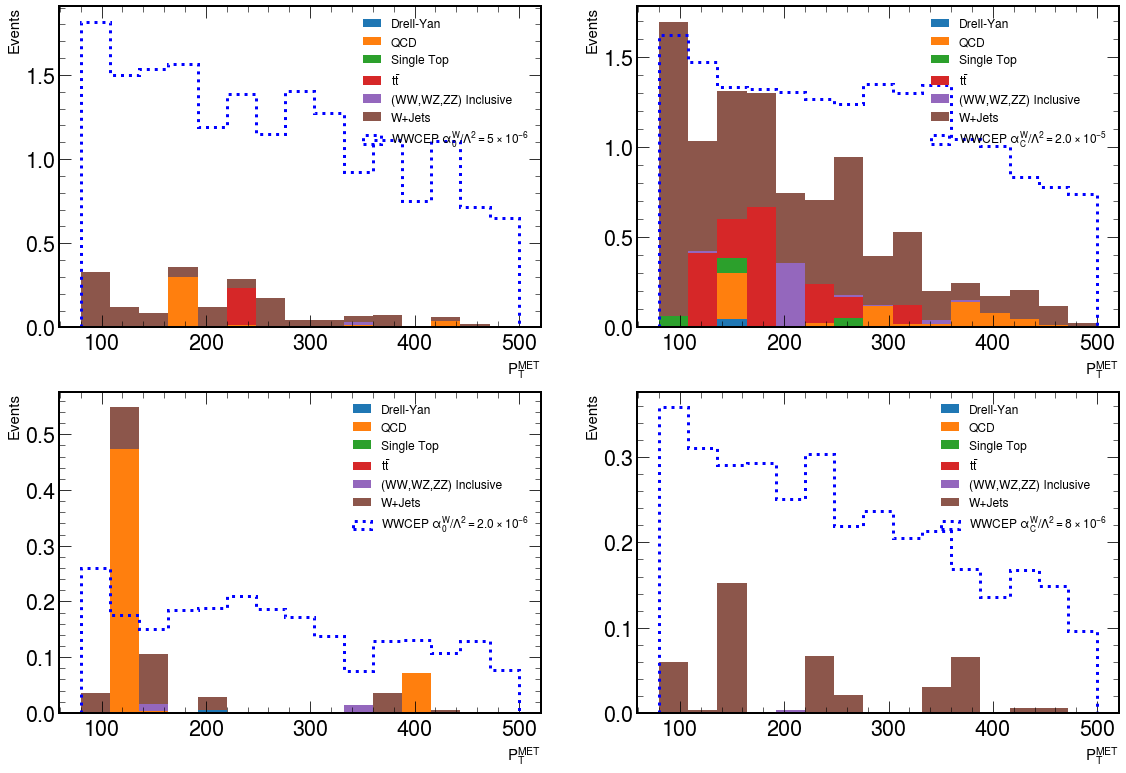

In [85]:
plots_results('METPt','$P_{T}^{MET}$', (80,500))

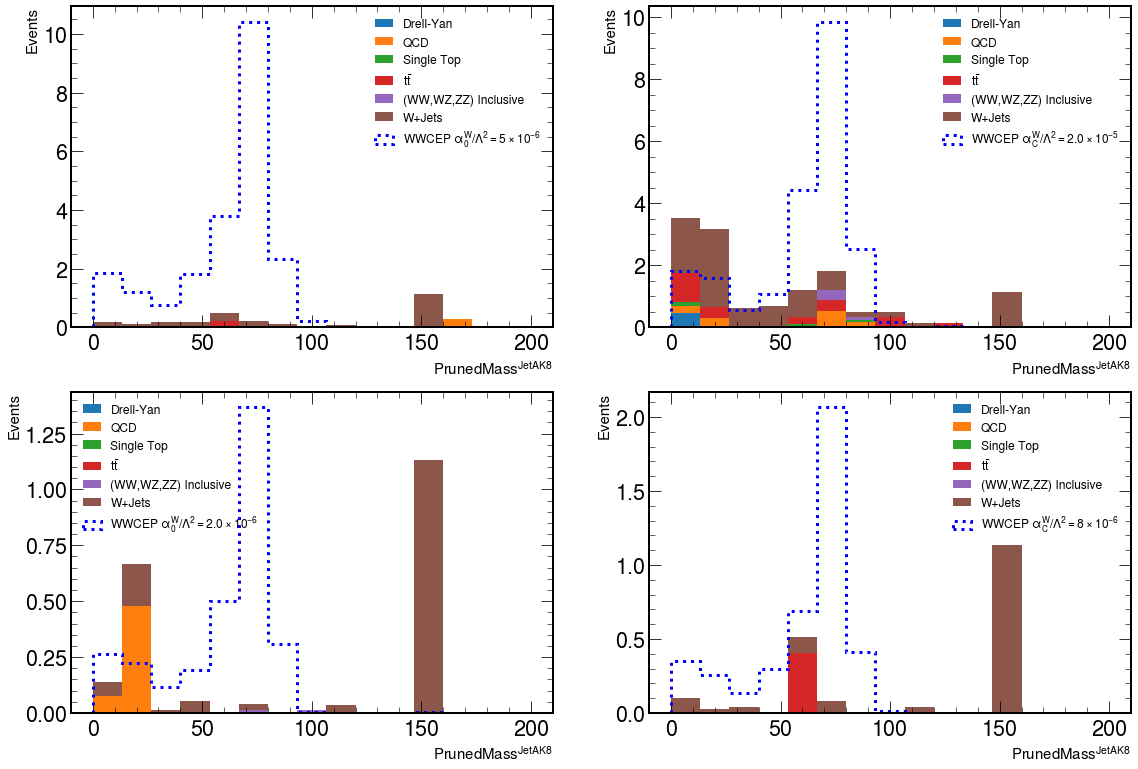

In [86]:
plots_results('jetAK8_prunedMass','$PrunedMass^{JetAK8}$', (0,200))

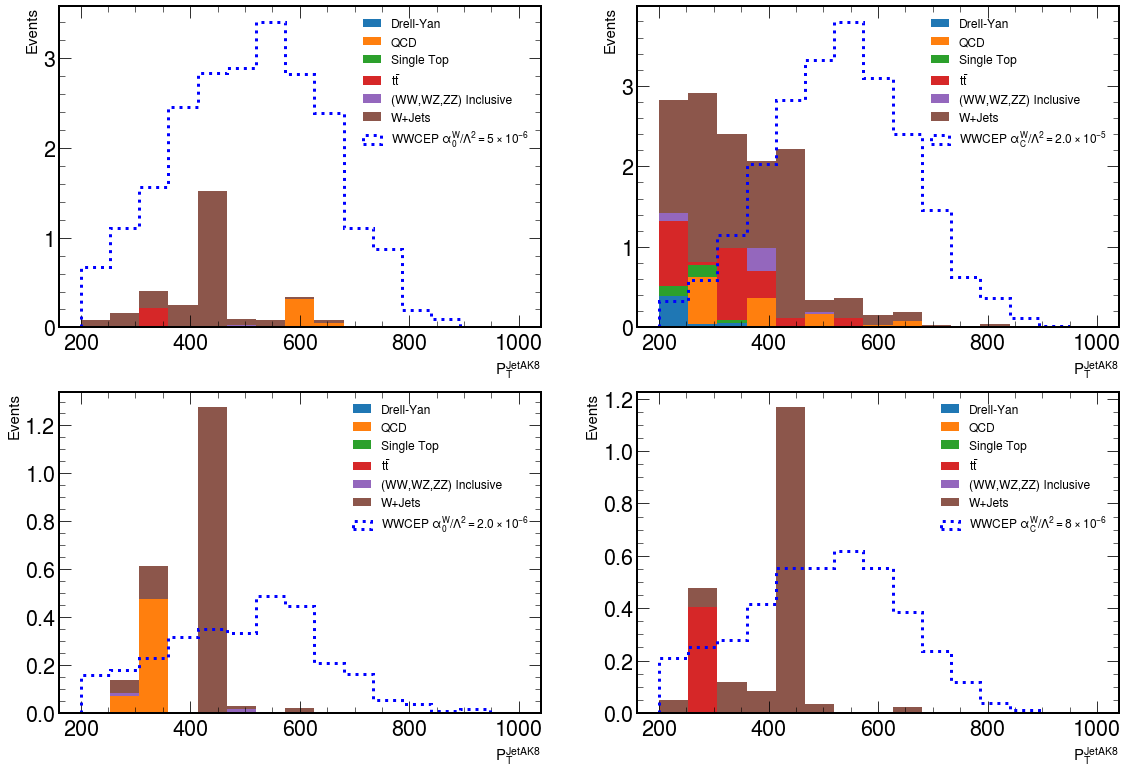

In [87]:
plots_results('jetAK8_pt','$P_{T}^{JetAK8}$', (200,1000))

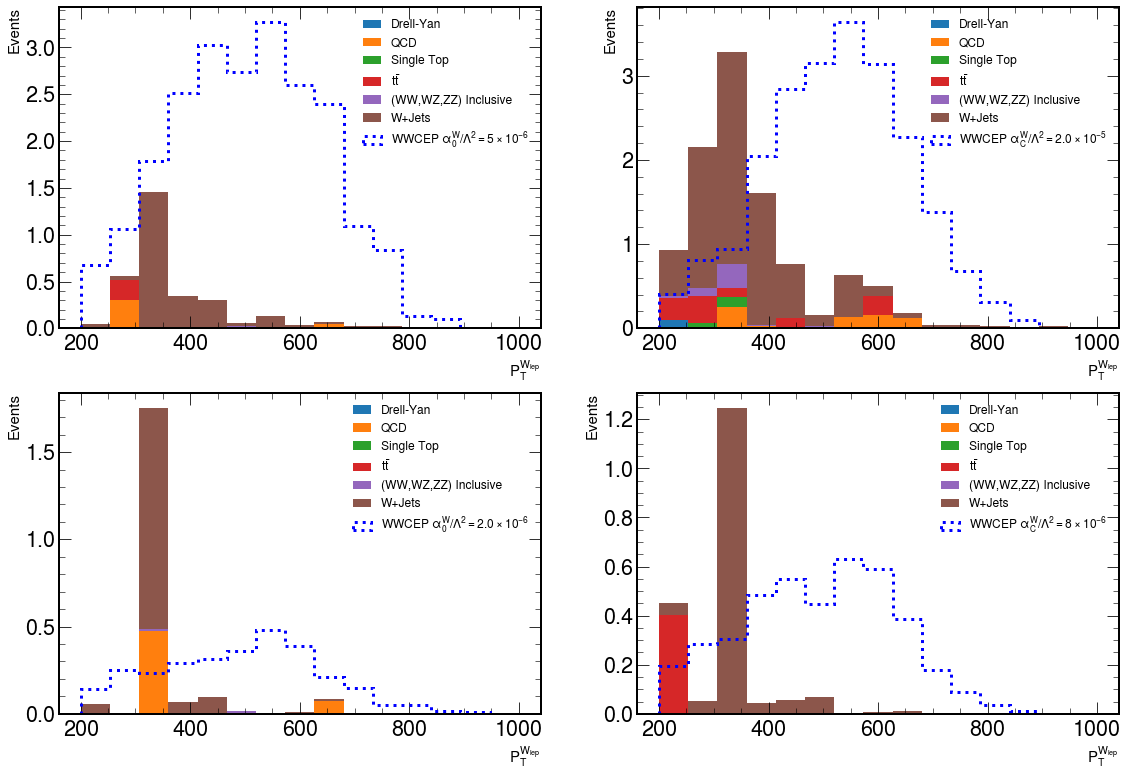

In [88]:
plots_results('Pt_W_lep', '$P_{T}^{W_{lep}}$', (200,1000))

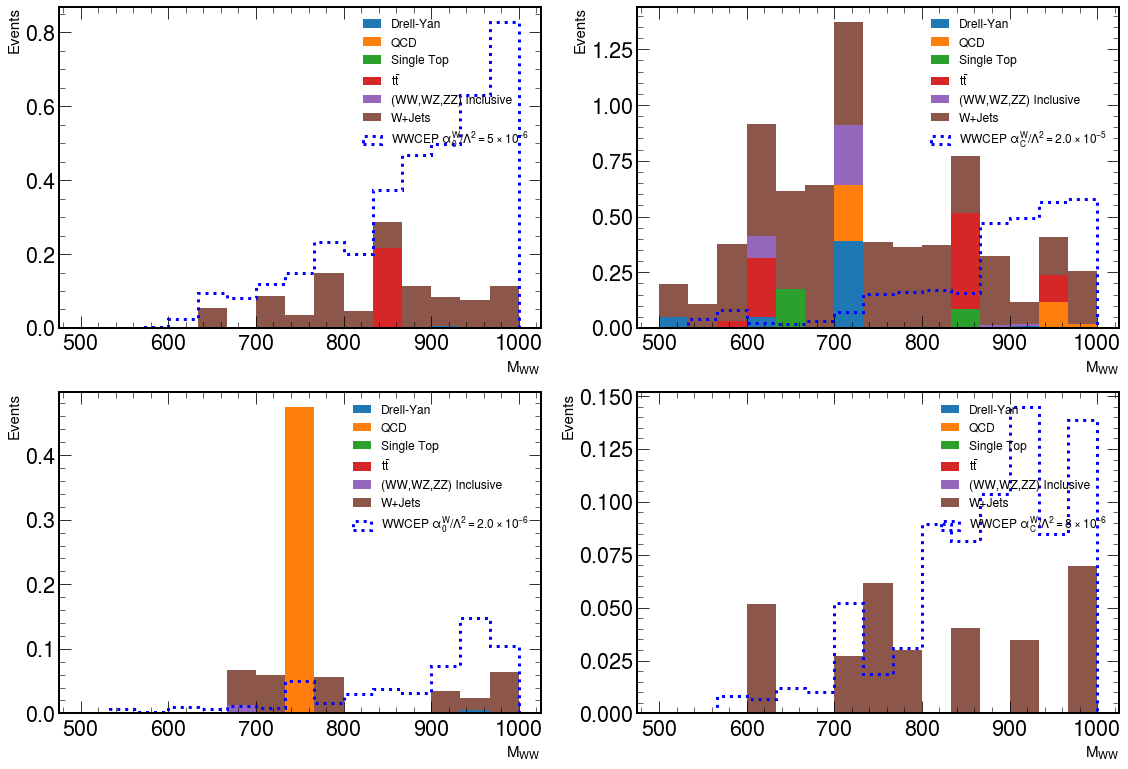

In [89]:
plots_results('Mww','$M_{WW}$', (500,1000))

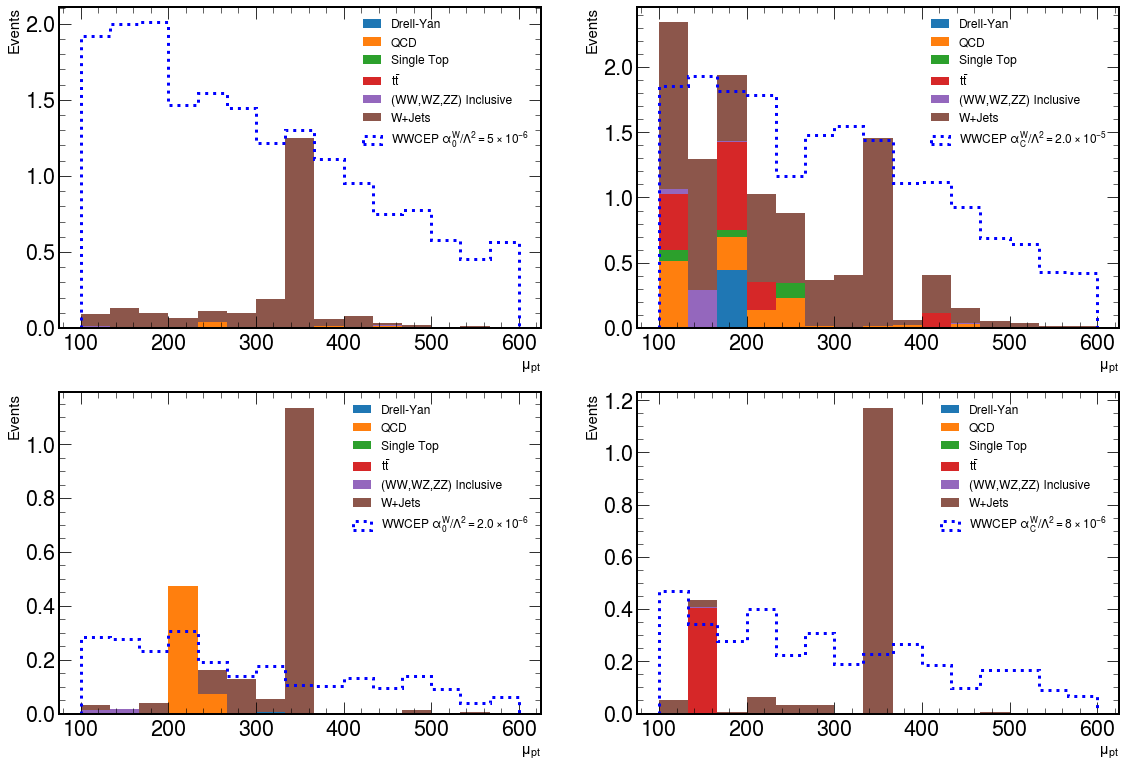

In [90]:
plots_results('muon_pt','$\mu_{pt}$',(100,600))

# Usando o Smearing no resultado do treinamento

In [91]:
from random import gauss

def xi_smearing(dset):
    df_xi1 = []
    df_xi2 = []
    for i in range(0,len(dset)):
        df_xi1.append( gauss( 0, 0.1 * dset['xi1'][i] ) + np.array( dset['xi1'][i] ) )
        df_xi2.append( gauss( 0, 0.1 * dset['xi2'][i] ) + np.array( dset['xi2'][i] ) )
    xi1_smearing = pd.DataFrame( df_xi1, columns = ['xi1_smearing'] ) 
    xi2_smearing = pd.DataFrame( df_xi2, columns = ['xi2_smearing'] ) 
    return pd.concat( [ xi1_smearing, xi2_smearing ], axis = 1 )

In [92]:
select_columns = ['Mww', 'Pt_W_lep', 'dPhi_Whad_Wlep', 'dPhi_jatos_MET', 'jetAK8_pt','jetAK8_eta', 'jetAK8_prunedMass', 'jetAK8_tau21', 'METPt', 'muon_pt', 'muon_eta', 'ExtraTracks', 'Yww', 'xi1_smearing', 'xi2_smearing', 'Mx', 'Yx', 'Mww/Mx', 'Yww_Yx']

In [ ]:
from tqdm import tqdm # mostra o tempo que passou e quanto tempo falta para terminar o loop
for i in tqdm(range(2)):
    if i == 0: 
        dset_SM5_mod = DataSet_Test5_[DataSet_Test5_['label']==2]
    df_xi1_SM = []
    df_xi2_SM = []
    for j in range( 0, len( DataSet_Test5_[ DataSet_Test5_[ 'label' ] == 2 ] ) ):
        df_xi1_SM.append( gauss( 0, 0.1 * np.array(DataSet_Test5_[DataSet_Test5_['label']==2]['xi1'])[j] ) + np.array(DataSet_Test5_[DataSet_Test5_['label']==2]['xi1'])[j] ) 
        df_xi2_SM.append( gauss( 0, 0.1 * np.array(DataSet_Test5_[DataSet_Test5_['label']==2]['xi2'])[j] ) + np.array(DataSet_Test5_[DataSet_Test5_['label']==2]['xi2'])[j] )
    dset_SM5_mod['xi1'] = df_xi1_SM
    dset_SM5_mod['xi2'] = df_xi2_SM
    
    if i == 0: 
        dset_ANOMALO5_mod = DataSet_Test5_[ DataSet_Test5_[ 'label' ] == 1 ]
    df_xi1_ANOMALO5 = []
    df_xi2_ANOMALO5 = []
    for j in range( 0, len( DataSet_Test5_[ DataSet_Test5_[ 'label' ] == 1 ] ) ):
        df_xi1_ANOMALO5.append( gauss( 0, 0.1 * np.array(DataSet_Test5_[DataSet_Test5_['label']==1]['xi1'])[j] ) + np.array(DataSet_Test5_[DataSet_Test5_['label']==1]['xi1'])[j] ) 
        df_xi2_ANOMALO5.append( gauss( 0, 0.1 * np.array(DataSet_Test5_[DataSet_Test5_['label']==1]['xi2'])[j] ) + np.array(DataSet_Test5_[DataSet_Test5_['label']==1]['xi2'])[j] )

    dset_ANOMALO5_mod['xi1'] = df_xi1_ANOMALO5
    dset_ANOMALO5_mod['xi2'] = df_xi2_ANOMALO5

    if i == 0: 
        set_back_mod = DataSet_Test5_[ DataSet_Test5_[ 'label' ] == 0 ] 
    df_xi1_back = []
    df_xi2_back = []
    dset_back_mod = DataSet_Test5_[ DataSet_Test5_[ 'label' ] == 0 ] 
    for j in range( 0, len( DataSet_Test5_[ DataSet_Test5_[ 'label' ] == 0 ] ) ):
        df_xi1_back.append( gauss( 0, 0.1 * np.array(DataSet_Test5_[DataSet_Test5_['label']==0]['xi1'])[j] ) + np.array(DataSet_Test5_[DataSet_Test5_['label']==0]['xi1'])[j] ) 
        df_xi2_back.append( gauss( 0, 0.1 * np.array(DataSet_Test5_[DataSet_Test5_['label']==0]['xi2'])[j] ) + np.array(DataSet_Test5_[DataSet_Test5_['label']==0]['xi2'])[j] )

    dset_back_mod['xi1'] = df_xi1_back
    dset_back_mod['xi2'] = df_xi2_back
    
    dset5 = pd.concat( [ dset_SM5_mod, dset_ANOMALO5_mod, dset_back_mod ], axis = 0 )    
    resultado_bdt = bst5_binary_logloss_scale_pos_weight.predict(dset5)
    print(resultado_bdt)

  0%|          | 0/2 [00:00<?, ?it/s]/home/matheus/miniconda3/envs/root_/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/matheus/miniconda3/envs/root_/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/matheus/miniconda3/envs/root_/lib/python3.6/site-packages/ipykernel_launcher.py:21: Setti

In [ ]:
predict_proba_LGBM8_binary_logloss_scale_pos_weight = bst8_binary_logloss_scale_pos_weight.predict(DataSet_Test8_[select_columns])
print('Predict Proba Anomalo 8 --> \n', predict_proba_LGBM8_binary_logloss_scale_pos_weight)

predict_proba_LGBM7_binary_logloss_scale_pos_weight = bst7_binary_logloss_scale_pos_weight.predict(DataSet_Test7_[select_columns])
print('Predict Proba Anomalo 7 --> \n', predict_proba_LGBM7_binary_logloss_scale_pos_weight)

predict_proba_LGBM6_binary_logloss_scale_pos_weight = bst6_binary_logloss_scale_pos_weight.predict(DataSet_Test6_[select_columns])
print('Predict Proba Anomalo 6 --> \n', predict_proba_LGBM6_binary_logloss_scale_pos_weight)

predict_proba_LGBM5_binary_logloss_scale_pos_weight = bst5_binary_logloss_scale_pos_weight.predict(DataSet_Test5_[select_columns])
print('Predict Proba Anomalo 5 --> \n', predict_proba_LGBM5_binary_logloss_scale_pos_weight)

predict_proba_LGBM1_binary_logloss_scale_pos_weight = bst1_binary_logloss_scale_pos_weight.predict(DataSet_Test1_[select_columns])
print('Predict Proba Anomalo 1 --> \n', predict_proba_LGBM1_binary_logloss_scale_pos_weight)

predict_proba_LGBM2_binary_logloss_scale_pos_weight = bst2_binary_logloss_scale_pos_weight.predict(DataSet_Test2_[select_columns])
print('Predict Proba Anomalo 2 --> \n', predict_proba_LGBM2_binary_logloss_scale_pos_weight)

predict_proba_LGBM3_binary_logloss_scale_pos_weight = bst3_binary_logloss_scale_pos_weight.predict(DataSet_Test3_[select_columns])
print('Predict Proba Anomalo 3 --> \n', predict_proba_LGBM3_binary_logloss_scale_pos_weight)

predict_proba_LGBM4_binary_logloss_scale_pos_weight = bst4_binary_logloss_scale_pos_weight.predict(DataSet_Test4_[select_columns])
print('Predict Proba Anomalo 4 --> \n', predict_proba_LGBM4_binary_logloss_scale_pos_weight)

In [ ]:
y_pred_1 = [np.argmax(line) for line in predict_proba_LGBM1_binary_logloss_scale_pos_weight > best_cut( y_test1,predict_proba_LGBM1_binary_logloss_scale_pos_weight )]
y_pred_2 = [np.argmax(line) for line in predict_proba_LGBM2_binary_logloss_scale_pos_weight > best_cut( y_test2,predict_proba_LGBM2_binary_logloss_scale_pos_weight )]
y_pred_3 = [np.argmax(line) for line in predict_proba_LGBM3_binary_logloss_scale_pos_weight > best_cut( y_test3,predict_proba_LGBM3_binary_logloss_scale_pos_weight )]
y_pred_4 = [np.argmax(line) for line in predict_proba_LGBM4_binary_logloss_scale_pos_weight > best_cut( y_test4,predict_proba_LGBM4_binary_logloss_scale_pos_weight )]
y_pred_5 = [np.argmax(line) for line in predict_proba_LGBM5_binary_logloss_scale_pos_weight > best_cut( y_test5,predict_proba_LGBM5_binary_logloss_scale_pos_weight )]
y_pred_6 = [np.argmax(line) for line in predict_proba_LGBM6_binary_logloss_scale_pos_weight > best_cut( y_test6,predict_proba_LGBM6_binary_logloss_scale_pos_weight )]
y_pred_7 = [np.argmax(line) for line in predict_proba_LGBM7_binary_logloss_scale_pos_weight > best_cut( y_test7,predict_proba_LGBM7_binary_logloss_scale_pos_weight )]
y_pred_8 = [np.argmax(line) for line in predict_proba_LGBM8_binary_logloss_scale_pos_weight > best_cut( y_test8,predict_proba_LGBM8_binary_logloss_scale_pos_weight )]


In [ ]:
fig, ax = plt.subplots( 2, 2, figsize=(24,15) )
predict_dados = bst4_binary_logloss_scale_pos_weight.predict(data_set_dados_multirp[ select_columns ])[:,1]
bins = 25

hbgt_lgb = ax[0,0].hist( predict_proba_LGBM4_binary_logloss_scale_pos_weight[ y_test4 == 0 ][:,1], bins = np.linspace(0,1,bins), alpha=1, histtype = 'bar', color = 'pink', label = 'Background', weights = DataSet_Test4_weight_backgr/test_size )
ax[0,0].hist( predict_proba_LGBM4_binary_logloss_scale_pos_weight[ y_test4 == 1 ][:,1], bins = np.linspace(0,1,bins), ls='-', linewidth=2.5, histtype = 'step', label = r'WWCEP $\alpha_{C}^{W}/\Lambda^{2}=8.0 \times 10^{-6}$', weights = DataSet_Test4_weight_signal/test_size, color = 'green' )
ax[0,0].hist( predict_proba_LGBM4_binary_logloss_scale_pos_weight[ y_test4 == 2 ][:,1], bins = np.linspace(0,1,bins), ls='--', linewidth=2.5, histtype = 'step', label = 'Standard Model', weights = DataSet_TestSM4_weight_signal/test_size, color = 'blue' )

uppery_lgb=np.max(hbgt_lgb[0])
ax[0,0].plot( [ best_cut(y_test4,predict_proba_LGBM4_binary_logloss_scale_pos_weight),best_cut( y_test4,predict_proba_LGBM4_binary_logloss_scale_pos_weight)],[0,uppery_lgb],"-.r", linewidth=2.5,  label='Best cut : {:2.3f}'.format( best_cut( y_test4, predict_proba_LGBM4_binary_logloss_scale_pos_weight) ) )
  
counts_1, bin_edges_1 = np.histogram( predict_dados[ predict_dados < best_cut( y_test4,predict_proba_LGBM4_binary_logloss_scale_pos_weight ) ] , bins = np.linspace(0,1,bins) )
errors_1 = np.sqrt( counts_1 )
bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
ax[0,0].errorbar( bin_centres_1, counts_1, yerr=errors_1, xerr=abs(bin_centres_1[1] - bin_centres_1[2])/2, fmt='.', label = 'Data-2016', color = 'black' )

n_events_back_after_cut4 = predict_proba_LGBM4_binary_logloss_scale_pos_weight[ y_test4 == 0 ][:,1] > best_cut( y_test4, predict_proba_LGBM4_binary_logloss_scale_pos_weight ) 
n_events_signal_after_cut4 = predict_proba_LGBM4_binary_logloss_scale_pos_weight[ y_test4 == 1 ][:,1] > best_cut(y_test4,predict_proba_LGBM4_binary_logloss_scale_pos_weight )
n_events_SM_after_cut4 = predict_proba_LGBM4_binary_logloss_scale_pos_weight[ y_test4 == 2 ][:,1] > best_cut(y_test4,predict_proba_LGBM4_binary_logloss_scale_pos_weight )
n_eventos_Data_after_cut4 = predict_dados[ predict_dados >= best_cut( y_test4,predict_proba_LGBM4_binary_logloss_scale_pos_weight ) ]

print(" ------------------ Anomalo 4 ------------------ ")
print('Numero de eventos de background depois do corte -->', DataSet_Test4_weight_backgr[ n_events_back_after_cut4 ].sum() / test_size )
print('Numero de eventos de signal depois do corte -->', DataSet_Test4_weight_signal[ n_events_signal_after_cut4].sum() / test_size )
print('Numero de eventos de SM depois do corte -->', DataSet_TestSM4_weight_signal[ n_events_SM_after_cut4 ].sum() / test_size )
print('Recall Score',recall_score(y_test4,y_pred_4, average = 'weighted') )
print('Precision Score',precision_score(y_test4,y_pred_4, average = 'weighted') )

ax[0,0].text(best_cut( y_test4, predict_proba_LGBM4_binary_logloss_scale_pos_weight )+0.05 , 6, 'Signal Region \n\n Blinded Data', color = 'red', fontsize = 16)    
ax[0,0].set_ylabel( "Events (Log Scale)" )
ax[0,0].set_title( "Mangueira Plot", fontsize = 16  )
ax[0,0].legend( loc = "upper right", fontsize = 16 )
ax[0,0].set_yscale( 'log' )
ax[0,0] = hep.cms.label( llabel="Preliminary", rlabel=r"$\mathcal{L} = 9.792\;fb^{-1}$ 13(TeV)", fontsize = 16, ax = ax[0,0] )


predict_dados = bst1_binary_logloss_scale_pos_weight.predict(data_set_dados_multirp[ select_columns ])[:,1]
bins = 25

hbgt_lgb = ax[0,1].hist( predict_proba_LGBM1_binary_logloss_scale_pos_weight[ y_test1 == 0 ][:,1], bins = np.linspace(0,1,bins), alpha=1, histtype = 'bar', color = 'pink', label = 'Background', weights = DataSet_Test1_weight_backgr/test_size )
ax[0,1].hist( predict_proba_LGBM1_binary_logloss_scale_pos_weight[ y_test1 == 1 ][:,1], bins = np.linspace(0,1,bins), ls='-', linewidth=2.5, histtype = 'step', label = r'WWCEP $\alpha_{C}^{W}/\Lambda^{2}=2.0 \times 10^{-5}$', weights = DataSet_Test1_weight_signal/test_size, color = 'green' )
ax[0,1].hist( predict_proba_LGBM1_binary_logloss_scale_pos_weight[ y_test1 == 2 ][:,1], bins = np.linspace(0,1,bins), ls='--', linewidth=2.5, histtype = 'step', label = 'Standard Model', weights = DataSet_TestSM1_weight_signal/test_size, color = 'blue' )

uppery_lgb=np.max(hbgt_lgb[0])
ax[0,1].plot( [ best_cut(y_test1,predict_proba_LGBM1_binary_logloss_scale_pos_weight),best_cut(y_test1,predict_proba_LGBM1_binary_logloss_scale_pos_weight)],[0,uppery_lgb],"-.r", linewidth=2.5,  label='Best cut : {:2.3f}'.format( best_cut( y_test1, predict_proba_LGBM1_binary_logloss_scale_pos_weight) ) )
  
counts_1, bin_edges_1 = np.histogram( predict_dados[ predict_dados < best_cut( y_test1,predict_proba_LGBM1_binary_logloss_scale_pos_weight ) ] , bins = np.linspace(0,1,bins) )
errors_1 = np.sqrt( counts_1 )
bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
ax[0,1].errorbar( bin_centres_1, counts_1, yerr=errors_1, xerr=abs(bin_centres_1[1] - bin_centres_1[2])/2, fmt='.', label = 'Data-2016', color = 'black' )

n_events_back_after_cut1 = predict_proba_LGBM1_binary_logloss_scale_pos_weight[ y_test1 == 0 ][:,1] > best_cut( y_test1, predict_proba_LGBM1_binary_logloss_scale_pos_weight ) 
n_events_signal_after_cut1 = predict_proba_LGBM1_binary_logloss_scale_pos_weight[ y_test1 == 1 ][:,1] > best_cut(y_test1,predict_proba_LGBM1_binary_logloss_scale_pos_weight )
n_events_SM_after_cut1 = predict_proba_LGBM1_binary_logloss_scale_pos_weight[ y_test1 == 2 ][:,1] > best_cut(y_test1,predict_proba_LGBM1_binary_logloss_scale_pos_weight )
n_eventos_Data_after_cut1 = predict_dados[ predict_dados >= best_cut( y_test1,predict_proba_LGBM1_binary_logloss_scale_pos_weight ) ]

print(' ------------------ Anomalo 1 ------------------ ')
print('Numero de eventos de background depois do corte -->', DataSet_Test1_weight_backgr[ n_events_back_after_cut1 ].sum() / test_size )
print('Numero de eventos de signal depois do corte -->', DataSet_Test1_weight_signal[ n_events_signal_after_cut1].sum() / test_size )
print('Numero de eventos de SM depois do corte -->', DataSet_TestSM1_weight_signal[ n_events_SM_after_cut1 ].sum() / test_size )
print('Numero de eventos de dados depois do corte -->', len( n_eventos_Data_after_cut1 ) )
print('Recall Score',recall_score(y_test1,y_pred_1, average = 'weighted') )
print('Precision Score',precision_score(y_test1,y_pred_1, average = 'weighted') )

ax[0,1].text(best_cut( y_test1, predict_proba_LGBM1_binary_logloss_scale_pos_weight )+0.05 , 6, 'Signal Region \n\n Blinded Data', color = 'red', fontsize = 16)    
ax[0,1].set_title( "Mangueira Plot", fontsize = 16  )
ax[0,1].legend( loc = "upper right", fontsize = 16 )
ax[0,1].set_yscale( 'log' )
ax[0,1] = hep.cms.label( llabel="Preliminary", rlabel=r"$\mathcal{L} = 9.792\;fb^{-1}$ 13(TeV)", fontsize = 16, ax = ax[0,1] )

predict_dados = bst3_binary_logloss_scale_pos_weight.predict(data_set_dados_multirp[ select_columns ])[:,1]
bins = 25

hbgt_lgb = ax[1,0].hist( predict_proba_LGBM3_binary_logloss_scale_pos_weight[ y_test3 == 0 ][:,1], bins = np.linspace(0,1,bins), alpha=1, histtype = 'bar', color = 'pink', label = 'Background', weights = DataSet_Test3_weight_backgr/test_size )
ax[1,0].hist( predict_proba_LGBM3_binary_logloss_scale_pos_weight[ y_test3 == 1 ][:,1], bins = np.linspace(0,1,bins), ls='-', linewidth=2.5, histtype = 'step', label = r'WWCEP $\alpha_{C}^{W}/\Lambda^{2} = 5.0 \times 10^{-6} $', weights = DataSet_Test3_weight_signal/test_size, color = 'green' )
ax[1,0].hist( predict_proba_LGBM3_binary_logloss_scale_pos_weight[ y_test3 == 2 ][:,1], bins = np.linspace(0,1,bins), ls='--', linewidth=2.5, histtype = 'step', label = 'Standard Model', weights = DataSet_TestSM3_weight_signal/test_size, color = 'blue' )

uppery_lgb=np.max(hbgt_lgb[0])
ax[1,0].plot( [ best_cut(y_test3,predict_proba_LGBM3_binary_logloss_scale_pos_weight),best_cut(y_test3,predict_proba_LGBM3_binary_logloss_scale_pos_weight)],[0,uppery_lgb],"-.r", linewidth=2.5,  label='Best cut : {:2.3f}'.format( best_cut( y_test3, predict_proba_LGBM3_binary_logloss_scale_pos_weight) ) )
  
counts_1, bin_edges_1 = np.histogram( predict_dados[ predict_dados < best_cut( y_test3,predict_proba_LGBM3_binary_logloss_scale_pos_weight ) ] , bins = np.linspace(0,1,bins) )
errors_1 = np.sqrt( counts_1 )
bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
ax[1,0].errorbar( bin_centres_1, counts_1, yerr=errors_1, xerr=abs(bin_centres_1[1] - bin_centres_1[2])/2, fmt='.', label = 'Data-2016', color = 'black' )

n_events_back_after_cut3 = predict_proba_LGBM3_binary_logloss_scale_pos_weight[ y_test3 == 0 ][:,1] >= best_cut( y_test3, predict_proba_LGBM3_binary_logloss_scale_pos_weight ) 
n_events_signal_after_cut3 = predict_proba_LGBM3_binary_logloss_scale_pos_weight[ y_test3 == 1 ][:,1] >= best_cut(y_test3,predict_proba_LGBM3_binary_logloss_scale_pos_weight )
n_events_SM_after_cut3 = predict_proba_LGBM3_binary_logloss_scale_pos_weight[ y_test3 == 2 ][:,1] >= best_cut(y_test3,predict_proba_LGBM3_binary_logloss_scale_pos_weight )
n_eventos_Data_after_cut3 = predict_dados[ predict_dados >= best_cut( y_test3,predict_proba_LGBM3_binary_logloss_scale_pos_weight ) ]

print(' ------------------ Anomalo 3 ------------------ ')
print('Numero de eventos de background depois do corte -->', DataSet_Test3_weight_backgr[ n_events_back_after_cut3 ].sum() / test_size )
print('Numero de eventos de signal depois do corte -->', DataSet_Test3_weight_signal[ n_events_signal_after_cut3].sum() / test_size )
print('Numero de eventos de SM depois do corte -->', DataSet_TestSM3_weight_signal[ n_events_SM_after_cut3 ].sum() / test_size )
print('Numero de eventos de dados depois do corte -->', len( n_eventos_Data_after_cut3 ) )
print('Recall Score',recall_score(y_test3,y_pred_3, average = 'weighted') )
print('Precision Score',precision_score(y_test3,y_pred_3, average = 'weighted') )

ax[1,0].text(best_cut( y_test3, predict_proba_LGBM3_binary_logloss_scale_pos_weight )+0.05 , 6, 'Signal Region \n\n Blinded Data', color = 'red', fontsize = 16)    
ax[1,0].set_title( "Mangueira Plot", fontsize = 16  )
ax[1,0].legend( loc = "upper right", fontsize = 16 )
ax[1,0].set_yscale( 'log' )
ax[1,0] = hep.cms.label( llabel="Preliminary", rlabel=r"$\mathcal{L} = 9.792\;fb^{-1}$ 13(TeV)", fontsize = 16, ax = ax[1,0] )

predict_dados = bst2_binary_logloss_scale_pos_weight.predict(data_set_dados_multirp[ select_columns ])[:,1]
bins = 25

hbgt_lgb = ax[1,1].hist( predict_proba_LGBM2_binary_logloss_scale_pos_weight[ y_test2 == 0 ][:,1], bins = np.linspace(0,1,bins), alpha=1, histtype = 'bar', color = 'pink', label = 'Background', weights = DataSet_Test2_weight_backgr/test_size )
ax[1,1].hist( predict_proba_LGBM2_binary_logloss_scale_pos_weight[ y_test2 == 1 ][:,1], bins = np.linspace(0,1,bins), ls='-', linewidth=2.5, histtype = 'step', label = r'WWCEP $\alpha_{C}^{W}/\Lambda^{2} = 2.0 \times 10^{-6} $', weights = DataSet_Test2_weight_signal/test_size, color = 'green' )
ax[1,1].hist( predict_proba_LGBM2_binary_logloss_scale_pos_weight[ y_test2 == 2 ][:,1], bins = np.linspace(0,1,bins), ls='--', linewidth=2.5, histtype = 'step', label = 'Standar Model', weights = DataSet_TestSM2_weight_signal/test_size, color = 'blue' )

uppery_lgb=np.max(hbgt_lgb[0])
ax[1,1].plot( [ best_cut(y_test2,predict_proba_LGBM2_binary_logloss_scale_pos_weight),best_cut(y_test2,predict_proba_LGBM2_binary_logloss_scale_pos_weight)],[0,uppery_lgb],"-.r", linewidth=2.5,  label='Best cut : {:2.3f}'.format( best_cut( y_test2, predict_proba_LGBM2_binary_logloss_scale_pos_weight) ) )
  
counts_1, bin_edges_1 = np.histogram( predict_dados[ predict_dados < best_cut( y_test2,predict_proba_LGBM2_binary_logloss_scale_pos_weight ) ] , bins = np.linspace(0,1,bins) )
errors_1 = np.sqrt( counts_1 )
bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
ax[1,1].errorbar( bin_centres_1, counts_1, yerr=errors_1, xerr=abs(bin_centres_1[1] - bin_centres_1[2])/2, fmt='.', label = 'Data-2016', color = 'black' )

n_events_back_after_cut2 = predict_proba_LGBM2_binary_logloss_scale_pos_weight[ y_test2 == 0 ][:,1] > best_cut( y_test2, predict_proba_LGBM2_binary_logloss_scale_pos_weight ) 
n_events_signal_after_cut2 = predict_proba_LGBM2_binary_logloss_scale_pos_weight[ y_test2 == 1 ][:,1] > best_cut(y_test2,predict_proba_LGBM2_binary_logloss_scale_pos_weight )
n_events_SM_after_cut2 = predict_proba_LGBM2_binary_logloss_scale_pos_weight[ y_test2 == 2 ][:,1] > best_cut(y_test2,predict_proba_LGBM2_binary_logloss_scale_pos_weight )
n_eventos_Data_after_cut2 = predict_dados[ predict_dados > best_cut( y_test2,predict_proba_LGBM2_binary_logloss_scale_pos_weight ) ]

print(' ------------------ Anomalo 2 ------------------ ')
print('Numero de eventos de background depois do corte -->', DataSet_Test2_weight_backgr[ n_events_back_after_cut2 ].sum() / test_size )
print('Numero de eventos de signal depois do corte -->', DataSet_Test2_weight_signal[ n_events_signal_after_cut2 ].sum() / test_size )
print('Numero de eventos de SM depois do corte -->', DataSet_TestSM2_weight_signal[ n_events_SM_after_cut2 ].sum() / test_size )
print('Numero de eventos de dados depois do corte -->', len( n_eventos_Data_after_cut2 ) )
print('Recall Score',recall_score(y_test2,y_pred_2, average = 'weighted') )
print('Precision Score',precision_score(y_test2,y_pred_2, average = 'weighted') )

ax[1,1].set_xlabel( "Probability" )
ax[1,1].set_title( "Mangueira Plot", fontsize = 16  )
ax[1,1].legend( loc = "upper right", fontsize = 16 )
ax[1,1].set_yscale( 'log' )
ax[1,1].text(best_cut( y_test2, predict_proba_LGBM2_binary_logloss_scale_pos_weight )+0.05 , 6, 'Signal Region \n\n Blinded Data', color = 'red', fontsize = 16)    
ax[1,1] = hep.cms.label( llabel="Preliminary", rlabel=r"$\mathcal{L} = 9.792\;fb^{-1}$ 13(TeV)", fontsize = 16, ax = ax[1,1] )

In [ ]:
fig, ax = plt.subplots( 2, 2, figsize=(24,15) )
predict_dados = bst5_binary_logloss_scale_pos_weight.predict(data_set_dados_multirp[ select_columns ])[:,1]
bins = 25

hbgt_lgb = ax[0,0].hist( predict_proba_LGBM5_binary_logloss_scale_pos_weight[ y_test5 == 0 ][:,1], bins = np.linspace(0,1,bins), alpha=1, histtype = 'bar', color = 'pink', label = 'Background', weights = DataSet_Test5_weight_backgr/test_size )
ax[0,0].hist( predict_proba_LGBM5_binary_logloss_scale_pos_weight[ y_test5 == 1 ][:,1], bins = np.linspace(0,1,bins), ls='-', linewidth=2.5, histtype = 'step', label = r'WWCEP $\alpha_{0}^{W}/\Lambda^{2}=0.5 \times 10^{-6}$', weights = DataSet_Test5_weight_signal/test_size, color = 'green' )
ax[0,0].hist( predict_proba_LGBM5_binary_logloss_scale_pos_weight[ y_test5 == 2 ][:,1], bins = np.linspace(0,1,bins), ls='--', linewidth=2.5, histtype = 'step', label = 'Standard Model', weights = DataSet_TestSM5_weight_signal/test_size, color = 'blue' )

uppery_lgb=np.max(hbgt_lgb[0])
ax[0,0].plot( [ best_cut(y_test5,predict_proba_LGBM5_binary_logloss_scale_pos_weight),best_cut( y_test5,predict_proba_LGBM5_binary_logloss_scale_pos_weight)],[0,uppery_lgb],"-.r", linewidth=2.5,  label='Best cut : {:2.3f}'.format( best_cut( y_test5, predict_proba_LGBM5_binary_logloss_scale_pos_weight) ) )
  
counts_1, bin_edges_1 = np.histogram( predict_dados[ predict_dados < best_cut( y_test5,predict_proba_LGBM5_binary_logloss_scale_pos_weight ) ] , bins = np.linspace(0,1,bins) )
errors_1 = np.sqrt( counts_1 )
bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
ax[0,0].errorbar( bin_centres_1, counts_1, yerr=errors_1, xerr=abs(bin_centres_1[1] - bin_centres_1[2])/2, fmt='.', label = 'Data-2016', color = 'black' )

n_events_back_after_cut5 = predict_proba_LGBM5_binary_logloss_scale_pos_weight[ y_test5 == 0 ][:,1] > best_cut( y_test5, predict_proba_LGBM5_binary_logloss_scale_pos_weight ) 
n_events_signal_after_cut5 = predict_proba_LGBM5_binary_logloss_scale_pos_weight[ y_test5 == 1 ][:,1] > best_cut(y_test5,predict_proba_LGBM5_binary_logloss_scale_pos_weight )
n_events_SM_after_cut5 = predict_proba_LGBM5_binary_logloss_scale_pos_weight[ y_test5 == 2 ][:,1] > best_cut(y_test5,predict_proba_LGBM5_binary_logloss_scale_pos_weight )
n_eventos_Data_after_cut5 = predict_dados[ predict_dados >= best_cut( y_test5,predict_proba_LGBM5_binary_logloss_scale_pos_weight ) ]

print("Anomalo 5 ")
print('Numero de eventos de background depois do corte -->', DataSet_Test5_weight_backgr[ n_events_back_after_cut5 ].sum() / test_size )
print('Numero de eventos de signal depois do corte -->', DataSet_Test5_weight_signal[ n_events_signal_after_cut5 ].sum() / test_size )
print('Numero de eventos de SM depois do corte -->', DataSet_TestSM5_weight_signal[ n_events_SM_after_cut5 ].sum() / test_size )
print('Recall Score',recall_score(y_test5,y_pred_5, average = 'weighted') )
print('Precision Score',precision_score(y_test5,y_pred_5, average = 'weighted') )

ax[0,0].text(best_cut( y_test5, predict_proba_LGBM5_binary_logloss_scale_pos_weight )+0.05 , 6, 'Signal Region \n\n Blinded Data', color = 'red', fontsize = 16)    
ax[0,0].set_ylabel( "Events (Log Scale)" )
ax[0,0].set_title( "Mangueira Plot", fontsize = 16  )
ax[0,0].legend( loc = "upper right", fontsize = 16 )
ax[0,0].set_yscale( 'log' )
ax[0,0] = hep.cms.label( llabel="Preliminary", rlabel=r"$\mathcal{L} = 9.792\;fb^{-1}$ 13(TeV)", fontsize = 16, ax = ax[0,0] )


predict_dados = bst6_binary_logloss_scale_pos_weight.predict(data_set_dados_multirp[ select_columns ])[:,1]
bins = 25

hbgt_lgb = ax[0,1].hist( predict_proba_LGBM6_binary_logloss_scale_pos_weight[ y_test6 == 0 ][:,1], bins = np.linspace(0,1,bins), alpha=1, histtype = 'bar', color = 'pink', label = 'Background', weights = DataSet_Test6_weight_backgr/test_size )
ax[0,1].hist( predict_proba_LGBM6_binary_logloss_scale_pos_weight[ y_test6 == 1 ][:,1], bins = np.linspace(0,1,bins), ls='-', linewidth=2.5, histtype = 'step', label = r'WWCEP $\alpha_{0}^{W}/\Lambda^{2}=1.0 \times 10^{-5}$', weights = DataSet_Test6_weight_signal/test_size, color = 'green' )
ax[0,1].hist( predict_proba_LGBM6_binary_logloss_scale_pos_weight[ y_test6 == 2 ][:,1], bins = np.linspace(0,1,bins), ls='--', linewidth=2.5, histtype = 'step', label = 'Standard Model', weights = DataSet_TestSM6_weight_signal/test_size, color = 'blue' )

uppery_lgb=np.max(hbgt_lgb[0])
ax[0,1].plot( [ best_cut(y_test6,predict_proba_LGBM6_binary_logloss_scale_pos_weight),best_cut(y_test6,predict_proba_LGBM6_binary_logloss_scale_pos_weight)+0.02],[0,uppery_lgb],"-.r", linewidth=2.5,  label='Best cut : {:2.3f}'.format( best_cut( y_test6, predict_proba_LGBM6_binary_logloss_scale_pos_weight)+0.02 ) )
  
counts_1, bin_edges_1 = np.histogram( predict_dados[ predict_dados < best_cut( y_test6,predict_proba_LGBM6_binary_logloss_scale_pos_weight ) ] , bins = np.linspace(0,1,bins) )
errors_1 = np.sqrt( counts_1 )
bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
ax[0,1].errorbar( bin_centres_1, counts_1, yerr=errors_1, xerr=abs(bin_centres_1[1] - bin_centres_1[2])/2, fmt='.', label = 'Data-2016', color = 'black' )

n_events_back_after_cut6 = predict_proba_LGBM6_binary_logloss_scale_pos_weight[ y_test6 == 0 ][:,1] > best_cut( y_test6, predict_proba_LGBM6_binary_logloss_scale_pos_weight ) 
n_events_signal_after_cut6 = predict_proba_LGBM6_binary_logloss_scale_pos_weight[ y_test6 == 1 ][:,1] > best_cut(y_test6,predict_proba_LGBM6_binary_logloss_scale_pos_weight )
n_events_SM_after_cut6 = predict_proba_LGBM6_binary_logloss_scale_pos_weight[ y_test6 == 2 ][:,1] > best_cut(y_test6,predict_proba_LGBM6_binary_logloss_scale_pos_weight )
n_eventos_Data_after_cut6 = predict_dados[ predict_dados >= best_cut( y_test6,predict_proba_LGBM6_binary_logloss_scale_pos_weight ) ]

print('Anomalo 6')
print('Numero de eventos de background depois do corte -->', DataSet_Test6_weight_backgr[ n_events_back_after_cut6 ].sum() / test_size )
print('Numero de eventos de signal depois do corte -->', DataSet_Test6_weight_signal[ n_events_signal_after_cut6].sum() / test_size )
print('Numero de eventos de SM depois do corte -->', DataSet_TestSM6_weight_signal[ n_events_SM_after_cut6 ].sum() / test_size )
print('Numero de eventos de dados depois do corte -->', len( n_eventos_Data_after_cut6 ) )
print('Recall Score',recall_score(y_test6,y_pred_6, average = 'weighted') )
print('Precision Score',precision_score(y_test6,y_pred_6, average = 'weighted') )

ax[0,1].text(best_cut( y_test1, predict_proba_LGBM1_binary_logloss_scale_pos_weight )+0.05 , 6, 'Signal Region \n\n Blinded Data', color = 'red', fontsize = 16)    
ax[0,1].set_title( "Mangueira Plot", fontsize = 16  )
ax[0,1].legend( loc = "upper right", fontsize = 16 )
ax[0,1].set_yscale( 'log' )
ax[0,1] = hep.cms.label( llabel="Preliminary", rlabel=r"$\mathcal{L} = 9.792\;fb^{-1}$ 13(TeV)", fontsize = 16, ax = ax[0,1] )

predict_dados = bst7_binary_logloss_scale_pos_weight.predict(data_set_dados_multirp[ select_columns ])[:,1]
bins = 25

hbgt_lgb = ax[1,0].hist( predict_proba_LGBM7_binary_logloss_scale_pos_weight[ y_test7 == 0 ][:,1], bins = np.linspace(0,1,bins), alpha=1, histtype = 'bar', color = 'pink', label = 'Background', weights = DataSet_Test7_weight_backgr/test_size )
ax[1,0].hist( predict_proba_LGBM7_binary_logloss_scale_pos_weight[ y_test7 == 1 ][:,1], bins = np.linspace(0,1,bins), ls='-', linewidth=2.5, histtype = 'step', label = r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 2.0 \times 10^{-6} $', weights = DataSet_Test7_weight_signal/test_size, color = 'green' )
ax[1,0].hist( predict_proba_LGBM7_binary_logloss_scale_pos_weight[ y_test7 == 2 ][:,1], bins = np.linspace(0,1,bins), ls='--', linewidth=2.5, histtype = 'step', label = 'Standard Model', weights = DataSet_TestSM7_weight_signal/test_size, color = 'blue' )

uppery_lgb=np.max(hbgt_lgb[0])
ax[1,0].plot( [ best_cut(y_test7,predict_proba_LGBM7_binary_logloss_scale_pos_weight),best_cut(y_test7,predict_proba_LGBM7_binary_logloss_scale_pos_weight)],[0,uppery_lgb],"-.r", linewidth=2.5,  label='Best cut : {:2.3f}'.format( best_cut( y_test7, predict_proba_LGBM7_binary_logloss_scale_pos_weight) ) )
  
counts_1, bin_edges_1 = np.histogram( predict_dados[ predict_dados < best_cut( y_test7,predict_proba_LGBM7_binary_logloss_scale_pos_weight ) ] , bins = np.linspace(0,1,bins) )
errors_1 = np.sqrt( counts_1 )
bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
ax[1,0].errorbar( bin_centres_1, counts_1, yerr=errors_1, xerr=abs(bin_centres_1[1] - bin_centres_1[2])/2, fmt='.', label = 'Data-2016', color = 'black' )

n_events_back_after_cut7 = predict_proba_LGBM7_binary_logloss_scale_pos_weight[ y_test7 == 0 ][:,1] >= best_cut( y_test7, predict_proba_LGBM7_binary_logloss_scale_pos_weight ) 
n_events_signal_after_cut7 = predict_proba_LGBM7_binary_logloss_scale_pos_weight[ y_test7 == 1 ][:,1] >= best_cut(y_test7,predict_proba_LGBM7_binary_logloss_scale_pos_weight )
n_events_SM_after_cut7 = predict_proba_LGBM7_binary_logloss_scale_pos_weight[ y_test7 == 2 ][:,1] >= best_cut(y_test7,predict_proba_LGBM7_binary_logloss_scale_pos_weight )
n_eventos_Data_after_cut7 = predict_dados[ predict_dados >= best_cut( y_test7,predict_proba_LGBM7_binary_logloss_scale_pos_weight ) ]

print('Anomalo 7')
print('Numero de eventos de background depois do corte -->', DataSet_Test7_weight_backgr[ n_events_back_after_cut7 ].sum() / test_size )
print('Numero de eventos de signal depois do corte -->', DataSet_Test7_weight_signal[ n_events_signal_after_cut7].sum() / test_size )
print('Numero de eventos de SM depois do corte -->', DataSet_TestSM7_weight_signal[ n_events_SM_after_cut7 ].sum() / test_size )
print('Numero de eventos de dados depois do corte -->', len( n_eventos_Data_after_cut7 ) )
print('Recall Score',recall_score(y_test7,y_pred_7, average = 'weighted') )
print('Precision Score',precision_score(y_test7,y_pred_7, average = 'weighted') )

ax[1,0].text(best_cut( y_test7, predict_proba_LGBM7_binary_logloss_scale_pos_weight )+0.05 , 6, 'Signal Region \n\n Blinded Data', color = 'red', fontsize = 16)    
ax[1,0].set_title( "Mangueira Plot", fontsize = 16  )
ax[1,0].legend( loc = "upper right", fontsize = 16 )
ax[1,0].set_yscale( 'log' )
ax[1,0] = hep.cms.label( llabel="Preliminary", rlabel=r"$\mathcal{L} = 9.792\;fb^{-1}$ 13(TeV)", fontsize = 16, ax = ax[1,0] )

predict_dados = bst8_binary_logloss_scale_pos_weight.predict(data_set_dados_multirp[ select_columns ])[:,1]
bins = 25

hbgt_lgb = ax[1,1].hist( predict_proba_LGBM8_binary_logloss_scale_pos_weight[ y_test8 == 0 ][:,1], bins = np.linspace(0,1,bins), alpha=1, histtype = 'bar', color = 'pink', label = 'Background', weights = DataSet_Test8_weight_backgr/test_size )
ax[1,1].hist( predict_proba_LGBM8_binary_logloss_scale_pos_weight[ y_test8 == 1 ][:,1], bins = np.linspace(0,1,bins), ls='-', linewidth=2.5, histtype = 'step', label = r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 5.0 \times 10^{-6} $', weights = DataSet_Test8_weight_signal/test_size, color = 'green' )
ax[1,1].hist( predict_proba_LGBM8_binary_logloss_scale_pos_weight[ y_test8 == 2 ][:,1], bins = np.linspace(0,1,bins), ls='--', linewidth=2.5, histtype = 'step', label = 'Standar Model', weights = DataSet_TestSM8_weight_signal/test_size, color = 'blue' )

uppery_lgb=np.max(hbgt_lgb[0])
ax[1,1].plot( [ best_cut(y_test8,predict_proba_LGBM8_binary_logloss_scale_pos_weight),best_cut(y_test8,predict_proba_LGBM8_binary_logloss_scale_pos_weight)],[0,uppery_lgb],"-.r", linewidth=2.5,  label='Best cut : {:2.3f}'.format( best_cut( y_test8, predict_proba_LGBM8_binary_logloss_scale_pos_weight) ) )
  
counts_1, bin_edges_1 = np.histogram( predict_dados[ predict_dados < best_cut( y_test8,predict_proba_LGBM8_binary_logloss_scale_pos_weight ) ] , bins = np.linspace(0,1,bins) )
errors_1 = np.sqrt( counts_1 )
bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
ax[1,1].errorbar( bin_centres_1, counts_1, yerr=errors_1, xerr=abs(bin_centres_1[1] - bin_centres_1[2])/2, fmt='.', label = 'Data-2016', color = 'black' )

n_events_back_after_cut8 = predict_proba_LGBM8_binary_logloss_scale_pos_weight[ y_test8 == 0 ][:,1] > best_cut( y_test8, predict_proba_LGBM8_binary_logloss_scale_pos_weight ) 
n_events_signal_after_cut8 = predict_proba_LGBM8_binary_logloss_scale_pos_weight[ y_test8 == 1 ][:,1] > best_cut(y_test8,predict_proba_LGBM8_binary_logloss_scale_pos_weight )
n_events_SM_after_cut8 = predict_proba_LGBM8_binary_logloss_scale_pos_weight[ y_test8 == 2 ][:,1] > best_cut(y_test8,predict_proba_LGBM8_binary_logloss_scale_pos_weight )
n_eventos_Data_after_cut8 = predict_dados[ predict_dados > best_cut( y_test8,predict_proba_LGBM8_binary_logloss_scale_pos_weight ) ]

print('Anomalo 8')
print('Numero de eventos de background depois do corte -->', DataSet_Test8_weight_backgr[ n_events_back_after_cut8 ].sum() / test_size )
print('Numero de eventos de signal depois do corte -->', DataSet_Test8_weight_signal[ n_events_signal_after_cut8 ].sum() / test_size )
print('Numero de eventos de SM depois do corte -->', DataSet_TestSM8_weight_signal[ n_events_SM_after_cut8 ].sum() / test_size )
print('Numero de eventos de dados depois do corte -->', len( n_eventos_Data_after_cut8 ) )
print('Recall Score',recall_score(y_test8,y_pred_8, average = 'weighted') )
print('Precision Score',precision_score(y_test8,y_pred_8, average = 'weighted') ) 

ax[1,1].set_xlabel( "Probability" )
ax[1,1].set_title( "Mangueira Plot", fontsize = 16  )
ax[1,1].legend( loc = "upper right", fontsize = 16 )
ax[1,1].set_yscale( 'log' )
ax[1,1].text(best_cut( y_test8, predict_proba_LGBM8_binary_logloss_scale_pos_weight )+0.05 , 6, 'Signal Region \n\n Blinded Data', color = 'red', fontsize = 16)    
ax[1,1] = hep.cms.label( llabel="Preliminary", rlabel=r"$\mathcal{L} = 9.792\;fb^{-1}$ 13(TeV)", fontsize = 16, ax = ax[1,1] )